# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': True
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05")

readout_output_sample

tensor([[-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441],
        [-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441],
        [-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441],
        ...,
        [-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441],
        [-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441],
        [-4.6143,  5.1481, -8.9322,  ...,  9.2624, 21.6039, 14.0441]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'
BATCH_SIZE = 32

def load_dataset(date):
    # 1. Load the images and responses
    training_images = np.load(os.path.join(TRAINING_DATA_DIR, "training_images_{}.npy".format(date)))
    training_responses = np.load(os.path.join(TRAINING_DATA_DIR, "training_responses_{}.npy".format(date)))
    
    test_images = np.load(os.path.join(TRAINING_DATA_DIR, "test_images_{}.npy".format(date)))
    test_responses = np.load(os.path.join(TRAINING_DATA_DIR, "test_responses_{}.npy".format(date)))
    
    training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    
    # 2. Convert to tensors and typecast to float
    training_images = torch.from_numpy(training_images).float()
    test_images = torch.from_numpy(test_images).float()
    
    training_responses = torch.from_numpy(training_responses).float()
    test_responses = torch.from_numpy(test_responses).float()
    
    # 3. Zip training and test
    training_data = list(zip(training_images, training_responses))
    test_data = list(zip(test_images, test_responses))

    # 4. Convert to DataLoader
    train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, test_dataloader

# 1. Load data with date
train_dataloader_1, test_dataloader_1 = load_dataset("2022-12-20_15-08")
train_dataloader_2, test_dataloader_2 = load_dataset("2023-03-15_11-05")
train_dataloader_3, test_dataloader_3 = load_dataset("2023-03-15_15-23")

train_dataloaders = {
    "2022-12-20_15-08": train_dataloader_1,
    "2023-03-15_11-05": train_dataloader_2,
    "2023-03-15_15-23": train_dataloader_3,
}

test_dataloaders = {
    "2022-12-20_15-08": test_dataloader_1,
    "2023-03-15_11-05": test_dataloader_2,
    "2023-03-15_15-23": test_dataloader_3,
}


# 2. Load sample batch
images_batch, responses_batch = next(iter(train_dataloaders["2022-12-20_15-08"]))

# 5. Validate shape and types
images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([32, 1, 36, 22]), torch.Size([32, 466]), 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': True
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([32, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([32, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Setting up**

In [24]:
# Could also build the following programmatically
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    '2023-03-15_15-23': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    '2022-12-20_15-08': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 373,
    '2023-03-15_15-23': 388,
    '2022-12-20_15-08': 466
}

factorized_multi_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
    normalize=False
)

**Readout: Test the factorized**

In [25]:
with torch.no_grad():
    readout_output_sample = factorized_multi_readout(core_output, data_key="2023-03-15_11-05")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([32, 373]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [26]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [27]:
model = GeneralizedEncoderBase(
    core,
    factorized_multi_readout,
    elu=True
)

In [28]:
# raise Error
trained_model, training_history = simplified_trainer(
    model=model,
    train_loaders=train_dataloaders,
    val_loaders=test_dataloaders,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=100,
    lr=1e-4,
    patience=10 # For the early stopping
)


Currently learning for data_key:  2022-12-20_15-08
----


Epoch 1/100 (Train):   0%|                                                                               | 0/263 [00:00<?, ?it/s]

responses mean/min/max: 3.316866874694824 0.0 160.0
predictions mean/min/max: 18.57103729248047 9.999999974752427e-07 221.23228454589844
-----
loss:  tensor(38.2576, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   0%|▎                                                                      | 1/263 [00:00<01:06,  3.97it/s]

responses mean/min/max: 3.881727457046509 0.0 195.98040771484375
predictions mean/min/max: 18.56560516357422 9.999999974752427e-07 263.710693359375
-----
loss:  tensor(40.4849, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   2%|█                                                                      | 4/263 [00:00<00:20, 12.88it/s]

responses mean/min/max: 2.907475709915161 0.0 80.0
predictions mean/min/max: 18.161428451538086 9.999999974752427e-07 259.257080078125
-----
loss:  tensor(34.7760, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7545883655548096 0.0 140.0
predictions mean/min/max: 18.849491119384766 9.999999974752427e-07 235.97509765625
-----
loss:  tensor(40.7216, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0046329498291016 0.0 120.0400161743164
predictions mean/min/max: 18.70976448059082 9.999999974752427e-07 278.6188659667969
-----
loss:  tensor(36.3504, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.176532506942749 0.0 109.96334838867188
predictions mean/min/max: 17.882442474365234 9.999999974752427e-07 294.7093811035156
-----
loss:  tensor(37.1108, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5854859352111816 0.0 189.81019592285156
predictions mean/min/max: 18.34372901916504 9.999999974752427e-07 250.26370239257812

Epoch 1/100 (Train):   3%|██▏                                                                    | 8/263 [00:00<00:12, 20.15it/s]

responses mean/min/max: 3.082763195037842 0.0 100.06671142578125
predictions mean/min/max: 18.27755355834961 9.999999974752427e-07 186.4187469482422
-----
loss:  tensor(35.3280, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   4%|██▉                                                                   | 11/263 [00:00<00:10, 23.13it/s]

responses mean/min/max: 3.556975841522217 0.0 170.1134033203125
predictions mean/min/max: 18.30349349975586 9.999999974752427e-07 208.4400177001953
-----
loss:  tensor(38.2790, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9361090660095215 0.0 110.0
predictions mean/min/max: 17.919897079467773 9.999999974752427e-07 203.80233764648438
-----
loss:  tensor(34.7161, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.628101348876953 0.0 159.89340209960938
predictions mean/min/max: 17.767316818237305 9.999999974752427e-07 264.55401611328125
-----
loss:  tensor(38.6995, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4321978092193604 0.0 130.08673095703125
predictions mean/min/max: 17.659950256347656 9.999999974752427e-07 296.86651611328125
-----
loss:  tensor(37.8420, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.229330062866211 0.0 210.0700225830078
predictions mean/min/max: 17.62504768371582 9.999999974752427e-07 

Epoch 1/100 (Train):   5%|███▋                                                                  | 14/263 [00:00<00:10, 23.89it/s]

responses mean/min/max: 2.66424560546875 0.0 140.0
predictions mean/min/max: 18.15033531188965 9.999999974752427e-07 176.0647430419922
-----
loss:  tensor(33.2213, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   6%|████▌                                                                 | 17/263 [00:00<00:10, 23.86it/s]

responses mean/min/max: 3.032554864883423 0.0 170.0
predictions mean/min/max: 17.71289825439453 9.999999974752427e-07 249.44512939453125
-----
loss:  tensor(34.9550, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.269815683364868 0.0 130.17356872558594
predictions mean/min/max: 17.355022430419922 9.999999974752427e-07 261.7221374511719
-----
loss:  tensor(36.3147, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6229989528656006 0.0 149.95001220703125
predictions mean/min/max: 17.238683700561523 9.999999974752427e-07 265.63726806640625
-----
loss:  tensor(37.5470, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8562755584716797 0.0 140.0
predictions mean/min/max: 17.58089828491211 9.999999974752427e-07 174.52288818359375
-----
loss:  tensor(35.0864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0961525440216064 0.0 160.0
predictions mean/min/max: 17.448442459106445 9.999999974752427e-07 169.2356414794922
-----

Epoch 1/100 (Train):   8%|█████▎                                                                | 20/263 [00:00<00:09, 24.90it/s]

tensor(34.4846, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.566516876220703 0.0 150.05001831054688
predictions mean/min/max: 17.883560180664062 9.999999974752427e-07 183.39190673828125
-----
loss:  tensor(38.3761, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   9%|██████                                                                | 23/263 [00:01<00:09, 26.28it/s]

responses mean/min/max: 3.064934492111206 0.0 170.170166015625
predictions mean/min/max: 17.12690544128418 9.999999974752427e-07 236.0115966796875
-----
loss:  tensor(35.4105, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.397580623626709 0.0 120.0
predictions mean/min/max: 17.20293617248535 9.999999974752427e-07 181.68690490722656
-----
loss:  tensor(36.7506, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0918056964874268 0.0 149.95001220703125
predictions mean/min/max: 17.175886154174805 9.999999974752427e-07 175.37001037597656
-----
loss:  tensor(35.5717, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7086052894592285 0.0 140.0466766357422
predictions mean/min/max: 17.069625854492188 9.999999974752427e-07 249.90162658691406
-----
loss:  tensor(39.5798, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8358774185180664 0.0 110.07337951660156
predictions mean/min/max: 17.493831634521484 9.999999974752427e-07 

Epoch 1/100 (Train):  10%|███████▏                                                              | 27/263 [00:01<00:08, 27.80it/s]

responses mean/min/max: 3.364894390106201 0.0 179.9400177001953
predictions mean/min/max: 17.106103897094727 9.999999974752427e-07 182.9088592529297
-----
loss:  tensor(37.7027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.047619581222534 0.0 140.2337188720703
predictions mean/min/max: 17.414697647094727 9.999999974752427e-07 186.19847106933594
-----
loss:  tensor(34.8510, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  12%|████████▎                                                             | 31/263 [00:01<00:08, 28.64it/s]

responses mean/min/max: 3.128282308578491 0.0 150.0
predictions mean/min/max: 17.362226486206055 9.999999974752427e-07 203.4583740234375
-----
loss:  tensor(35.7815, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9027209281921387 0.0 120.0
predictions mean/min/max: 16.919218063354492 9.999999974752427e-07 237.02386474609375
-----
loss:  tensor(33.3047, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4925103187561035 0.0 164.9505157470703
predictions mean/min/max: 17.103273391723633 9.999999974752427e-07 253.0243377685547
-----
loss:  tensor(37.3820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.976285457611084 0.0 110.03668212890625
predictions mean/min/max: 17.04729461669922 9.999999974752427e-07 246.2166748046875
-----
loss:  tensor(34.3550, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  13%|█████████                                                             | 34/263 [00:01<00:08, 28.39it/s]

responses mean/min/max: 3.5260307788848877 0.0 140.0466766357422
predictions mean/min/max: 17.54526710510254 9.999999974752427e-07 222.63412475585938
-----
loss:  tensor(38.7561, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0848209857940674 0.0 149.80026245117188
predictions mean/min/max: 17.505945205688477 9.999999974752427e-07 177.1283721923828
-----
loss:  tensor(35.0626, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  14%|█████████▊                                                            | 37/263 [00:01<00:07, 28.40it/s]

responses mean/min/max: 2.9108471870422363 0.0 110.0
predictions mean/min/max: 17.15151023864746 9.999999974752427e-07 180.50506591796875
-----
loss:  tensor(34.0574, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3069000244140625 0.0 169.943359375
predictions mean/min/max: 16.84962272644043 9.999999974752427e-07 228.57118225097656
-----
loss:  tensor(35.8863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211456775665283 0.0 120.0
predictions mean/min/max: 17.00165367126465 9.999999974752427e-07 234.19818115234375
-----
loss:  tensor(35.1537, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7434816360473633 0.0 149.9000701904297
predictions mean/min/max: 17.095809936523438 9.999999974752427e-07 210.36082458496094
-----
loss:  tensor(38.0733, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.702923536300659 0.0 180.12008666992188
predictions mean/min/max: 17.245532989501953 9.999999974752427e-07 200.349365234375

Epoch 1/100 (Train):  16%|███████████▍                                                          | 43/263 [00:01<00:08, 26.49it/s]

responses mean/min/max: 2.935314178466797 0.0 100.0
predictions mean/min/max: 17.35824203491211 9.999999974752427e-07 175.89422607421875
-----
loss:  tensor(33.4775, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.314591884613037 0.0 130.0
predictions mean/min/max: 16.97814178466797 9.999999974752427e-07 235.60980224609375
-----
loss:  tensor(35.9942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0475351810455322 0.0 150.150146484375
predictions mean/min/max: 16.818485260009766 9.999999974752427e-07 237.12625122070312
-----
loss:  tensor(34.1863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2619926929473877 0.0 130.04335021972656
predictions mean/min/max: 17.183635711669922 9.999999974752427e-07 223.63531494140625
-----
loss:  tensor(35.1681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5015370845794678 0.0 169.54786682128906
predictions mean/min/max: 16.90541648864746 9.999999974752427e-07 195.28775024

Epoch 1/100 (Train):  17%|████████████▏                                                         | 46/263 [00:01<00:08, 25.22it/s]

responses mean/min/max: 3.1856675148010254 0.0 169.943359375
predictions mean/min/max: 16.861066818237305 9.999999974752427e-07 180.8296356201172
-----
loss:  tensor(34.5933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.485839366912842 0.0 219.99266052246094
predictions mean/min/max: 17.093181610107422 9.999999974752427e-07 266.6902770996094
-----
loss:  tensor(36.4178, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2693190574645996 0.0 119.96001434326172
predictions mean/min/max: 16.70097541809082 9.999999974752427e-07 228.8245086669922
-----
loss:  tensor(35.1359, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  19%|█████████████                                                         | 49/263 [00:02<00:08, 24.38it/s]

responses mean/min/max: 3.568142890930176 0.0 130.08673095703125
predictions mean/min/max: 16.55453109741211 9.999999974752427e-07 208.9365692138672
-----
loss:  tensor(37.0735, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0409677028656006 0.0 149.95001220703125
predictions mean/min/max: 16.816558837890625 9.999999974752427e-07 257.94171142578125
-----
loss:  tensor(33.9711, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  20%|█████████████▊                                                        | 52/263 [00:02<00:08, 24.47it/s]

responses mean/min/max: 3.907686471939087 0.0 200.0666961669922
predictions mean/min/max: 16.857105255126953 9.999999974752427e-07 246.40318298339844
-----
loss:  tensor(38.2135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.888195753097534 0.0 149.95001220703125
predictions mean/min/max: 16.248552322387695 9.999999974752427e-07 240.3999481201172
-----
loss:  tensor(38.1763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6607189178466797 0.0 190.0
predictions mean/min/max: 16.120182037353516 9.999999974752427e-07 189.70770263671875
-----
loss:  tensor(37.4432, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  21%|██████████████▋                                                       | 55/263 [00:02<00:08, 24.31it/s]

responses mean/min/max: 2.8172788619995117 0.0 180.0600128173828
predictions mean/min/max: 16.56647491455078 9.999999974752427e-07 242.341796875
-----
loss:  tensor(32.1360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.759645700454712 0.0 160.0
predictions mean/min/max: 16.69710922241211 9.999999974752427e-07 212.14080810546875
-----
loss:  tensor(32.5905, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  22%|███████████████▍                                                      | 58/263 [00:02<00:08, 24.00it/s]

responses mean/min/max: 3.4989609718322754 0.0 130.130126953125
predictions mean/min/max: 16.52645492553711 9.999999974752427e-07 208.4210968017578
-----
loss:  tensor(37.1209, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.322432279586792 0.0 129.95668029785156
predictions mean/min/max: 16.353368759155273 9.999999974752427e-07 217.46038818359375
-----
loss:  tensor(35.9451, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.480024576187134 0.0 150.2504119873047
predictions mean/min/max: 16.687393188476562 9.999999974752427e-07 202.96957397460938
-----
loss:  tensor(35.9563, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1404855251312256 0.0 129.95668029785156
predictions mean/min/max: 16.66012191772461 9.999999974752427e-07 303.86431884765625
-----
loss:  tensor(33.6974, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.829540967941284 0.0 129.95668029785156
predictions mean/min/max: 16.577844619750977 9.99999997

Epoch 1/100 (Train):  23%|████████████████▏                                                     | 61/263 [00:02<00:08, 24.47it/s]

responses mean/min/max: 3.320896625518799 0.0 199.933349609375
predictions mean/min/max: 16.840646743774414 9.999999974752427e-07 189.3691864013672
-----
loss:  tensor(36.1410, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.321713924407959 0.0 139.90672302246094
predictions mean/min/max: 16.894954681396484 9.999999974752427e-07 259.39068603515625
-----
loss:  tensor(35.7250, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9242217540740967 0.0 119.96001434326172
predictions mean/min/max: 16.718130111694336 9.999999974752427e-07 270.93389892578125
-----
loss:  tensor(33.1601, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398667335510254 0.0 159.89340209960938
predictions mean/min/max: 16.91726303100586 9.999999974752427e-07 259.53753662109375
-----
loss:  tensor(36.3994, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  24%|█████████████████                                                     | 64/263 [00:02<00:08, 24.83it/s]

responses mean/min/max: 2.9541866779327393 0.0 100.10009765625
predictions mean/min/max: 16.5822696685791 9.999999974752427e-07 228.09495544433594
-----
loss:  tensor(33.3932, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.838505268096924 0.0 169.943359375
predictions mean/min/max: 16.604665756225586 9.999999974752427e-07 272.4593811035156
-----
loss:  tensor(39.5258, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  25%|█████████████████▊                                                    | 67/263 [00:02<00:07, 25.10it/s]

responses mean/min/max: 3.950261354446411 0.0 160.0533447265625
predictions mean/min/max: 16.3688907623291 9.999999974752427e-07 222.9160614013672
-----
loss:  tensor(38.6624, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.351716995239258 0.0 120.28065490722656
predictions mean/min/max: 16.290437698364258 9.999999974752427e-07 200.8740997314453
-----
loss:  tensor(35.5230, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8031070232391357 0.0 140.0
predictions mean/min/max: 16.778100967407227 9.999999974752427e-07 253.0557403564453
-----
loss:  tensor(31.5299, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.038036346435547 0.0 130.04335021972656
predictions mean/min/max: 16.35774040222168 9.999999974752427e-07 264.4215393066406
-----
loss:  tensor(32.6025, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  27%|██████████████████▋                                                   | 70/263 [00:02<00:07, 25.27it/s]

responses mean/min/max: 3.2880330085754395 0.0 130.0
predictions mean/min/max: 16.52638816833496 9.999999974752427e-07 204.39930725097656
-----
loss:  tensor(36.5011, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9639103412628174 0.0 189.8734130859375
predictions mean/min/max: 16.30415916442871 9.999999974752427e-07 189.11802673339844
-----
loss:  tensor(32.8818, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  28%|███████████████████▍                                                  | 73/263 [00:02<00:07, 24.97it/s]

responses mean/min/max: 2.943040132522583 0.0 149.9000701904297
predictions mean/min/max: 16.23514747619629 9.999999974752427e-07 269.8885803222656
-----
loss:  tensor(32.4303, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7616207599639893 0.0 160.0
predictions mean/min/max: 16.428586959838867 9.999999974752427e-07 182.0139923095703
-----
loss:  tensor(37.8638, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2732608318328857 0.0 189.9366912841797
predictions mean/min/max: 16.484891891479492 9.999999974752427e-07 181.08506774902344
-----
loss:  tensor(35.3072, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.381493330001831 0.0 150.0
predictions mean/min/max: 16.302173614501953 9.999999974752427e-07 204.6636199951172
-----
loss:  tensor(35.6209, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  30%|█████████████████████                                                 | 79/263 [00:03<00:08, 22.17it/s]

responses mean/min/max: 2.988781213760376 0.0 210.0700225830078
predictions mean/min/max: 16.596080780029297 9.999999974752427e-07 236.61529541015625
-----
loss:  tensor(33.5135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2526051998138428 0.0 140.0466766357422
predictions mean/min/max: 16.40127182006836 9.999999974752427e-07 187.7048797607422
-----
loss:  tensor(34.7486, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.238506555557251 0.0 149.8501434326172
predictions mean/min/max: 16.315168380737305 9.999999974752427e-07 256.1343078613281
-----
loss:  tensor(34.9851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347944974899292 0.0 140.01400756835938
predictions mean/min/max: 16.177902221679688 9.999999974752427e-07 199.6194610595703
-----
loss:  tensor(35.2817, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195450782775879 0.0 120.0400161743164
predictions mean/min/max: 16.233118057250977 9.99999997475

Epoch 1/100 (Train):  32%|██████████████████████▌                                               | 85/263 [00:03<00:07, 23.98it/s]

responses mean/min/max: 3.0120701789855957 0.0 99.9666748046875
predictions mean/min/max: 16.75960350036621 9.999999974752427e-07 314.5648498535156
-----
loss:  tensor(33.8097, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.752826452255249 0.0 110.03668212890625
predictions mean/min/max: 16.55028533935547 9.999999974752427e-07 218.0944061279297
-----
loss:  tensor(31.6285, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0650010108947754 0.0 159.94668579101562
predictions mean/min/max: 16.796401977539062 9.999999974752427e-07 293.8464050292969
-----
loss:  tensor(34.1602, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.527771234512329 0.0 189.9366912841797
predictions mean/min/max: 16.603307723999023 9.999999974752427e-07 295.4576721191406
-----
loss:  tensor(36.1061, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.209916353225708 0.0 129.7405242919922
predictions mean/min/max: 16.47562599182129 9.9999999747524

Epoch 1/100 (Train):  33%|███████████████████████▍                                              | 88/263 [00:03<00:07, 23.18it/s]

responses mean/min/max: 2.937412977218628 0.0 100.06671142578125
predictions mean/min/max: 16.321229934692383 9.999999974752427e-07 274.1370544433594
-----
loss:  tensor(32.9295, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7068121433258057 0.0 169.7736358642578
predictions mean/min/max: 16.165681838989258 9.999999974752427e-07 206.58975219726562
-----
loss:  tensor(36.9823, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.179830551147461 0.0 200.0
predictions mean/min/max: 16.456907272338867 9.999999974752427e-07 229.28042602539062
-----
loss:  tensor(35.3869, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7796871662139893 0.0 119.92005157470703


Epoch 1/100 (Train):  35%|████████████████████████▏                                             | 91/263 [00:03<00:07, 22.24it/s]

predictions mean/min/max: 16.25966453552246 9.999999974752427e-07 274.2899169921875
-----
loss:  tensor(37.8297, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7280211448669434 0.0 210.0700225830078
predictions mean/min/max: 16.569902420043945 9.999999974752427e-07 182.12242126464844
-----
loss:  tensor(36.4195, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  36%|█████████████████████████                                             | 94/263 [00:03<00:07, 22.94it/s]

responses mean/min/max: 2.7154855728149414 0.0 140.0
predictions mean/min/max: 16.330236434936523 9.999999974752427e-07 284.3366394042969
-----
loss:  tensor(31.2034, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.85699725151062 0.0 119.92005157470703
predictions mean/min/max: 16.32338523864746 9.999999974752427e-07 212.87811279296875
-----
loss:  tensor(31.4684, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.208926200866699 0.0 210.0
predictions mean/min/max: 16.21421241760254 9.999999974752427e-07 273.03729248046875
-----
loss:  tensor(32.8810, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  37%|█████████████████████████▊                                            | 97/263 [00:04<00:07, 23.15it/s]

responses mean/min/max: 3.6090824604034424 0.0 179.9400177001953
predictions mean/min/max: 16.425506591796875 9.999999974752427e-07 269.4032287597656
-----
loss:  tensor(37.9361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0669901371002197 0.0 120.0400161743164
predictions mean/min/max: 16.49515151977539 9.999999974752427e-07 289.8523254394531
-----
loss:  tensor(32.1351, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  38%|██████████████████████████▏                                          | 100/263 [00:04<00:07, 23.22it/s]

responses mean/min/max: 3.2051913738250732 0.0 160.0
predictions mean/min/max: 16.32231330871582 9.999999974752427e-07 265.52813720703125
-----
loss:  tensor(34.7105, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2818186283111572 0.0 140.09339904785156
predictions mean/min/max: 16.602479934692383 9.999999974752427e-07 268.9723815917969
-----
loss:  tensor(34.5093, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.714015245437622 0.0 130.0
predictions mean/min/max: 16.392982482910156 9.999999974752427e-07 233.61697387695312
-----
loss:  tensor(36.9063, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7699928283691406 0.0 90.0
predictions mean/min/max: 16.334537506103516 9.999999974752427e-07 223.02566528320312
-----
loss:  tensor(32.0534, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.036543130874634 0.0 110.18363952636719
predictions mean/min/max: 16.472993850708008 9.999999974752427e-07 184.7180633544922
-----

Epoch 1/100 (Train):  39%|███████████████████████████                                          | 103/263 [00:04<00:06, 24.35it/s]

tensor(34.0732, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.741624116897583 0.0 100.0333480834961
predictions mean/min/max: 16.69605827331543 9.999999974752427e-07 276.8403015136719
-----
loss:  tensor(31.9580, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.621441125869751 0.0 109.96334838867188
predictions mean/min/max: 16.550939559936523 9.999999974752427e-07 226.48851013183594
-----
loss:  tensor(31.9737, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0511789321899414 0.0 130.08673095703125
predictions mean/min/max: 16.620330810546875 9.999999974752427e-07 281.3201904296875
-----
loss:  tensor(34.1283, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  40%|███████████████████████████▊                                         | 106/263 [00:04<00:06, 25.05it/s]

responses mean/min/max: 3.0624523162841797 0.0 109.92671203613281
predictions mean/min/max: 16.137365341186523 9.999999974752427e-07 225.611572265625
-----
loss:  tensor(33.7547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0027406215667725 0.0 149.8501434326172
predictions mean/min/max: 16.434213638305664 9.999999974752427e-07 209.3223114013672
-----
loss:  tensor(34.1128, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  41%|████████████████████████████▌                                        | 109/263 [00:04<00:05, 25.92it/s]

responses mean/min/max: 3.3976221084594727 0.0 179.9400177001953
predictions mean/min/max: 16.073204040527344 9.999999974752427e-07 189.7307586669922
-----
loss:  tensor(34.9168, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.987521171569824 0.0 186.98130798339844
predictions mean/min/max: 16.214248657226562 9.999999974752427e-07 216.37156677246094
-----
loss:  tensor(38.3656, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.076490879058838 0.0 169.4915313720703
predictions mean/min/max: 16.535490036010742 9.999999974752427e-07 302.4432373046875
-----
loss:  tensor(33.3068, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0014097690582275 0.0 160.0
predictions mean/min/max: 16.224279403686523 9.999999974752427e-07 295.5638122558594
-----
loss:  tensor(32.5740, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  43%|█████████████████████████████▍                                       | 112/263 [00:04<00:05, 26.28it/s]

responses mean/min/max: 3.7933573722839355 0.0 209.7902069091797
predictions mean/min/max: 16.244983673095703 9.999999974752427e-07 166.39564514160156
-----
loss:  tensor(36.8057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.677180528640747 0.0 129.87013244628906
predictions mean/min/max: 16.276533126831055 9.999999974752427e-07 221.20237731933594
-----
loss:  tensor(35.6710, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  44%|██████████████████████████████▏                                      | 115/263 [00:04<00:05, 26.95it/s]

responses mean/min/max: 3.330354690551758 0.0 130.39117431640625
predictions mean/min/max: 16.314571380615234 9.999999974752427e-07 302.521728515625
-----
loss:  tensor(34.0127, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1351869106292725 0.0 170.1134033203125
predictions mean/min/max: 16.547468185424805 9.999999974752427e-07 263.29266357421875
-----
loss:  tensor(33.5279, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7117326259613037 0.0 189.8734130859375
predictions mean/min/max: 16.45880699157715 9.999999974752427e-07 299.4380798339844
-----
loss:  tensor(29.8871, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5859975814819336 0.0 139.67408752441406
predictions mean/min/max: 16.255611419677734 9.999999974752427e-07 192.63323974609375
-----
loss:  tensor(35.9124, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  45%|██████████████████████████████▉                                      | 118/263 [00:04<00:05, 27.15it/s]

responses mean/min/max: 3.7757341861724854 0.0 150.05001831054688
predictions mean/min/max: 16.235666275024414 9.999999974752427e-07 285.7337951660156
-----
loss:  tensor(36.3829, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0021238327026367 0.0 90.06004333496094
predictions mean/min/max: 16.30901336669922 9.999999974752427e-07 213.4481964111328
-----
loss:  tensor(31.8894, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  46%|████████████████████████████████                                     | 122/263 [00:04<00:04, 28.40it/s]

responses mean/min/max: 3.190856695175171 0.0 120.0400161743164
predictions mean/min/max: 15.925420761108398 9.999999974752427e-07 210.6637420654297
-----
loss:  tensor(32.8105, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.391902208328247 0.0 180.12008666992188
predictions mean/min/max: 16.316465377807617 9.999999974752427e-07 296.28460693359375
-----
loss:  tensor(34.7184, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.302762031555176 0.0 159.94668579101562
predictions mean/min/max: 16.354358673095703 9.999999974752427e-07 235.6118927001953
-----
loss:  tensor(34.8631, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8883492946624756 0.0 140.09339904785156
predictions mean/min/max: 16.04548454284668 9.999999974752427e-07 292.73077392578125
-----
loss:  tensor(38.0298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.396009922027588 0.0 170.0566864013672
predictions mean/min/max: 15.970341682434082 9.99999997

Epoch 1/100 (Train):  48%|████████████████████████████████▊                                    | 125/263 [00:05<00:04, 28.71it/s]

tensor(35.1203, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7278733253479004 0.0 130.0
predictions mean/min/max: 15.937057495117188 9.999999974752427e-07 212.31976318359375
-----
loss:  tensor(35.9598, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  49%|█████████████████████████████████▌                                   | 128/263 [00:05<00:04, 29.02it/s]

responses mean/min/max: 3.110295534133911 0.0 129.95668029785156
predictions mean/min/max: 15.6950044631958 9.999999974752427e-07 202.65463256835938
-----
loss:  tensor(31.8120, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.259162425994873 0.0 120.0
predictions mean/min/max: 16.126155853271484 9.999999974752427e-07 217.3218994140625
-----
loss:  tensor(32.3902, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5703887939453125 0.0 129.7405242919922
predictions mean/min/max: 16.171268463134766 9.999999974752427e-07 191.79360961914062
-----
loss:  tensor(35.4716, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3145174980163574 0.0 180.0
predictions mean/min/max: 15.971558570861816 9.999999974752427e-07 194.75537109375
-----
loss:  tensor(33.4762, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.682067394256592 0.0 159.94668579101562
predictions mean/min/max: 15.975153923034668 9.999999974752427e-07 211.34367370605

Epoch 1/100 (Train):  50%|██████████████████████████████████▋                                  | 132/263 [00:05<00:04, 29.68it/s]

responses mean/min/max: 2.9876997470855713 0.0 110.07337951660156
predictions mean/min/max: 15.945913314819336 9.999999974752427e-07 180.538330078125
-----
loss:  tensor(32.2170, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6137988567352295 0.0 180.0600128173828
predictions mean/min/max: 15.682730674743652 9.999999974752427e-07 208.77549743652344
-----
loss:  tensor(29.6700, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  51%|███████████████████████████████████▍                                 | 135/263 [00:05<00:04, 29.77it/s]

responses mean/min/max: 2.6658291816711426 0.0 169.943359375
predictions mean/min/max: 15.70296573638916 9.999999974752427e-07 179.3043212890625
-----
loss:  tensor(29.8232, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2730367183685303 0.0 160.0
predictions mean/min/max: 16.142282485961914 9.999999974752427e-07 297.56585693359375
-----
loss:  tensor(33.3896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.34175443649292 0.0 120.16021728515625
predictions mean/min/max: 15.994498252868652 9.999999974752427e-07 281.8605651855469
-----
loss:  tensor(34.3707, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8449347019195557 0.0 110.0
predictions mean/min/max: 15.970909118652344 9.999999974752427e-07 201.67843627929688
-----
loss:  tensor(29.3146, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  52%|████████████████████████████████████▏                                | 138/263 [00:05<00:04, 29.15it/s]

responses mean/min/max: 3.378516912460327 0.0 120.0
predictions mean/min/max: 15.990163803100586 9.999999974752427e-07 209.4887237548828
-----
loss:  tensor(34.3470, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8577117919921875 0.0 180.0
predictions mean/min/max: 16.415184020996094 9.999999974752427e-07 189.84066772460938
-----
loss:  tensor(37.3691, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  54%|████████████████████████████████████▉                                | 141/263 [00:05<00:04, 28.79it/s]

responses mean/min/max: 3.3255152702331543 0.0 160.0
predictions mean/min/max: 16.38150978088379 9.999999974752427e-07 167.26583862304688
-----
loss:  tensor(33.0909, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3771605491638184 0.0 120.240478515625
predictions mean/min/max: 16.55973243713379 9.999999974752427e-07 307.8789978027344
-----
loss:  tensor(33.4899, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5968542098999023 0.0 200.46775817871094
predictions mean/min/max: 16.29278564453125 9.999999974752427e-07 183.4723358154297
-----
loss:  tensor(34.6212, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6292054653167725 0.0 160.0
predictions mean/min/max: 16.284137725830078 9.999999974752427e-07 280.3369445800781
-----
loss:  tensor(34.2189, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  55%|█████████████████████████████████████▊                               | 144/263 [00:05<00:04, 27.87it/s]

responses mean/min/max: 3.7237281799316406 0.0 160.0
predictions mean/min/max: 16.23865509033203 9.999999974752427e-07 191.99575805664062
-----
loss:  tensor(36.0167, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9769392013549805 0.0 140.0
predictions mean/min/max: 15.918523788452148 9.999999974752427e-07 181.73458862304688
-----
loss:  tensor(31.8265, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  56%|██████████████████████████████████████▌                              | 147/263 [00:05<00:04, 27.06it/s]

responses mean/min/max: 3.1472346782684326 0.0 120.0
predictions mean/min/max: 16.24267578125 9.999999974752427e-07 219.52383422851562
-----
loss:  tensor(31.9100, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.08195161819458 0.0 89.88015747070312
predictions mean/min/max: 16.359027862548828 9.999999974752427e-07 307.8442077636719
-----
loss:  tensor(31.2647, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5193750858306885 0.0 129.87013244628906
predictions mean/min/max: 16.17430877685547 9.999999974752427e-07 219.4132537841797
-----
loss:  tensor(33.7285, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.225066661834717 0.0 200.4008026123047
predictions mean/min/max: 16.339380264282227 9.999999974752427e-07 183.3681640625
-----
loss:  

Epoch 1/100 (Train):  57%|███████████████████████████████████████▎                             | 150/263 [00:05<00:04, 26.80it/s]

tensor(38.8811, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.237114191055298 0.0 119.96001434326172
predictions mean/min/max: 16.147911071777344 9.999999974752427e-07 293.66754150390625
-----
loss:  tensor(32.9113, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.058060884475708 0.0 169.943359375
predictions mean/min/max: 16.173681259155273 9.999999974752427e-07 204.4259490966797
-----
loss:  tensor(30.8793, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  58%|████████████████████████████████████████▏                            | 153/263 [00:06<00:04, 26.60it/s]

responses mean/min/max: 3.491554021835327 0.0 130.0
predictions mean/min/max: 16.09037971496582 9.999999974752427e-07 193.83920288085938
-----
loss:  tensor(34.0467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6633663177490234 0.0 90.0300064086914
predictions mean/min/max: 15.779075622558594 9.999999974752427e-07 203.99961853027344
-----
loss:  tensor(29.6788, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8969931602478027 0.0 140.0466766357422
predictions mean/min/max: 15.688633918762207 9.999999974752427e-07 183.06837463378906
-----
loss:  tensor(31.9719, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  59%|████████████████████████████████████████▉                            | 156/263 [00:06<00:04, 26.62it/s]

responses mean/min/max: 3.5796520709991455 0.0 150.0
predictions mean/min/max: 16.093904495239258 9.999999974752427e-07 192.12722778320312
-----
loss:  tensor(34.7489, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4986674785614014 0.0 120.0
predictions mean/min/max: 15.832088470458984 9.999999974752427e-07 207.85665893554688
-----
loss:  tensor(32.4243, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.772580862045288 0.0 190.25367736816406
predictions mean/min/max: 15.701972961425781 9.999999974752427e-07 207.15093994140625
-----
loss:  tensor(35.8981, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  60%|█████████████████████████████████████████▋                           | 159/263 [00:06<00:03, 26.53it/s]

responses mean/min/max: 3.290018320083618 0.0 189.9366912841797
predictions mean/min/max: 15.784114837646484 9.999999974752427e-07 198.8493194580078
-----
loss:  tensor(32.1819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.052530765533447 0.0 130.0
predictions mean/min/max: 15.72700023651123 9.999999974752427e-07 198.83302307128906
-----
loss:  tensor(36.6219, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1252834796905518 0.0 160.0
predictions mean/min/max: 15.969393730163574 9.999999974752427e-07 197.49754333496094
-----
loss:  tensor(32.0606, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  62%|██████████████████████████████████████████▌                          | 162/263 [00:06<00:03, 27.00it/s]

responses mean/min/max: 3.2965219020843506 0.0 120.0
predictions mean/min/max: 15.791784286499023 9.999999974752427e-07 199.1090545654297
-----
loss:  tensor(31.6041, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1039271354675293 0.0 130.08673095703125
predictions mean/min/max: 16.094892501831055 9.999999974752427e-07 282.37188720703125
-----
loss:  tensor(32.0446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5372512340545654 0.0 180.0
predictions mean/min/max: 15.57097053527832 9.999999974752427e-07 196.59120178222656
-----
loss:  tensor(33.5975, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  63%|███████████████████████████████████████████▎                         | 165/263 [00:06<00:03, 26.86it/s]

responses mean/min/max: 3.628814935684204 0.0 169.943359375
predictions mean/min/max: 16.120607376098633 9.999999974752427e-07 288.6329650878906
-----
loss:  tensor(35.0140, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2963433265686035 0.0 160.37420654296875
predictions mean/min/max: 15.68527889251709 9.999999974752427e-07 193.4768524169922
-----
loss:  tensor(31.3970, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.278334379196167 0.0 130.08673095703125
predictions mean/min/max: 16.007102966308594 9.999999974752427e-07 202.48883056640625
-----
loss:  tensor(32.6330, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  64%|████████████████████████████████████████████                         | 168/263 [00:06<00:03, 26.62it/s]

responses mean/min/max: 3.0080902576446533 0.0 150.10006713867188
predictions mean/min/max: 15.732606887817383 9.999999974752427e-07 208.2484130859375
-----
loss:  tensor(30.7008, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6093990802764893 0.0 190.0
predictions mean/min/max: 15.985368728637695 9.999999974752427e-07 209.1757049560547
-----
loss:  tensor(34.4407, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.482311964035034 0.0 120.0
predictions mean/min/max: 15.865630149841309 9.999999974752427e-07 302.1886901855469
-----
loss:  tensor(33.6848, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  65%|████████████████████████████████████████████▊                        | 171/263 [00:06<00:03, 26.91it/s]

responses mean/min/max: 3.10977840423584 0.0 110.110107421875
predictions mean/min/max: 15.785600662231445 9.999999974752427e-07 185.4417266845703
-----
loss:  tensor(31.7247, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6796791553497314 0.0 189.9366912841797
predictions mean/min/max: 15.995624542236328 9.999999974752427e-07 295.8812561035156
-----
loss:  tensor(35.0600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.88305401802063 0.0 160.98390197753906
predictions mean/min/max: 15.68340015411377 9.999999974752427e-07 298.1440124511719
-----
loss:  tensor(35.5585, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  66%|█████████████████████████████████████████████▋                       | 174/263 [00:06<00:03, 26.61it/s]

responses mean/min/max: 3.5052311420440674 0.0 210.210205078125
predictions mean/min/max: 15.825489044189453 9.999999974752427e-07 308.5648193359375
-----
loss:  tensor(32.9297, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0563037395477295 0.0 100.0333480834961
predictions mean/min/max: 15.58683967590332 9.999999974752427e-07 201.0548858642578
-----
loss:  tensor(30.6901, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.28719162940979 0.0 189.9366912841797
predictions mean/min/max: 15.585379600524902 9.999999974752427e-07 215.7000274658203
-----
loss:  tensor(32.0680, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  67%|██████████████████████████████████████████████▍                      | 177/263 [00:06<00:03, 26.69it/s]

responses mean/min/max: 3.0498764514923096 0.0 100.06671142578125
predictions mean/min/max: 15.634000778198242 9.999999974752427e-07 206.53488159179688
-----
loss:  tensor(31.6218, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1213929653167725 0.0 100.0
predictions mean/min/max: 15.863384246826172 9.999999974752427e-07 186.63194274902344
-----
loss:  tensor(30.9444, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.38981032371521 0.0 110.18363952636719
predictions mean/min/max: 15.429666519165039 9.999999974752427e-07 184.18899536132812
-----
loss:  tensor(34.8463, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  68%|███████████████████████████████████████████████▏                     | 180/263 [00:07<00:03, 26.50it/s]

responses mean/min/max: 3.7987396717071533 0.0 169.943359375
predictions mean/min/max: 15.646450996398926 9.999999974752427e-07 198.7708740234375
-----
loss:  tensor(34.2354, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9244794845581055 0.0 120.16021728515625
predictions mean/min/max: 15.557044982910156 9.999999974752427e-07 177.48043823242188
-----
loss:  tensor(30.6626, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516652822494507 0.0 149.9000701904297
predictions mean/min/max: 15.438837051391602 9.999999974752427e-07 175.46585083007812
-----
loss:  tensor(33.8177, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  70%|████████████████████████████████████████████████                     | 183/263 [00:07<00:02, 27.19it/s]

responses mean/min/max: 3.519988536834717 0.0 150.0
predictions mean/min/max: 15.46920394897461 9.999999974752427e-07 188.23358154296875
-----
loss:  tensor(33.8689, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0125837326049805 0.0 119.92005157470703
predictions mean/min/max: 15.929193496704102 9.999999974752427e-07 306.6012268066406
-----
loss:  tensor(30.4287, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9025843143463135 0.0 169.54786682128906
predictions mean/min/max: 15.485147476196289 9.999999974752427e-07 171.68115234375
-----
loss:  tensor(29.9081, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  71%|████████████████████████████████████████████████▊                    | 186/263 [00:07<00:02, 27.08it/s]

responses mean/min/max: 3.4850049018859863 0.0 119.96001434326172
predictions mean/min/max: 15.829019546508789 9.999999974752427e-07 213.3419952392578
-----
loss:  tensor(33.9220, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207859992980957 0.0 159.73377990722656
predictions mean/min/max: 15.591937065124512 9.999999974752427e-07 174.41876220703125
-----
loss:  tensor(31.5966, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.146491527557373 0.0 169.943359375
predictions mean/min/max: 15.458857536315918 9.999999974752427e-07 177.9933624267578
-----
loss:  tensor(37.8635, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  72%|█████████████████████████████████████████████████▌                   | 189/263 [00:07<00:02, 27.38it/s]

responses mean/min/max: 3.822338819503784 0.0 149.9000701904297
predictions mean/min/max: 15.46451473236084 9.999999974752427e-07 182.66470336914062
-----
loss:  tensor(34.6817, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188378095626831 0.0 160.0533447265625
predictions mean/min/max: 15.679802894592285 9.999999974752427e-07 311.1493835449219
-----
loss:  tensor(30.9923, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2350261211395264 0.0 130.0
predictions mean/min/max: 15.408580780029297 9.999999974752427e-07 189.53814697265625
-----
loss:  tensor(31.6417, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  73%|██████████████████████████████████████████████████▎                  | 192/263 [00:07<00:02, 27.38it/s]

responses mean/min/max: 3.0762288570404053 0.0 139.95335388183594
predictions mean/min/max: 15.796123504638672 9.999999974752427e-07 349.1327819824219
-----
loss:  tensor(30.8920, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8259754180908203 0.0 139.90672302246094
predictions mean/min/max: 15.473053932189941 9.999999974752427e-07 163.76795959472656
-----
loss:  tensor(28.8143, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.384140968322754 0.0 149.60105895996094
predictions mean/min/max: 15.381446838378906 9.999999974752427e-07 298.5517578125
-----
loss:  tensor(32.7238, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  75%|███████████████████████████████████████████████████▍                 | 196/263 [00:07<00:02, 28.93it/s]

responses mean/min/max: 3.5424983501434326 0.0 139.95335388183594
predictions mean/min/max: 15.354594230651855 9.999999974752427e-07 182.98773193359375
-----
loss:  tensor(32.4595, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4262304306030273 0.0 160.0
predictions mean/min/max: 15.367585182189941 9.999999974752427e-07 190.39866638183594
-----
loss:  tensor(31.9978, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055483341217041 0.0 170.0566864013672
predictions mean/min/max: 15.333703994750977 9.999999974752427e-07 181.8106231689453
-----
loss:  tensor(31.4194, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3810646533966064 0.0 129.91339111328125
predictions mean/min/max: 15.451883316040039 9.999999974752427e-07 311.4187316894531
-----
loss:  tensor(31.8681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5853323936462402 0.0 160.0
predictions mean/min/max: 15.25015640258789 9.999999974752427e-07 294.854217

Epoch 1/100 (Train):  76%|████████████████████████████████████████████████████▍                | 200/263 [00:07<00:02, 30.19it/s]

responses mean/min/max: 3.1831681728363037 0.0 190.0
predictions mean/min/max: 15.59740924835205 9.999999974752427e-07 312.75469970703125
-----
loss:  tensor(31.2150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.289125919342041 0.0 119.96001434326172
predictions mean/min/max: 15.058518409729004 9.999999974752427e-07 161.85658264160156
-----
loss:  tensor(33.1268, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2573981285095215 0.0 140.0
predictions mean/min/max: 15.253231048583984 9.999999974752427e-07 201.21327209472656
-----
loss:  tensor(30.8896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6727662086486816 0.0 149.8501434326172
predictions mean/min/max: 15.346485137939453 9.999999974752427e-07 296.6089782714844
-----
loss:  tensor(34.4424, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  78%|█████████████████████████████████████████████████████▌               | 204/263 [00:07<00:01, 30.05it/s]

responses mean/min/max: 3.214901924133301 0.0 149.8501434326172
predictions mean/min/max: 15.487176895141602 9.999999974752427e-07 313.4923400878906
-----
loss:  tensor(32.2141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9281117916107178 0.0 110.0
predictions mean/min/max: 14.852974891662598 9.999999974752427e-07 177.6664581298828
-----
loss:  tensor(30.6525, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9484150409698486 0.0 169.88674926757812
predictions mean/min/max: 15.002942085266113 9.999999974752427e-07 176.9130859375
-----
loss:  

Epoch 1/100 (Train):  79%|██████████████████████████████████████████████████████▌              | 208/263 [00:08<00:01, 30.26it/s]

tensor(35.6218, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.540759325027466 0.0 170.0
predictions mean/min/max: 15.087654113769531 9.999999974752427e-07 178.25892639160156
-----
loss:  tensor(32.9736, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.141805648803711 0.0 110.03668212890625
predictions mean/min/max: 15.161040306091309 9.999999974752427e-07 212.17227172851562
-----
loss:  tensor(29.4516, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9454643726348877 0.0 139.95335388183594
predictions mean/min/max: 14.796329498291016 9.999999974752427e-07 192.89881896972656
-----
loss:  tensor(29.9520, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7173941135406494 0.0 140.14013671875
predictions mean/min/max: 15.096510887145996 9.999999974752427e-07 204.8201904296875
-----
loss:  tensor(33.1181, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  81%|███████████████████████████████████████████████████████▌             | 212/263 [00:08<00:01, 29.90it/s]

responses mean/min/max: 3.109849691390991 0.0 199.80020141601562
predictions mean/min/max: 14.835240364074707 9.999999974752427e-07 179.8633575439453
-----
loss:  tensor(30.3367, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.181133270263672 0.0 119.92005157470703
predictions mean/min/max: 15.029378890991211 9.999999974752427e-07 180.16690063476562
-----
loss:  

Epoch 1/100 (Train):  82%|████████████████████████████████████████████████████████▍            | 215/263 [00:08<00:01, 29.49it/s]

tensor(30.5817, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2043769359588623 0.0 120.0
predictions mean/min/max: 14.761115074157715 9.999999974752427e-07 178.82107543945312
-----
loss:  tensor(30.2255, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.937220335006714 0.0 170.0566864013672
predictions mean/min/max: 14.779555320739746 9.999999974752427e-07 200.7095489501953
-----
loss:  tensor(34.7660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5066206455230713 0.0 120.0
predictions mean/min/max: 14.661073684692383 9.999999974752427e-07 180.95074462890625
-----
loss:  tensor(33.8185, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398670196533203 0.0 160.0
predictions mean/min/max: 14.606948852539062 9.999999974752427e-07 181.17108154296875
-----
loss:  tensor(31.0182, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▏           | 218/263 [00:08<00:01, 28.73it/s]

responses mean/min/max: 3.5807182788848877 0.0 219.92669677734375
predictions mean/min/max: 14.800169944763184 9.999999974752427e-07 200.36997985839844
-----
loss:  tensor(32.8151, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  84%|█████████████████████████████████████████████████████████▉           | 221/263 [00:08<00:01, 28.55it/s]

responses mean/min/max: 3.080265998840332 0.0 149.95001220703125
predictions mean/min/max: 15.076557159423828 9.999999974752427e-07 304.8099670410156
-----
loss:  tensor(29.3892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1516406536102295 0.0 120.0
predictions mean/min/max: 14.992313385009766 9.999999974752427e-07 294.4904479980469
-----
loss:  tensor(30.3421, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.61360239982605 0.0 120.0800552368164
predictions mean/min/max: 15.296246528625488 9.999999974752427e-07 200.404541015625
-----
loss:  tensor(32.6309, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.57409930229187 0.0 119.64107513427734
predictions mean/min/max: 14.71372127532959 9.999999974752427e-07 187.27098083496094
-----
loss:  tensor(27.4145, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1379079818725586 0.0 140.0466766357422
predictions mean/min/max: 15.16137409210205 9.999999974752427e-07 308.1

Epoch 1/100 (Train):  86%|███████████████████████████████████████████████████████████▌         | 227/263 [00:08<00:01, 27.16it/s]

responses mean/min/max: 3.561004161834717 0.0 120.240478515625
predictions mean/min/max: 14.828083038330078 9.999999974752427e-07 216.90452575683594
-----
loss:  tensor(32.3071, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.203512668609619 0.0 140.0
predictions mean/min/max: 14.799215316772461 9.999999974752427e-07 172.4827117919922
-----
loss:  tensor(30.8103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.457584857940674 0.0 220.22021484375
predictions mean/min/max: 14.874412536621094 9.999999974752427e-07 166.96279907226562
-----
loss:  tensor(31.6905, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5827605724334717 0.0 140.981201171875
predictions mean/min/max: 14.916028022766113 9.999999974752427e-07 291.0486755371094
-----
loss:  tensor(31.8894, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679018020629883 0.0 110.03668212890625
predictions mean/min/max: 14.988327980041504 9.999999974752427e-07 203.0

Epoch 1/100 (Train):  89%|█████████████████████████████████████████████████████████████▏       | 233/263 [00:08<00:01, 25.22it/s]

responses mean/min/max: 2.6548378467559814 0.0 120.0400161743164
predictions mean/min/max: 15.135733604431152 9.999999974752427e-07 199.0941925048828
-----
loss:  tensor(27.5615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.112204074859619 0.0 120.1201171875
predictions mean/min/max: 14.553046226501465 9.999999974752427e-07 212.76576232910156
-----
loss:  tensor(29.5926, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9705076217651367 0.0 209.93002319335938
predictions mean/min/max: 14.923285484313965 9.999999974752427e-07 182.59384155273438
-----
loss:  tensor(34.3763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.137556552886963 0.0 160.1067352294922
predictions mean/min/max: 15.090845108032227 9.999999974752427e-07 193.4111785888672
-----
loss:  tensor(29.5206, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0219550132751465 0.0 170.0
predictions mean/min/max: 15.003719329833984 9.999999974752427e-07 29

Epoch 1/100 (Train):  90%|█████████████████████████████████████████████████████████████▉       | 236/263 [00:09<00:01, 24.73it/s]

responses mean/min/max: 2.6994941234588623 0.0 80.13355255126953
predictions mean/min/max: 15.122931480407715 9.999999974752427e-07 281.16162109375
-----
loss:  tensor(27.6820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5152556896209717 0.0 169.943359375
predictions mean/min/max: 14.968548774719238 9.999999974752427e-07 204.9829559326172
-----
loss:  tensor(32.1878, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.41093111038208 0.0 150.0
predictions mean/min/max: 14.914250373840332 9.999999974752427e-07 187.41078186035156
-----
loss:  tensor(31.5005, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.417969226837158 0.0 149.95001220703125
predictions mean/min/max: 15.321773529052734 9.999999974752427e-07 311.075927734375
-----
loss:  tensor(31.5529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5144736766815186 0.0 180.0
predictions mean/min/max: 15.056573867797852 9.999999974752427e-07 204.2822723388672
--

Epoch 1/100 (Train):  91%|██████████████████████████████████████████████████████████████▋      | 239/263 [00:09<00:00, 25.32it/s]

tensor(31.2136, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6003661155700684 0.0 169.88674926757812
predictions mean/min/max: 14.837785720825195 9.999999974752427e-07 186.5485076904297
-----
loss:  tensor(32.6267, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  92%|███████████████████████████████████████████████████████████████▍     | 242/263 [00:09<00:00, 25.88it/s]

responses mean/min/max: 3.4807286262512207 0.0 130.0
predictions mean/min/max: 15.355712890625 9.999999974752427e-07 311.00653076171875
-----
loss:  tensor(31.0298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5176451206207275 0.0 120.0400161743164
predictions mean/min/max: 14.636279106140137 9.999999974752427e-07 188.84634399414062
-----
loss:  tensor(26.1765, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613513231277466 0.0 129.95668029785156
predictions mean/min/max: 14.887248992919922 9.999999974752427e-07 197.4604034423828
-----
loss:  tensor(31.4704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207181930541992 0.0 130.08673095703125
predictions mean/min/max: 14.646834373474121 9.999999974752427e-07 279.4425964355469
-----
loss:  tensor(30.3591, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 245/263 [00:09<00:00, 26.05it/s]

responses mean/min/max: 2.87935209274292 0.0 119.96001434326172
predictions mean/min/max: 14.97479248046875 9.999999974752427e-07 276.59271240234375
-----
loss:  tensor(28.4826, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655391216278076 0.0 160.0
predictions mean/min/max: 15.168546676635742 9.999999974752427e-07 188.7158966064453
-----
loss:  tensor(31.7655, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  94%|█████████████████████████████████████████████████████████████████    | 248/263 [00:09<00:00, 26.48it/s]

responses mean/min/max: 3.260089874267578 0.0 129.91339111328125
predictions mean/min/max: 14.692298889160156 9.999999974752427e-07 186.27149963378906
-----
loss:  tensor(30.6731, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1501569747924805 0.0 140.0
predictions mean/min/max: 14.720298767089844 9.999999974752427e-07 179.3714599609375
-----
loss:  tensor(29.5733, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9356234073638916 0.0 230.0
predictions mean/min/max: 14.514853477478027 9.999999974752427e-07 176.66702270507812
-----
loss:  tensor(33.1651, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.742234468460083 0.0 140.0
predictions mean/min/max: 14.359289169311523 9.999999974752427e-07 184.71231079101562
-----
loss:  tensor(27.0544, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  95%|█████████████████████████████████████████████████████████████████▊   | 251/263 [00:09<00:00, 26.49it/s]

responses mean/min/max: 3.2855324745178223 0.0 140.0
predictions mean/min/max: 14.527450561523438 9.999999974752427e-07 178.36703491210938
-----
loss:  tensor(29.6389, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4441683292388916 0.0 139.90672302246094
predictions mean/min/max: 14.680586814880371 9.999999974752427e-07 194.48284912109375
-----
loss:  tensor(30.0090, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  97%|██████████████████████████████████████████████████████████████████▋  | 254/263 [00:09<00:00, 26.46it/s]

responses mean/min/max: 3.2678234577178955 0.0 180.0
predictions mean/min/max: 15.082917213439941 9.999999974752427e-07 301.3819274902344
-----
loss:  tensor(29.5564, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3783023357391357 0.0 190.0
predictions mean/min/max: 14.833907127380371 9.999999974752427e-07 279.2024841308594
-----
loss:  tensor(31.7277, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.389631986618042 0.0 119.80033111572266
predictions mean/min/max: 14.721613883972168 9.999999974752427e-07 177.51568603515625
-----
loss:  tensor(29.8354, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.36478328704834 0.0 120.0
predictions mean/min/max: 14.559637069702148 9.999999974752427e-07 182.4351806640625
-----
loss:  tensor(30.5764, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 257/263 [00:09<00:00, 26.34it/s]

responses mean/min/max: 3.179931879043579 0.0 170.0
predictions mean/min/max: 14.528512954711914 9.999999974752427e-07 184.12936401367188
-----
loss:  tensor(29.5005, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5325231552124023 0.0 120.28065490722656
predictions mean/min/max: 14.498468399047852 9.999999974752427e-07 198.7805938720703
-----
loss:  tensor(30.9327, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 260/263 [00:10<00:00, 26.15it/s]

responses mean/min/max: 3.226313591003418 0.0 150.05001831054688
predictions mean/min/max: 14.60261058807373 9.999999974752427e-07 182.73208618164062
-----
loss:  tensor(28.8479, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0462405681610107 0.0 120.0
predictions mean/min/max: 14.704821586608887 9.999999974752427e-07 171.34991455078125
-----
loss:  tensor(28.4569, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5785069465637207 0.0 150.0
predictions mean/min/max: 14.64898681640625 9.999999974752427e-07 298.4786376953125
-----
loss:  tensor(30.7571, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2791688442230225 0.0 149.9000701904297
predictions mean/min/max: 14.368968963623047 9.999999974752427e-07 157.10873413085938
-----
loss:  tensor(29.6222, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.69it/s]

responses mean/min/max: 3.7819788455963135 0.0 100.16694641113281
predictions mean/min/max: 15.269327163696289 9.999999974752427e-07 144.96157836914062
-----
loss:  tensor(32.1574, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1: Train Loss: 33.5848, Val Loss: 33.2057

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 1/100 (Train):   1%|▌                                                                      | 2/263 [00:00<00:16, 15.47it/s]

responses mean/min/max: 4.077637672424316 0.0 219.63394165039062
predictions mean/min/max: 18.177766799926758 9.999999974752427e-07 201.81182861328125
-----
loss:  tensor(44.6807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9894137382507324 0.0 149.7504119873047
predictions mean/min/max: 18.38335418701172 9.999999974752427e-07 238.44827270507812
-----
loss:  tensor(37.6059, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.693681240081787 0.0 180.24032592773438
predictions mean/min/max: 17.710046768188477 9.999999974752427e-07 180.1374969482422
-----
loss:  tensor(34.4392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.407088279724121 0.0 119.72064971923828
predictions mean/min/max: 17.825838088989258 9.999999974752427e-07 177.6754913330078
-----
loss:  tensor(31.6703, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.285166025161743 0.0 199.60079956054688
predictions mean/min/max: 17.465116500854492 9.9999999

Epoch 1/100 (Train):   3%|██▏                                                                    | 8/263 [00:00<00:11, 22.51it/s]

tensor(30.3869, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9615907669067383 0.0 139.86013793945312
predictions mean/min/max: 18.418516159057617 9.999999974752427e-07 212.78684997558594
-----
loss:  tensor(35.5673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.71113920211792 0.0 129.826904296875
predictions mean/min/max: 17.847898483276367 9.999999974752427e-07 167.10720825195312
-----
loss:  tensor(33.4415, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.706721067428589 0.0 139.81358337402344
predictions mean/min/max: 18.549850463867188 9.999999974752427e-07 237.82200622558594
-----
loss:  tensor(40.2185, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9772517681121826 0.0 119.8402099609375
predictions mean/min/max: 17.79218101501465 9.999999974752427e-07 209.58892822265625
-----
loss:  tensor(36.0803, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.517610549926758 0.0 99.8336105346679

Epoch 1/100 (Train):   5%|███▋                                                                  | 14/263 [00:00<00:09, 25.24it/s]

responses mean/min/max: 3.097811698913574 0.0 149.4023895263672
predictions mean/min/max: 18.336345672607422 9.999999974752427e-07 238.50607299804688
-----
loss:  tensor(36.6751, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7909936904907227 0.0 210.3505859375
predictions mean/min/max: 18.24329376220703 9.999999974752427e-07 175.76904296875
-----
loss:  tensor(32.6553, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9406843185424805 0.0 139.72056579589844
predictions mean/min/max: 17.805635452270508 9.999999974752427e-07 208.27346801757812
-----
loss:  tensor(34.5815, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0456783771514893 0.0 159.68063354492188
predictions mean/min/max: 17.79962158203125 9.999999974752427e-07 187.4915771484375
-----
loss:  tensor(34.9542, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1881258487701416 0.0 129.48207092285156
predictions mean/min/max: 18.013973236083984 9.99999997475

Epoch 1/100 (Train):   8%|█████▎                                                                | 20/263 [00:00<00:10, 24.04it/s]

responses mean/min/max: 2.9594414234161377 0.0 119.8402099609375
predictions mean/min/max: 17.290164947509766 9.999999974752427e-07 239.31838989257812
-----
loss:  tensor(34.0453, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6186575889587402 0.0 149.9000701904297
predictions mean/min/max: 17.53209114074707 9.999999974752427e-07 209.00799560546875
-----
loss:  tensor(37.9893, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8204517364501953 0.0 129.7405242919922
predictions mean/min/max: 18.421430587768555 9.999999974752427e-07 241.2578582763672
-----
loss:  tensor(39.0718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.725264549255371 0.0 119.76048278808594
predictions mean/min/max: 18.165531158447266 9.999999974752427e-07 242.4393768310547
-----
loss:  tensor(33.0862, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6741254329681396 0.0 149.80026245117188
predictions mean/min/max: 17.42672348022461 9.9999999

Epoch 1/100 (Train):  10%|██████▉                                                               | 26/263 [00:01<00:09, 25.02it/s]

responses mean/min/max: 2.8842110633850098 0.0 110.03668212890625
predictions mean/min/max: 17.380224227905273 9.999999974752427e-07 181.28561401367188
-----
loss:  tensor(33.7566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195974588394165 0.0 99.8668441772461
predictions mean/min/max: 18.369239807128906 9.999999974752427e-07 245.79066467285156
-----
loss:  tensor(36.4076, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3383116722106934 0.0 149.7504119873047
predictions mean/min/max: 18.205310821533203 9.999999974752427e-07 246.90170288085938
-----
loss:  tensor(35.3372, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7969470024108887 0.0 159.73377990722656
predictions mean/min/max: 18.67597007751465 9.999999974752427e-07 248.0929412841797
-----
loss:  tensor(38.4943, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.786776304244995 0.0 119.80033111572266
predictions mean/min/max: 18.475364685058594 9.999999

Epoch 1/100 (Train):  12%|████████▌                                                             | 32/263 [00:01<00:08, 26.02it/s]

responses mean/min/max: 2.7386343479156494 0.0 149.7504119873047
predictions mean/min/max: 18.250770568847656 9.999999974752427e-07 248.4361572265625
-----
loss:  tensor(32.0237, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2333481311798096 0.0 140.14013671875
predictions mean/min/max: 18.056507110595703 9.999999974752427e-07 254.59487915039062
-----
loss:  tensor(36.3384, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.756270170211792 0.0 139.76705932617188
predictions mean/min/max: 18.51828956604004 9.999999974752427e-07 256.43707275390625
-----
loss:  tensor(38.7487, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0913872718811035 0.0 149.60105895996094
predictions mean/min/max: 17.84044075012207 9.999999974752427e-07 247.74952697753906
-----
loss:  tensor(33.3771, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679130792617798 0.0 209.7902069091797
predictions mean/min/max: 18.08794593811035 9.9999999747

Epoch 1/100 (Train):  14%|██████████                                                            | 38/263 [00:01<00:08, 26.21it/s]

responses mean/min/max: 3.345005750656128 0.0 139.81358337402344
predictions mean/min/max: 17.75459098815918 9.999999974752427e-07 231.47726440429688
-----
loss:  tensor(36.0734, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0000720024108887 0.0 180.12008666992188
predictions mean/min/max: 17.733747482299805 9.999999974752427e-07 263.6419982910156
-----
loss:  tensor(33.6561, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.783879041671753 0.0 159.8401641845703
predictions mean/min/max: 18.216157913208008 9.999999974752427e-07 264.8943786621094
-----
loss:  tensor(38.7823, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943702220916748 0.0 179.70050048828125
predictions mean/min/max: 17.65323257446289 9.999999974752427e-07 265.7074279785156
-----
loss:  tensor(33.4304, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5617973804473877 0.0 149.45201110839844
predictions mean/min/max: 17.696592330932617 9.99999997

Epoch 1/100 (Train):  17%|███████████▋                                                          | 44/263 [00:01<00:08, 26.38it/s]

responses mean/min/max: 2.6586289405822754 0.0 99.8668441772461
predictions mean/min/max: 18.334096908569336 9.999999974752427e-07 269.2965393066406
-----
loss:  tensor(31.5504, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3799240589141846 0.0 219.63394165039062
predictions mean/min/max: 18.337425231933594 9.999999974752427e-07 232.68649291992188
-----
loss:  tensor(35.9712, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0695207118988037 0.0 149.7504119873047
predictions mean/min/max: 17.7504825592041 9.999999974752427e-07 232.14544677734375
-----
loss:  tensor(34.4144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2638742923736572 0.0 149.8501434326172
predictions mean/min/max: 18.555477142333984 9.999999974752427e-07 277.0918884277344
-----
loss:  tensor(35.4139, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.13858962059021 0.0 99.90010070800781
predictions mean/min/max: 18.371919631958008 9.9999999747

Epoch 1/100 (Train):  19%|█████████████▎                                                        | 50/263 [00:01<00:08, 25.98it/s]

responses mean/min/max: 3.6457645893096924 0.0 149.20423889160156
predictions mean/min/max: 17.323734283447266 9.999999974752427e-07 222.7224884033203
-----
loss:  tensor(38.4921, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.928311586380005 0.0 149.4023895263672
predictions mean/min/max: 17.88245391845703 9.999999974752427e-07 285.9343566894531
-----
loss:  tensor(39.5242, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0016860961914062 0.0 139.5812530517578
predictions mean/min/max: 19.167694091796875 9.999999974752427e-07 287.0923156738281
-----
loss:  tensor(35.4948, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9356846809387207 0.0 139.90672302246094
predictions mean/min/max: 18.43837547302246 9.999999974752427e-07 226.53704833984375
-----
loss:  tensor(33.9609, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7606546878814697 0.0 169.66067504882812
predictions mean/min/max: 18.248010635375977 9.9999999

Epoch 1/100 (Train):  20%|██████████████                                                        | 53/263 [00:02<00:08, 25.66it/s]

tensor(34.5412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8134353160858154 0.0 159.68063354492188
predictions mean/min/max: 18.48207664489746 9.999999974752427e-07 200.7810821533203
-----
loss:  tensor(33.4330, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.580264091491699 0.0 149.70059204101562
predictions mean/min/max: 18.105722427368164 9.999999974752427e-07 229.5740203857422
-----
loss:  tensor(37.2422, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.230381488800049 0.0 109.63455200195312
predictions mean/min/max: 18.19384765625 9.999999974752427e-07 195.02273559570312
-----
loss:  tensor(29.5047, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8951170444488525 0.0 209.7902069091797
predictions mean/min/max: 18.344329833984375 9.999999974752427e-07 293.6560974121094
-----
loss:  tensor(33.0214, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0799427032470703 0.0 119.92005157470703


Epoch 1/100 (Train):  22%|███████████████▋                                                      | 59/263 [00:02<00:08, 24.97it/s]

tensor(33.9477, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.294308662414551 0.0 179.8800811767578
predictions mean/min/max: 17.978147506713867 9.999999974752427e-07 204.56944274902344
-----
loss:  tensor(35.8268, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.851015090942383 0.0 119.76048278808594
predictions mean/min/max: 18.190658569335938 9.999999974752427e-07 297.3518371582031
-----
loss:  tensor(32.9535, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.669382095336914 0.0 129.91339111328125
predictions mean/min/max: 17.65781021118164 9.999999974752427e-07 190.78623962402344
-----
loss:  tensor(31.5005, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1560919284820557 0.0 110.07337951660156
predictions mean/min/max: 17.29224395751953 9.999999974752427e-07 197.02005004882812
-----
loss:  tensor(28.0356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0978410243988037 0.0 149.45201110839

Epoch 1/100 (Train):  25%|█████████████████▎                                                    | 65/263 [00:02<00:07, 25.83it/s]

responses mean/min/max: 2.66176700592041 0.0 139.90672302246094
predictions mean/min/max: 17.843252182006836 9.999999974752427e-07 302.83746337890625
-----
loss:  tensor(32.1417, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7742111682891846 0.0 119.88011932373047
predictions mean/min/max: 17.20608139038086 9.999999974752427e-07 204.58775329589844
-----
loss:  tensor(31.9702, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7207093238830566 0.0 180.0
predictions mean/min/max: 17.367185592651367 9.999999974752427e-07 304.275634765625
-----
loss:  tensor(32.9892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7259271144866943 0.0 160.1067352294922
predictions mean/min/max: 17.59227752685547 9.999999974752427e-07 304.0998840332031
-----
loss:  tensor(32.5730, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.37778377532959 0.0 159.8401641845703
predictions mean/min/max: 17.24112319946289 9.999999974752427e-07 235.

Epoch 1/100 (Train):  27%|██████████████████▉                                                   | 71/263 [00:02<00:07, 26.12it/s]

responses mean/min/max: 2.986294746398926 0.0 140.0
predictions mean/min/max: 17.3431453704834 9.999999974752427e-07 265.7066955566406
-----
loss:  tensor(33.8282, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.65570330619812 0.0 119.80033111572266
predictions mean/min/max: 17.252317428588867 9.999999974752427e-07 258.8893127441406
-----
loss:  tensor(30.4309, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1098825931549072 0.0 109.89010620117188
predictions mean/min/max: 16.876121520996094 9.999999974752427e-07 294.9133605957031
-----
loss:  tensor(34.6674, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1049675941467285 0.0 169.21035766601562
predictions mean/min/max: 17.25116729736328 9.999999974752427e-07 285.5031433105469
-----
loss:  tensor(34.4188, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8208487033843994 0.0 189.74700927734375
predictions mean/min/max: 16.98188018798828 9.999999974752427e-07 258

Epoch 1/100 (Train):  29%|████████████████████▍                                                 | 77/263 [00:03<00:07, 25.89it/s]

responses mean/min/max: 3.4533486366271973 0.0 170.0
predictions mean/min/max: 17.636638641357422 9.999999974752427e-07 310.2887878417969
-----
loss:  tensor(35.7939, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0230042934417725 0.0 189.74700927734375
predictions mean/min/max: 17.200307846069336 9.999999974752427e-07 349.6282958984375
-----
loss:  tensor(34.1887, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.896444797515869 0.0 160.16015625
predictions mean/min/max: 17.378948211669922 9.999999974752427e-07 275.68218994140625
-----
loss:  tensor(38.5479, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4844627380371094 0.0 150.05001831054688
predictions mean/min/max: 17.74082374572754 9.999999974752427e-07 301.424560546875
-----
loss:  tensor(35.2914, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9758007526397705 0.0 179.64071655273438
predictions mean/min/max: 17.59859848022461 9.999999974752427e-07 316.9

Epoch 1/100 (Train):  32%|██████████████████████                                                | 83/263 [00:03<00:07, 25.42it/s]

responses mean/min/max: 2.7256181240081787 0.0 109.85353088378906
predictions mean/min/max: 17.647600173950195 9.999999974752427e-07 339.310546875
-----
loss:  tensor(31.9295, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.908812999725342 0.0 139.72056579589844
predictions mean/min/max: 17.776342391967773 9.999999974752427e-07 317.80035400390625
-----
loss:  tensor(33.9767, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2517523765563965 0.0 119.80033111572266
predictions mean/min/max: 17.522457122802734 9.999999974752427e-07 346.21026611328125
-----
loss:  tensor(35.7856, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5417520999908447 0.0 119.8402099609375
predictions mean/min/max: 18.222984313964844 9.999999974752427e-07 393.9491882324219
-----
loss:  tensor(36.7056, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9737205505371094 0.0 119.88011932373047
predictions mean/min/max: 17.272741317749023 9.9999999

Epoch 1/100 (Train):  34%|███████████████████████▋                                              | 89/263 [00:03<00:07, 24.15it/s]

responses mean/min/max: 3.5380654335021973 0.0 200.26702880859375
predictions mean/min/max: 17.938434600830078 9.999999974752427e-07 362.92608642578125
-----
loss:  tensor(35.9424, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0504894256591797 0.0 139.81358337402344
predictions mean/min/max: 17.938459396362305 9.999999974752427e-07 379.0340270996094
-----
loss:  tensor(34.4834, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6409807205200195 0.0 119.80033111572266
predictions mean/min/max: 18.244169235229492 9.999999974752427e-07 314.1595153808594
-----
loss:  tensor(31.5061, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.93318510055542 0.0 149.35279846191406
predictions mean/min/max: 17.910531997680664 9.999999974752427e-07 367.172119140625
-----
loss:  tensor(39.3275, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.68969988822937 0.0 169.60426330566406
predictions mean/min/max: 17.950244903564453 9.9999999

Epoch 1/100 (Train):  35%|████████████████████████▍                                             | 92/263 [00:03<00:06, 24.77it/s]

responses mean/min/max: 3.088702440261841 0.0 139.5812530517578
predictions mean/min/max: 18.041759490966797 9.999999974752427e-07 401.8394775390625
-----
loss:  tensor(33.2385, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8080179691314697 0.0 139.81358337402344
predictions mean/min/max: 18.044471740722656 9.999999974752427e-07 386.1585693359375
-----
loss:  tensor(33.0829, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.866980791091919 0.0 144.83102416992188
predictions mean/min/max: 18.24478530883789 9.999999974752427e-07 381.68115234375
-----
loss:  tensor(39.6376, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.785634756088257 0.0 159.8401641845703
predictions mean/min/max: 17.93170738220215 9.999999974752427e-07 385.2339172363281
-----
loss:  tensor(31.3960, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5361838340759277 0.0 159.78695678710938
predictions mean/min/max: 17.780193328857422 9.999999974752

Epoch 1/100 (Train):  37%|██████████████████████████                                            | 98/263 [00:03<00:06, 25.47it/s]

responses mean/min/max: 3.4377825260162354 0.0 119.8402099609375
predictions mean/min/max: 17.830537796020508 9.999999974752427e-07 336.0855712890625
-----
loss:  tensor(35.8481, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9996092319488525 0.0 149.7504119873047
predictions mean/min/max: 17.797142028808594 9.999999974752427e-07 355.1235656738281
-----
loss:  tensor(33.2103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.185633420944214 0.0 129.78369140625
predictions mean/min/max: 17.948122024536133 9.999999974752427e-07 370.1435241699219
-----
loss:  tensor(33.2172, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8241474628448486 0.0 229.46458435058594
predictions mean/min/max: 17.94160270690918 9.999999974752427e-07 373.6062316894531
-----
loss:  tensor(38.9688, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1515607833862305 0.0 189.74700927734375
predictions mean/min/max: 18.104537963867188 9.9999999747

Epoch 1/100 (Train):  40%|███████████████████████████▎                                         | 104/263 [00:04<00:06, 22.74it/s]

responses mean/min/max: 3.728672742843628 0.0 160.32064819335938
predictions mean/min/max: 17.951841354370117 9.999999974752427e-07 374.0882873535156
-----
loss:  tensor(36.2802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5276384353637695 0.0 189.62075805664062
predictions mean/min/max: 18.066179275512695 9.999999974752427e-07 382.6964111328125
-----
loss:  tensor(36.4275, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.137385845184326 0.0 239.0438232421875
predictions mean/min/max: 18.183122634887695 9.999999974752427e-07 376.9909362792969
-----
loss:  tensor(40.7721, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858922004699707 0.0 119.56160736083984
predictions mean/min/max: 18.40243148803711 9.999999974752427e-07 355.3634033203125
-----
loss:  tensor(33.2921, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539522647857666 0.0 149.5016632080078
predictions mean/min/max: 18.432844161987305 9.999999974

Epoch 1/100 (Train):  42%|█████████████████████████████                                        | 111/263 [00:04<00:05, 26.02it/s]

responses mean/min/max: 2.562016725540161 0.0 99.8668441772461
predictions mean/min/max: 17.98877716064453 9.999999974752427e-07 334.35595703125
-----
loss:  tensor(29.7741, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7337749004364014 0.0 219.92669677734375
predictions mean/min/max: 18.10110092163086 9.999999974752427e-07 336.2760314941406
-----
loss:  tensor(30.9710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973761796951294 0.0 119.80033111572266
predictions mean/min/max: 17.960540771484375 9.999999974752427e-07 316.6239013671875
-----
loss:  tensor(32.9398, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.026111125946045 0.0 160.0533447265625
predictions mean/min/max: 18.346235275268555 9.999999974752427e-07 304.3695068359375
-----
loss:  tensor(33.2426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5934715270996094 0.0 100.06671142578125
predictions mean/min/max: 18.599254608154297 9.9999999747524

Epoch 1/100 (Train):  45%|███████████████████████████████▏                                     | 119/263 [00:04<00:04, 29.16it/s]

responses mean/min/max: 2.8059887886047363 0.0 119.56160736083984
predictions mean/min/max: 18.381853103637695 9.999999974752427e-07 339.647705078125
-----
loss:  tensor(31.9358, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856738567352295 0.0 110.29412078857422
predictions mean/min/max: 18.61249351501465 9.999999974752427e-07 371.24566650390625
-----
loss:  tensor(32.5352, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059937953948975 0.0 140.09339904785156
predictions mean/min/max: 18.149669647216797 9.999999974752427e-07 358.9309997558594
-----
loss:  tensor(31.4891, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498178005218506 0.0 129.826904296875
predictions mean/min/max: 18.30719566345215 9.999999974752427e-07 307.8287353515625
-----
loss:  tensor(33.0455, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6604788303375244 0.0 159.68063354492188
predictions mean/min/max: 18.351966857910156 9.99999997

Epoch 1/100 (Train):  48%|████████████████████████████████▊                                    | 125/263 [00:04<00:04, 27.98it/s]

responses mean/min/max: 2.9893434047698975 0.0 129.91339111328125
predictions mean/min/max: 17.917741775512695 9.999999974752427e-07 299.4949035644531
-----
loss:  tensor(31.8631, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.392904043197632 0.0 129.91339111328125
predictions mean/min/max: 17.502429962158203 9.999999974752427e-07 271.63690185546875
-----
loss:  tensor(27.6498, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2460761070251465 0.0 119.88011932373047
predictions mean/min/max: 17.75637435913086 9.999999974752427e-07 271.9080505371094
-----
loss:  tensor(32.3753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.362495183944702 0.0 149.80026245117188
predictions mean/min/max: 17.362491607666016 9.999999974752427e-07 270.5126953125
-----
loss:  tensor(32.5195, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5330069065093994 0.0 109.78044128417969
predictions mean/min/max: 17.258441925048828 9.99999997

Epoch 1/100 (Train):  50%|██████████████████████████████████▎                                  | 131/263 [00:05<00:04, 26.90it/s]

responses mean/min/max: 3.5445570945739746 0.0 159.78695678710938
predictions mean/min/max: 17.109506607055664 9.999999974752427e-07 252.6810302734375
-----
loss:  tensor(34.1301, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.566967487335205 0.0 100.06671142578125
predictions mean/min/max: 16.890790939331055 9.999999974752427e-07 259.795654296875
-----
loss:  tensor(27.9861, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.200044870376587 0.0 169.43521118164062
predictions mean/min/max: 16.860889434814453 9.999999974752427e-07 248.45687866210938
-----
loss:  tensor(30.9517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.319934844970703 0.0 179.46160888671875
predictions mean/min/max: 16.891162872314453 9.999999974752427e-07 234.68455505371094
-----
loss:  tensor(32.0000, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8309106826782227 0.0 189.74700927734375
predictions mean/min/max: 16.635358810424805 9.99999

Epoch 1/100 (Train):  52%|███████████████████████████████████▉                                 | 137/263 [00:05<00:04, 26.94it/s]

responses mean/min/max: 2.8167800903320312 0.0 129.95668029785156
predictions mean/min/max: 16.3116512298584 9.999999974752427e-07 233.84710693359375
-----
loss:  tensor(29.2708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9067952632904053 0.0 169.83016967773438
predictions mean/min/max: 16.390897750854492 9.999999974752427e-07 246.37564086914062
-----
loss:  tensor(29.6675, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5698602199554443 0.0 130.08673095703125
predictions mean/min/max: 16.69207000732422 9.999999974752427e-07 207.39730834960938
-----
loss:  tensor(29.1643, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3333871364593506 0.0 189.74700927734375
predictions mean/min/max: 16.627246856689453 9.999999974752427e-07 237.49880981445312
-----
loss:  tensor(33.3978, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6098296642303467 0.0 149.8501434326172
predictions mean/min/max: 16.800352096557617 9.999

Epoch 1/100 (Train):  54%|█████████████████████████████████████▌                               | 143/263 [00:05<00:04, 26.61it/s]

responses mean/min/max: 2.829867362976074 0.0 150.2504119873047
predictions mean/min/max: 16.82886505126953 9.999999974752427e-07 189.0794677734375
-----
loss:  tensor(32.1712, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0820748805999756 0.0 179.22335815429688
predictions mean/min/max: 16.643091201782227 9.999999974752427e-07 193.40516662597656
-----
loss:  tensor(32.3039, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0375492572784424 0.0 109.92671203613281
predictions mean/min/max: 16.755332946777344 9.999999974752427e-07 171.59750366210938
-----
loss:  tensor(31.8332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2937843799591064 0.0 129.78369140625
predictions mean/min/max: 16.757585525512695 9.999999974752427e-07 195.79119873046875
-----
loss:  tensor(33.5606, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6450963020324707 0.0 120.0400161743164
predictions mean/min/max: 16.805091857910156 9.9999999

Epoch 1/100 (Train):  57%|███████████████████████████████████████                              | 149/263 [00:05<00:04, 25.52it/s]

responses mean/min/max: 3.6214330196380615 0.0 149.7504119873047
predictions mean/min/max: 17.108882904052734 9.999999974752427e-07 173.79205322265625
-----
loss:  tensor(34.5058, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6208107471466064 0.0 99.90010070800781
predictions mean/min/max: 16.821205139160156 9.999999974752427e-07 165.0828094482422
-----
loss:  tensor(28.4702, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14985990524292 0.0 170.0566864013672
predictions mean/min/max: 17.349470138549805 9.999999974752427e-07 171.6508331298828
-----
loss:  tensor(33.2503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2892773151397705 0.0 149.8501434326172
predictions mean/min/max: 16.904468536376953 9.999999974752427e-07 173.60044860839844
-----
loss:  tensor(33.0684, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0019783973693848 0.0 120.0800552368164
predictions mean/min/max: 16.77010154724121 9.999999974

Epoch 1/100 (Train):  58%|███████████████████████████████████████▉                             | 152/263 [00:05<00:04, 24.80it/s]

responses mean/min/max: 2.739809989929199 0.0 109.85353088378906
predictions mean/min/max: 16.560405731201172 9.999999974752427e-07 148.4330291748047
-----
loss:  tensor(29.5218, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7375566959381104 0.0 139.76705932617188
predictions mean/min/max: 16.696739196777344 9.999999974752427e-07 167.09861755371094
-----
loss:  tensor(35.8187, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3567795753479004 0.0 159.362548828125
predictions mean/min/max: 16.059314727783203 9.999999974752427e-07 155.7542266845703
-----
loss:  tensor(31.1432, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.879833221435547 0.0 199.26934814453125
predictions mean/min/max: 16.202545166015625 9.999999974752427e-07 150.1551513671875
-----
loss:  tensor(29.4991, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.783590793609619 0.0 140.0
predictions mean/min/max: 15.826837539672852 9.999999974752427e-07 

Epoch 1/100 (Train):  60%|█████████████████████████████████████████▍                           | 158/263 [00:06<00:04, 25.62it/s]

responses mean/min/max: 3.2562568187713623 0.0 199.33554077148438
predictions mean/min/max: 16.040264129638672 9.999999974752427e-07 162.08685302734375
-----
loss:  tensor(31.5582, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8182592391967773 0.0 149.5513458251953
predictions mean/min/max: 16.319108963012695 9.999999974752427e-07 164.83633422851562
-----
loss:  tensor(28.6392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.400977611541748 0.0 169.7736358642578
predictions mean/min/max: 16.222824096679688 9.999999974752427e-07 159.444091796875
-----
loss:  tensor(33.0090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8156120777130127 0.0 99.90010070800781
predictions mean/min/max: 16.117279052734375 9.999999974752427e-07 170.75637817382812
-----
loss:  tensor(28.6707, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4881348609924316 0.0 109.85353088378906
predictions mean/min/max: 15.861105918884277 9.99999

Epoch 1/100 (Train):  62%|███████████████████████████████████████████                          | 164/263 [00:06<00:03, 25.20it/s]

responses mean/min/max: 2.557853937149048 0.0 100.0
predictions mean/min/max: 16.15254783630371 9.999999974752427e-07 171.95472717285156
-----
loss:  tensor(26.8168, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8340203762054443 0.0 159.5214385986328
predictions mean/min/max: 16.193511962890625 9.999999974752427e-07 176.8942108154297
-----
loss:  tensor(29.6529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.360466957092285 0.0 149.80026245117188
predictions mean/min/max: 15.741827011108398 9.999999974752427e-07 169.5662841796875
-----
loss:  tensor(30.6753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.71307373046875 0.0 149.7504119873047
predictions mean/min/max: 15.64765739440918 9.999999974752427e-07 163.4136505126953
-----
loss:  tensor(33.0893, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.241328239440918 0.0 119.76048278808594
predictions mean/min/max: 15.469827651977539 9.999999974752427e-07 172.

Epoch 1/100 (Train):  65%|████████████████████████████████████████████▌                        | 170/263 [00:06<00:03, 24.96it/s]

responses mean/min/max: 3.2421045303344727 0.0 159.73377990722656
predictions mean/min/max: 15.46459674835205 9.999999974752427e-07 165.0754852294922
-----
loss:  tensor(30.0260, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8924801349639893 0.0 139.90672302246094
predictions mean/min/max: 15.156041145324707 9.999999974752427e-07 160.8485107421875
-----
loss:  tensor(28.5888, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3952221870422363 0.0 129.78369140625
predictions mean/min/max: 15.01906967163086 9.999999974752427e-07 156.70687866210938
-----
loss:  tensor(30.5671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.939006805419922 0.0 120.16021728515625
predictions mean/min/max: 15.095983505249023 9.999999974752427e-07 151.85504150390625
-----
loss:  tensor(28.0941, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.088505268096924 0.0 159.30966186523438
predictions mean/min/max: 15.176522254943848 9.99999997

Epoch 1/100 (Train):  66%|█████████████████████████████████████████████▍                       | 173/263 [00:06<00:03, 25.55it/s]

predictions mean/min/max: 15.251864433288574 9.999999974752427e-07 160.22830200195312
-----
loss:  tensor(31.9746, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5284907817840576 0.0 129.87013244628906
predictions mean/min/max: 15.207159996032715 9.999999974752427e-07 161.21983337402344
-----
loss:  tensor(26.9763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0235276222229004 0.0 149.45201110839844
predictions mean/min/max: 15.466726303100586 9.999999974752427e-07 156.96839904785156
-----
loss:  tensor(29.4925, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715754985809326 0.0 199.60079956054688
predictions mean/min/max: 15.489624977111816 9.999999974752427e-07 179.6080780029297
-----
loss:  tensor(27.0294, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7596755027770996 0.0 109.89010620117188
predictions mean/min/max: 14.983062744140625 9.999999974752427e-07 158.04371643066406
-----
loss:  tensor(27.3066,

Epoch 1/100 (Train):  69%|███████████████████████████████████████████████▋                     | 182/263 [00:07<00:02, 27.10it/s]

responses mean/min/max: 3.2728235721588135 0.0 209.6505889892578
predictions mean/min/max: 14.711463928222656 9.999999974752427e-07 169.03952026367188
-----
loss:  tensor(29.3343, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.890777587890625 0.0 139.81358337402344
predictions mean/min/max: 14.80098819732666 9.999999974752427e-07 166.26504516601562
-----
loss:  tensor(32.6738, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.749502658843994 0.0 150.2504119873047
predictions mean/min/max: 14.73243236541748 9.999999974752427e-07 139.33763122558594
-----
loss:  tensor(26.8055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.978353500366211 0.0 129.826904296875
predictions mean/min/max: 14.693267822265625 9.999999974752427e-07 139.13853454589844
-----
loss:  tensor(27.8015, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.322326898574829 0.0 129.826904296875
predictions mean/min/max: 14.187789916992188 9.99999997475

Epoch 1/100 (Train):  70%|████████████████████████████████████████████████▌                    | 185/263 [00:07<00:02, 26.14it/s]

responses mean/min/max: 3.510354518890381 0.0 139.44223022460938
predictions mean/min/max: 13.810574531555176 9.999999974752427e-07 129.4669647216797
-----
loss:  tensor(29.2299, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630568504333496 0.0 89.88015747070312
predictions mean/min/max: 13.530633926391602 9.999999974752427e-07 124.15547943115234
-----
loss:  tensor(24.8496, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0568790435791016 0.0 129.78369140625
predictions mean/min/max: 13.104179382324219 9.999999974752427e-07 123.35289764404297
-----
loss:  tensor(26.3600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139451265335083 0.0 119.48224639892578
predictions mean/min/max: 12.834126472473145 9.999999974752427e-07 139.23110961914062
-----
loss:  tensor(26.6219, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3329989910125732 0.0 119.68085479736328
predictions mean/min/max: 12.65858268737793 9.9999999

Epoch 1/100 (Train):  73%|██████████████████████████████████████████████████                   | 191/263 [00:07<00:02, 25.84it/s]

responses mean/min/max: 3.3489949703216553 0.0 99.93338012695312
predictions mean/min/max: 12.453630447387695 9.999999974752427e-07 138.97369384765625
-----
loss:  tensor(28.7517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2253386974334717 0.0 129.95668029785156
predictions mean/min/max: 12.237831115722656 9.999999974752427e-07 144.02999877929688
-----
loss:  tensor(25.9498, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.387298822402954 0.0 219.78021240234375
predictions mean/min/max: 12.130966186523438 9.999999974752427e-07 141.6042938232422
-----
loss:  tensor(27.2004, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.967679977416992 0.0 109.89010620117188
predictions mean/min/max: 12.050561904907227 9.999999974752427e-07 136.6896514892578
-----
loss:  tensor(24.5519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.527909278869629 0.0 109.89010620117188
predictions mean/min/max: 11.974061012268066 9.99999

Epoch 1/100 (Train):  75%|███████████████████████████████████████████████████▋                 | 197/263 [00:07<00:02, 25.16it/s]

responses mean/min/max: 3.4109411239624023 0.0 159.8401641845703
predictions mean/min/max: 11.801739692687988 9.999999974752427e-07 130.96620178222656
-----
loss:  tensor(27.0402, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760358810424805 0.0 159.8401641845703
predictions mean/min/max: 11.80704116821289 9.999999974752427e-07 136.56430053710938
-----
loss:  tensor(24.6392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906243324279785 0.0 200.0
predictions mean/min/max: 11.912656784057617 9.999999974752427e-07 138.46426391601562
-----
loss:  tensor(24.8785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.364851951599121 0.0 149.80026245117188
predictions mean/min/max: 11.701069831848145 9.999999974752427e-07 130.90390014648438
-----
loss:  tensor(25.6122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5663833618164062 0.0 159.73377990722656
predictions mean/min/max: 11.267024993896484 9.999999974752427e

Epoch 1/100 (Train):  77%|█████████████████████████████████████████████████████▎               | 203/263 [00:07<00:02, 24.76it/s]

responses mean/min/max: 3.338876724243164 0.0 109.92671203613281
predictions mean/min/max: 11.10119342803955 9.999999974752427e-07 125.7774429321289
-----
loss:  tensor(25.6615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6001808643341064 0.0 139.86013793945312
predictions mean/min/max: 10.783820152282715 9.999999974752427e-07 130.6517333984375
-----
loss:  tensor(25.7296, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9488306045532227 0.0 189.74700927734375
predictions mean/min/max: 10.987764358520508 9.999999974752427e-07 125.2201156616211
-----
loss:  tensor(22.2757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5533199310302734 0.0 129.7405242919922
predictions mean/min/max: 10.586389541625977 9.999999974752427e-07 107.86670684814453
-----
loss:  tensor(25.3547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.819305896759033 0.0 129.78369140625
predictions mean/min/max: 10.842336654663086 9.999999974

Epoch 1/100 (Train):  78%|██████████████████████████████████████████████████████               | 206/263 [00:08<00:02, 24.97it/s]

responses mean/min/max: 3.205111026763916 0.0 119.8402099609375
predictions mean/min/max: 10.618026733398438 9.999999974752427e-07 111.44015502929688
-----
loss:  tensor(22.9855, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9424588680267334 0.0 99.56853485107422
predictions mean/min/max: 10.413613319396973 9.999999974752427e-07 113.56825256347656
-----
loss:  tensor(22.5530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7500033378601074 0.0 130.08673095703125
predictions mean/min/max: 10.79464054107666 9.999999974752427e-07 116.8084945678711
-----
loss:  tensor(25.0310, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.219460964202881 0.0 119.8402099609375
predictions mean/min/max: 11.171076774597168 9.999999974752427e-07 119.35399627685547
-----
loss:  tensor(23.0552, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906319618225098 0.0 149.8501434326172
predictions mean/min/max: 10.80771541595459 9.99999997

Epoch 1/100 (Train):  81%|███████████████████████████████████████████████████████▌             | 212/263 [00:08<00:02, 25.17it/s]

responses mean/min/max: 2.8416271209716797 0.0 129.5250701904297
predictions mean/min/max: 10.313348770141602 9.999999974752427e-07 120.88126373291016
-----
loss:  tensor(20.5103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.484945774078369 0.0 139.81358337402344
predictions mean/min/max: 10.244813919067383 9.999999974752427e-07 122.62117767333984
-----
loss:  tensor(23.3847, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9773542881011963 0.0 179.8800811767578
predictions mean/min/max: 9.987770080566406 9.999999974752427e-07 112.07825469970703
-----
loss:  tensor(19.9724, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5259816646575928 0.0 170.0
predictions mean/min/max: 10.115962028503418 9.999999974752427e-07 114.94232177734375
-----
loss:  tensor(23.9969, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188339948654175 0.0 139.86013793945312
predictions mean/min/max: 10.023682594299316 9.999999974752427e-

Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▏           | 218/263 [00:08<00:01, 24.52it/s]

responses mean/min/max: 3.652414560317993 0.0 159.73377990722656
predictions mean/min/max: 9.953088760375977 9.999999974752427e-07 111.80299377441406
-----
loss:  tensor(23.6132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.309272527694702 0.0 159.78695678710938
predictions mean/min/max: 9.892528533935547 9.999999974752427e-07 110.32231903076172
-----
loss:  tensor(21.1482, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.799245834350586 0.0 119.96001434326172
predictions mean/min/max: 10.106729507446289 9.999999974752427e-07 113.5610580444336
-----
loss:  tensor(19.7991, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4611339569091797 0.0 139.81358337402344
predictions mean/min/max: 9.90073299407959 9.999999974752427e-07 110.8059310913086
-----
loss:  tensor(21.7433, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.919379949569702 0.0 129.5250701904297
predictions mean/min/max: 9.607765197753906 9.99999997475

Epoch 1/100 (Train):  85%|██████████████████████████████████████████████████████████▊          | 224/263 [00:08<00:01, 25.64it/s]

responses mean/min/max: 3.1369712352752686 0.0 129.78369140625
predictions mean/min/max: 9.328269004821777 9.999999974752427e-07 108.72280883789062
-----
loss:  tensor(19.6528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858960151672363 0.0 109.96334838867188
predictions mean/min/max: 9.239703178405762 9.999999974752427e-07 109.32799530029297
-----
loss:  tensor(20.1360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8243465423583984 0.0 219.92669677734375
predictions mean/min/max: 9.234631538391113 9.999999974752427e-07 107.2892074584961
-----
loss:  tensor(22.7206, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5111396312713623 0.0 140.2337188720703
predictions mean/min/max: 9.101879119873047 9.999999974752427e-07 116.16632080078125
-----
loss:  tensor(17.2994, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8343467712402344 0.0 119.64107513427734
predictions mean/min/max: 9.139644622802734 9.999999974

Epoch 1/100 (Train):  87%|████████████████████████████████████████████████████████████▎        | 230/263 [00:09<00:01, 24.86it/s]

responses mean/min/max: 3.3152151107788086 0.0 119.88011932373047
predictions mean/min/max: 9.267351150512695 9.999999974752427e-07 113.34637451171875
-----
loss:  tensor(20.4398, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1610729694366455 0.0 129.87013244628906
predictions mean/min/max: 9.103354454040527 9.999999974752427e-07 111.52064514160156
-----
loss:  tensor(20.4007, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1863298416137695 0.0 199.66722106933594
predictions mean/min/max: 8.92914867401123 9.999999974752427e-07 110.56241607666016
-----
loss:  tensor(19.6237, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6610682010650635 0.0 119.88011932373047
predictions mean/min/max: 8.785576820373535 9.999999974752427e-07 105.15326690673828
-----
loss:  tensor(17.0269, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5226194858551025 0.0 129.826904296875
predictions mean/min/max: 8.786760330200195 9.9999999

Epoch 1/100 (Train):  89%|█████████████████████████████████████████████████████████████▏       | 233/263 [00:09<00:01, 24.32it/s]

responses mean/min/max: 3.0081934928894043 0.0 130.08673095703125
predictions mean/min/max: 8.817952156066895 9.999999974752427e-07 107.9444808959961
-----
loss:  tensor(18.3698, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8802266120910645 0.0 119.88011932373047
predictions mean/min/max: 8.719853401184082 9.999999974752427e-07 107.61865234375
-----
loss:  tensor(17.3813, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4940743446350098 0.0 169.88674926757812
predictions mean/min/max: 8.54193115234375 9.999999974752427e-07 105.0581283569336
-----
loss:  tensor(19.2937, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0535454750061035 0.0 139.5812530517578
predictions mean/min/max: 8.465107917785645 9.999999974752427e-07 106.92147064208984
-----
loss:  tensor(17.9280, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006124496459961 0.0 150.2002716064453
predictions mean/min/max: 8.432106018066406 9.9999999747524

Epoch 1/100 (Train):  91%|██████████████████████████████████████████████████████████████▋      | 239/263 [00:09<00:00, 24.13it/s]

responses mean/min/max: 3.310789108276367 0.0 129.87013244628906
predictions mean/min/max: 8.404289245605469 9.999999974752427e-07 102.49503326416016
-----
loss:  tensor(19.1903, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4887571334838867 0.0 199.60079956054688
predictions mean/min/max: 8.308533668518066 9.999999974752427e-07 101.22666931152344
-----
loss:  tensor(20.0065, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.06014084815979 0.0 119.80033111572266
predictions mean/min/max: 8.227007865905762 9.999999974752427e-07 101.56658935546875
-----
loss:  tensor(17.2189, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973612070083618 0.0 139.86013793945312
predictions mean/min/max: 8.240798950195312 9.999999974752427e-07 103.38105773925781
-----
loss:  tensor(17.2335, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7845959663391113 0.0 149.80026245117188
predictions mean/min/max: 8.135919570922852 9.99999997

Epoch 1/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 245/263 [00:09<00:00, 25.23it/s]

responses mean/min/max: 3.5827221870422363 0.0 139.81358337402344
predictions mean/min/max: 7.9972453117370605 9.999999974752427e-07 97.70950317382812
-----
loss:  tensor(18.4430, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.246631622314453 0.0 149.7504119873047
predictions mean/min/max: 8.002237319946289 9.999999974752427e-07 99.45867919921875
-----
loss:  tensor(17.1433, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.895026922225952 0.0 120.20033264160156
predictions mean/min/max: 8.013404846191406 9.999999974752427e-07 99.28984069824219
-----
loss:  tensor(16.1338, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1846508979797363 0.0 129.87013244628906
predictions mean/min/max: 7.96846342086792 9.999999974752427e-07 96.70389556884766
-----
loss:  tensor(16.9599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9429891109466553 0.0 99.8668441772461
predictions mean/min/max: 7.880396366119385 9.9999999747524

Epoch 1/100 (Train):  95%|█████████████████████████████████████████████████████████████████▊   | 251/263 [00:09<00:00, 25.65it/s]

responses mean/min/max: 2.7351303100585938 0.0 159.89340209960938
predictions mean/min/max: 7.906925678253174 9.999999974752427e-07 97.61839294433594
-----
loss:  tensor(15.4069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3795952796936035 0.0 159.68063354492188
predictions mean/min/max: 7.928784370422363 9.999999974752427e-07 97.26353454589844
-----
loss:  tensor(17.7270, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.877398729324341 0.0 119.76048278808594
predictions mean/min/max: 7.924023628234863 9.999999974752427e-07 97.24636840820312
-----
loss:  tensor(15.3718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082246780395508 0.0 179.76031494140625
predictions mean/min/max: 7.814861297607422 9.999999974752427e-07 95.63236999511719
-----
loss:  tensor(16.7986, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.826481580734253 0.0 169.4915313720703
predictions mean/min/max: 7.816472053527832 9.999999974752

Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 257/263 [00:10<00:00, 25.86it/s]

responses mean/min/max: 3.0756261348724365 0.0 179.5809783935547
predictions mean/min/max: 7.688472747802734 9.999999974752427e-07 95.46797180175781
-----
loss:  tensor(15.4132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.046786308288574 0.0 109.85353088378906
predictions mean/min/max: 7.571971416473389 9.999999974752427e-07 94.90721893310547
-----
loss:  tensor(15.2242, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.49942946434021 0.0 169.43521118164062
predictions mean/min/max: 7.6169867515563965 9.999999974752427e-07 96.46358489990234
-----
loss:  tensor(17.3459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.165794849395752 0.0 129.826904296875
predictions mean/min/max: 7.519017696380615 9.999999974752427e-07 95.2021484375
-----
loss:  tensor(16.4628, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.324998378753662 0.0 139.90672302246094
predictions mean/min/max: 7.3933610916137695 9.999999974752427e-0

Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.36it/s]

responses mean/min/max: 2.7218873500823975 0.0 140.09339904785156
predictions mean/min/max: 7.450187683105469 9.999999974752427e-07 93.962646484375
-----
loss:  tensor(14.7107, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.133619546890259 0.0 159.89340209960938
predictions mean/min/max: 7.359423637390137 9.999999974752427e-07 93.8781967163086
-----
loss:  tensor(15.9835, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.361138343811035 0.0 189.81019592285156
predictions mean/min/max: 7.300151824951172 9.999999974752427e-07 94.58906555175781
-----
loss:  tensor(15.7290, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3695151805877686 0.0 59.940059661865234
predictions mean/min/max: 7.2979302406311035 9.999999974752427e-07 94.84319305419922
-----
loss:  tensor(15.1257, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1: Train Loss: 62.8845, Val Loss: 16.8044

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 1/100 (Train):   1%|▌                                                                      | 2/263 [00:00<00:19, 13.49it/s]

responses mean/min/max: 5.477357864379883 0.0 149.65081787109375
predictions mean/min/max: 16.186832427978516 9.999999974752427e-07 183.15567016601562
-----
loss:  tensor(51.4300, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.709205627441406 0.0 169.7736358642578
predictions mean/min/max: 16.10208511352539 9.999999974752427e-07 184.35592651367188
-----
loss:  tensor(45.3404, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4447340965271 0.0 170.2269744873047
predictions mean/min/max: 15.939521789550781 9.999999974752427e-07 182.00474548339844
-----
loss:  tensor(55.9588, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.833949565887451 0.0 159.8401641845703
predictions mean/min/max: 15.782097816467285 9.999999974752427e-07 181.6865234375
-----
loss:  tensor(44.7633, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   3%|██▏                                                                    | 8/263 [00:00<00:12, 21.08it/s]

responses mean/min/max: 5.480880260467529 0.0 129.95668029785156
predictions mean/min/max: 15.680522918701172 9.999999974752427e-07 184.38467407226562
-----
loss:  tensor(49.3029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.653896331787109 0.0 189.30587768554688
predictions mean/min/max: 15.854488372802734 9.999999974752427e-07 175.85255432128906
-----
loss:  tensor(54.3704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.939477920532227 0.0 129.91339111328125
predictions mean/min/max: 17.10197639465332 9.999999974752427e-07 184.7748260498047
-----
loss:  tensor(50.7068, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.246053695678711 0.0 149.35279846191406
predictions mean/min/max: 16.791303634643555 9.999999974752427e-07 183.58331298828125
-----
loss:  tensor(45.2791, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6546502113342285 0.0 149.9000701904297
predictions mean/min/max: 16.85305404663086 9.9999999

Epoch 1/100 (Train):   4%|██▉                                                                   | 11/263 [00:00<00:10, 23.09it/s]

responses mean/min/max: 5.424602031707764 0.0 149.7504119873047
predictions mean/min/max: 16.320751190185547 9.999999974752427e-07 179.14100646972656
-----
loss:  tensor(47.8876, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.321939468383789 0.0 139.72056579589844
predictions mean/min/max: 15.403090476989746 9.999999974752427e-07 183.95968627929688
-----
loss:  tensor(51.1501, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.416116714477539 0.0 179.76031494140625
predictions mean/min/max: 14.993078231811523 9.999999974752427e-07 183.36802673339844
-----
loss:  tensor(47.2694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.068325519561768 0.0 140.14013671875
predictions mean/min/max: 14.771768569946289 9.999999974752427e-07 181.04649353027344
-----
loss:  tensor(43.1511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.593988418579102 0.0 139.81358337402344
predictions mean/min/max: 14.653389930725098 9.99999997

Epoch 1/100 (Train):   5%|███▋                                                                  | 14/263 [00:00<00:10, 23.64it/s]

responses mean/min/max: 5.1433916091918945 0.0 139.95335388183594
predictions mean/min/max: 14.539582252502441 9.999999974752427e-07 179.29617309570312
-----
loss:  

Epoch 1/100 (Train):   6%|████▌                                                                 | 17/263 [00:00<00:10, 24.22it/s]

tensor(44.5416, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.054839611053467 0.0 149.80026245117188
predictions mean/min/max: 14.426932334899902 9.999999974752427e-07 172.75401306152344
-----
loss:  tensor(43.3749, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372675895690918 0.0 179.76031494140625
predictions mean/min/max: 14.34167766571045 9.999999974752427e-07 177.63511657714844
-----
loss:  tensor(44.7449, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.006677627563477 0.0 169.37893676757812
predictions mean/min/max: 14.21925163269043 9.999999974752427e-07 175.02687072753906
-----
loss:  tensor(48.6484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336886882781982 0.0 149.7504119873047
predictions mean/min/max: 14.12192153930664 9.999999974752427e-07 171.70889282226562
-----
loss:  tensor(43.6666, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.992491245269775 0.0 209.6505889892578

Epoch 1/100 (Train):   9%|██████                                                                | 23/263 [00:00<00:09, 25.05it/s]

responses mean/min/max: 6.269567489624023 0.0 169.943359375
predictions mean/min/max: 13.946758270263672 9.999999974752427e-07 174.88282775878906
-----
loss:  tensor(48.8886, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035752773284912 0.0 169.4915313720703
predictions mean/min/max: 13.83248233795166 9.999999974752427e-07 170.4310760498047
-----
loss:  tensor(48.2507, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.414801120758057 0.0 179.70050048828125
predictions mean/min/max: 13.793660163879395 9.999999974752427e-07 170.16885375976562
-----
loss:  tensor(50.0054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.612212181091309 0.0 159.362548828125
predictions mean/min/max: 13.69774341583252 9.999999974752427e-07 166.35836791992188
-----
loss:  tensor(39.6497, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.433265209197998 0.0 199.80020141601562
predictions mean/min/max: 13.512700080871582 9.999999974752427

Epoch 1/100 (Train):  11%|███████▋                                                              | 29/263 [00:01<00:09, 25.43it/s]

responses mean/min/max: 5.689034938812256 0.0 139.90672302246094
predictions mean/min/max: 13.408141136169434 9.999999974752427e-07 167.23741149902344
-----
loss:  tensor(44.0706, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5782341957092285 0.0 129.78369140625
predictions mean/min/max: 13.311476707458496 9.999999974752427e-07 168.86483764648438
-----
loss:  tensor(42.6181, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3477654457092285 0.0 169.3227081298828
predictions mean/min/max: 13.32796859741211 9.999999974752427e-07 164.74212646484375
-----
loss:  tensor(46.5794, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7649126052856445 0.0 129.826904296875
predictions mean/min/max: 13.152864456176758 9.999999974752427e-07 167.12464904785156
-----
loss:  tensor(42.5380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006925106048584 0.0 129.78369140625
predictions mean/min/max: 13.11707878112793 9.999999974752

Epoch 1/100 (Train):  13%|█████████▎                                                            | 35/263 [00:01<00:08, 25.71it/s]

responses mean/min/max: 5.02731990814209 0.0 179.10447692871094
predictions mean/min/max: 12.963519096374512 9.999999974752427e-07 160.63833618164062
-----
loss:  tensor(39.4022, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.774744987487793 0.0 179.9400177001953
predictions mean/min/max: 12.860419273376465 9.999999974752427e-07 158.0198974609375
-----
loss:  tensor(47.9028, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.860215187072754 0.0 129.87013244628906
predictions mean/min/max: 12.747540473937988 9.999999974752427e-07 164.5526580810547
-----
loss:  tensor(37.1971, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.734801292419434 0.0 169.26651000976562
predictions mean/min/max: 12.710647583007812 9.999999974752427e-07 156.15321350097656
-----
loss:  tensor(45.9605, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.065199375152588 0.0 149.8501434326172
predictions mean/min/max: 12.614748001098633 9.999999974

Epoch 1/100 (Train):  16%|██████████▉                                                           | 41/263 [00:01<00:09, 24.34it/s]

responses mean/min/max: 5.984004974365234 0.0 180.3607177734375
predictions mean/min/max: 12.607029914855957 9.999999974752427e-07 163.47998046875
-----
loss:  tensor(41.8109, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.27001953125 0.0 149.65081787109375
predictions mean/min/max: 12.471854209899902 9.999999974752427e-07 154.94358825683594
-----
loss:  tensor(43.6579, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.623711109161377 0.0 149.70059204101562
predictions mean/min/max: 12.380842208862305 9.999999974752427e-07 154.9866180419922
-----
loss:  tensor(40.7623, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.447622299194336 0.0 129.78369140625
predictions mean/min/max: 12.315797805786133 9.999999974752427e-07 155.0565948486328
-----
loss:  tensor(34.7112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006837368011475 0.0 139.81358337402344
predictions mean/min/max: 12.324102401733398 9.999999974752427e-

Epoch 1/100 (Train):  18%|████████████▌                                                         | 47/263 [00:01<00:08, 24.02it/s]

responses mean/min/max: 5.90450382232666 0.0 169.71713256835938
predictions mean/min/max: 12.190061569213867 9.999999974752427e-07 159.60159301757812
-----
loss:  tensor(41.5632, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.693547248840332 0.0 149.7504119873047
predictions mean/min/max: 12.11087703704834 9.999999974752427e-07 154.68301391601562
-----
loss:  tensor(40.8944, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.715448379516602 0.0 159.78695678710938
predictions mean/min/max: 11.986546516418457 9.999999974752427e-07 151.8743896484375
-----
loss:  tensor(45.3582, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.207978248596191 0.0 139.81358337402344
predictions mean/min/max: 11.958378791809082 9.999999974752427e-07 156.82643127441406
-----
loss:  tensor(37.1159, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.84367561340332 0.0 139.76705932617188
predictions mean/min/max: 11.828744888305664 9.999999974

Epoch 1/100 (Train):  19%|█████████████▎                                                        | 50/263 [00:02<00:08, 24.35it/s]

responses mean/min/max: 5.928558349609375 0.0 209.4414825439453
predictions mean/min/max: 11.78225040435791 9.999999974752427e-07 155.0752410888672
-----
loss:  tensor(41.3949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.77843713760376 0.0 169.54786682128906
predictions mean/min/max: 11.66357421875 9.999999974752427e-07 154.38160705566406
-----
loss:  tensor(34.7244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.517489910125732 0.0 159.62753295898438
predictions mean/min/max: 11.5941162109375 9.999999974752427e-07 148.9749755859375
-----
loss:  tensor(43.6478, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.905458927154541 0.0 160.1067352294922
predictions mean/min/max: 11.571039199829102 9.999999974752427e-07 149.35498046875
-----
loss:  tensor(35.3844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.269327163696289 0.0 149.7504119873047
predictions mean/min/max: 11.49153995513916 9.999999974752427e-07 1

Epoch 1/100 (Train):  21%|██████████████▉                                                       | 56/263 [00:02<00:08, 25.72it/s]

responses mean/min/max: 5.208965301513672 0.0 139.86013793945312
predictions mean/min/max: 11.275694847106934 9.999999974752427e-07 148.4362335205078
-----
loss:  tensor(35.1354, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.314870834350586 0.0 199.7336883544922
predictions mean/min/max: 11.248960494995117 9.999999974752427e-07 149.65919494628906
-----
loss:  tensor(36.7406, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.417278289794922 0.0 189.43170166015625
predictions mean/min/max: 11.184139251708984 9.999999974752427e-07 150.0697021484375
-----
loss:  tensor(32.1308, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.510472774505615 0.0 149.9000701904297
predictions mean/min/max: 11.076312065124512 9.999999974752427e-07 144.56015014648438
-----
loss:  tensor(40.5264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.726495742797852 0.0 150.05001831054688
predictions mean/min/max: 11.01634407043457 9.999999974

Epoch 1/100 (Train):  24%|████████████████▌                                                     | 62/263 [00:02<00:08, 22.54it/s]

responses mean/min/max: 5.524552345275879 0.0 129.826904296875
predictions mean/min/max: 10.959086418151855 9.999999974752427e-07 144.597412109375
-----
loss:  tensor(35.7430, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9341959953308105 0.0 149.70059204101562
predictions mean/min/max: 10.950565338134766 9.999999974752427e-07 146.6831817626953
-----
loss:  tensor(34.0953, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.175844192504883 0.0 149.80026245117188
predictions mean/min/max: 10.881214141845703 9.999999974752427e-07 143.36830139160156
-----
loss:  tensor(34.4042, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6690545082092285 0.0 159.8401641845703
predictions mean/min/max: 10.822739601135254 9.999999974752427e-07 143.87339782714844
-----
loss:  tensor(36.3400, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.508762359619141 0.0 159.89340209960938
predictions mean/min/max: 10.766019821166992 9.99999997

Epoch 1/100 (Train):  26%|██████████████████                                                    | 68/263 [00:02<00:08, 24.08it/s]

responses mean/min/max: 5.369866371154785 0.0 130.130126953125
predictions mean/min/max: 10.729168891906738 9.999999974752427e-07 143.25064086914062
-----
loss:  tensor(34.5044, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875171184539795 0.0 180.12008666992188
predictions mean/min/max: 10.697826385498047 9.999999974752427e-07 142.94778442382812
-----
loss:  tensor(37.4264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.627321243286133 0.0 189.68385314941406
predictions mean/min/max: 10.6238431930542 9.999999974752427e-07 142.22421264648438
-----
loss:  tensor(35.4745, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.78997278213501 0.0 149.9000701904297
predictions mean/min/max: 10.621443748474121 9.999999974752427e-07 141.62588500976562
-----
loss:  tensor(32.0175, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.194573879241943 0.0 199.7336883544922
predictions mean/min/max: 10.515469551086426 9.99999997475

Epoch 1/100 (Train):  28%|███████████████████▋                                                  | 74/263 [00:03<00:07, 25.25it/s]

responses mean/min/max: 5.3818359375 0.0 149.95001220703125
predictions mean/min/max: 10.382244110107422 9.999999974752427e-07 140.35264587402344
-----
loss:  tensor(33.8438, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.670444488525391 0.0 169.71713256835938
predictions mean/min/max: 10.33659553527832 9.999999974752427e-07 139.13893127441406
-----
loss:  tensor(31.0269, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4265947341918945 0.0 129.87013244628906
predictions mean/min/max: 10.247329711914062 9.999999974752427e-07 138.7566680908203
-----
loss:  tensor(33.7204, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.984513759613037 0.0 149.7504119873047
predictions mean/min/max: 10.201579093933105 9.999999974752427e-07 138.41004943847656
-----
loss:  tensor(31.0698, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.671144485473633 0.0 130.26052856445312
predictions mean/min/max: 10.177026748657227 9.99999997475

Epoch 1/100 (Train):  30%|█████████████████████▎                                                | 80/263 [00:03<00:07, 25.06it/s]

responses mean/min/max: 5.878678321838379 0.0 189.81019592285156
predictions mean/min/max: 10.044780731201172 9.999999974752427e-07 136.4294891357422
-----
loss:  tensor(36.0884, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.702064514160156 0.0 159.89340209960938
predictions mean/min/max: 9.962894439697266 9.999999974752427e-07 136.35328674316406
-----
loss:  tensor(33.9263, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.44317626953125 0.0 209.7902069091797
predictions mean/min/max: 9.94074821472168 9.999999974752427e-07 135.18765258789062
-----
loss:  tensor(36.7369, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035187721252441 0.0 149.8501434326172
predictions mean/min/max: 9.882549285888672 9.999999974752427e-07 135.2935028076172
-----
loss:  tensor(35.2430, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.458296298980713 0.0 189.8734130859375
predictions mean/min/max: 9.8113374710083 9.999999974752427e-

Epoch 1/100 (Train):  32%|██████████████████████                                                | 83/263 [00:03<00:06, 25.78it/s]

tensor(31.0528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.338535308837891 0.0 139.76705932617188
predictions mean/min/max: 9.71635627746582 9.999999974752427e-07 133.1651153564453
-----
loss:  tensor(31.0095, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.63978910446167 0.0 140.0466766357422
predictions mean/min/max: 9.660100936889648 9.999999974752427e-07 132.65306091308594
-----
loss:  tensor(32.7533, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.089605331420898 0.0 149.80026245117188
predictions mean/min/max: 9.635790824890137 9.999999974752427e-07 132.4554901123047
-----
loss:  tensor(30.3661, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.480525493621826 0.0 150.10006713867188
predictions mean/min/max: 9.560493469238281 9.999999974752427e-07 131.64871215820312
-----
loss:  tensor(28.4339, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.096940040588379 0.0 150.0
predictions mean

Epoch 1/100 (Train):  34%|███████████████████████▋                                              | 89/263 [00:03<00:06, 25.72it/s]

responses mean/min/max: 5.177649974822998 0.0 140.2337188720703
predictions mean/min/max: 9.40788459777832 9.999999974752427e-07 130.8588104248047
-----
loss:  tensor(30.6505, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.927708625793457 0.0 159.5214385986328
predictions mean/min/max: 9.412068367004395 9.999999974752427e-07 129.9724578857422
-----
loss:  tensor(30.0370, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.366008281707764 0.0 159.78695678710938
predictions mean/min/max: 9.36372184753418 9.999999974752427e-07 129.49461364746094
-----
loss:  tensor(38.8427, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.613585472106934 0.0 149.80026245117188
predictions mean/min/max: 9.31618595123291 9.999999974752427e-07 128.47216796875
-----
loss:  tensor(30.9156, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.431632995605469 0.0 160.1067352294922
predictions mean/min/max: 9.277937889099121 9.999999974752427e-07 

Epoch 1/100 (Train):  36%|█████████████████████████▎                                            | 95/263 [00:03<00:06, 26.07it/s]

responses mean/min/max: 5.568602085113525 0.0 129.826904296875
predictions mean/min/max: 9.210745811462402 9.999999974752427e-07 127.21405029296875
-----
loss:  tensor(31.0296, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.445822238922119 0.0 149.80026245117188
predictions mean/min/max: 9.142882347106934 9.999999974752427e-07 126.64569091796875
-----
loss:  tensor(31.9733, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.989839553833008 0.0 139.86013793945312
predictions mean/min/max: 9.110273361206055 9.999999974752427e-07 125.5966796875
-----
loss:  tensor(29.3453, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.1690754890441895 0.0 169.71713256835938
predictions mean/min/max: 9.045151710510254 9.999999974752427e-07 125.55963897705078
-----
loss:  tensor(33.5801, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90679407119751 0.0 159.78695678710938
predictions mean/min/max: 8.98007869720459 9.999999974752427e

Epoch 1/100 (Train):  38%|██████████████████████████▍                                          | 101/263 [00:04<00:06, 26.17it/s]

responses mean/min/max: 5.393055438995361 0.0 139.48854064941406
predictions mean/min/max: 8.926674842834473 9.999999974752427e-07 123.01079559326172
-----
loss:  tensor(29.4271, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.599938869476318 0.0 139.81358337402344
predictions mean/min/max: 8.866338729858398 9.999999974752427e-07 122.37264251708984
-----
loss:  tensor(30.9337, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.257775783538818 0.0 159.89340209960938
predictions mean/min/max: 8.871397018432617 9.999999974752427e-07 123.1878890991211
-----
loss:  tensor(29.0378, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.920009613037109 0.0 179.64071655273438
predictions mean/min/max: 8.778194427490234 9.999999974752427e-07 122.72737121582031
-----
loss:  tensor(32.2894, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.442250728607178 0.0 159.8401641845703
predictions mean/min/max: 8.711257934570312 9.99999997475

Epoch 1/100 (Train):  41%|████████████████████████████                                         | 107/263 [00:04<00:05, 26.41it/s]

responses mean/min/max: 5.799468517303467 0.0 139.86013793945312
predictions mean/min/max: 8.597516059875488 9.999999974752427e-07 120.59477996826172
-----
loss:  tensor(30.3810, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.952199459075928 0.0 129.826904296875
predictions mean/min/max: 8.561969757080078 9.999999974752427e-07 119.86566925048828
-----
loss:  tensor(27.5375, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.077223777770996 0.0 150.2002716064453
predictions mean/min/max: 8.53035831451416 9.999999974752427e-07 120.40452575683594
-----
loss:  tensor(32.6769, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.702611923217773 0.0 139.86013793945312
predictions mean/min/max: 8.493267059326172 9.999999974752427e-07 118.4717788696289
-----
loss:  tensor(27.2865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.401978492736816 0.0 148.95730590820312
predictions mean/min/max: 8.4321928024292 9.999999974752427e

Epoch 1/100 (Train):  43%|█████████████████████████████▋                                       | 113/263 [00:04<00:05, 25.98it/s]

responses mean/min/max: 6.184879779815674 0.0 149.80026245117188
predictions mean/min/max: 8.301859855651855 9.999999974752427e-07 116.8975830078125
-----
loss:  tensor(31.8850, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.510842800140381 0.0 169.71713256835938
predictions mean/min/max: 8.294092178344727 9.999999974752427e-07 116.50567626953125
-----
loss:  tensor(30.2671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521708965301514 0.0 199.33554077148438
predictions mean/min/max: 8.220053672790527 9.999999974752427e-07 117.49609375
-----
loss:  tensor(28.6897, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.753503799438477 0.0 179.64071655273438
predictions mean/min/max: 8.1851224899292 9.999999974752427e-07 117.00144958496094
-----
loss:  tensor(30.1177, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.8302388191223145 0.0 159.73377990722656
predictions mean/min/max: 8.133688926696777 9.999999974752427e-

Epoch 1/100 (Train):  45%|███████████████████████████████▏                                     | 119/263 [00:04<00:05, 25.79it/s]

tensor(31.3343, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.70119047164917 0.0 160.16015625
predictions mean/min/max: 8.030238151550293 9.999999974752427e-07 115.4541244506836
-----
loss:  tensor(29.4883, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.005979537963867 0.0 149.7504119873047
predictions mean/min/max: 7.993387699127197 9.999999974752427e-07 112.47840118408203
-----
loss:  tensor(26.3693, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.064729690551758 0.0 200.1334228515625
predictions mean/min/max: 7.933650016784668 9.999999974752427e-07 111.98797607421875
-----
loss:  tensor(30.3298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.247355937957764 0.0 139.53488159179688
predictions mean/min/max: 7.889915466308594 9.999999974752427e-07 113.90309143066406
-----
loss:  tensor(27.4676, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.037631034851074 0.0 169.7736358642578
predictio

Epoch 1/100 (Train):  48%|████████████████████████████████▊                                    | 125/263 [00:05<00:05, 26.53it/s]

responses mean/min/max: 5.603599548339844 0.0 129.5250701904297
predictions mean/min/max: 7.833225727081299 9.999999974752427e-07 110.23516845703125
-----
loss:  tensor(29.3929, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.241497039794922 0.0 159.68063354492188
predictions mean/min/max: 7.788275718688965 9.999999974752427e-07 109.97557067871094
-----
loss:  tensor(27.9547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.08673095703125 0.0 120.0400161743164
predictions mean/min/max: 7.77323579788208 9.999999974752427e-07 110.51769256591797
-----
loss:  tensor(29.9622, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9736456871032715 0.0 139.81358337402344
predictions mean/min/max: 7.755866527557373 9.999999974752427e-07 108.90081787109375
-----
loss:  tensor(26.8373, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.356825351715088 0.0 169.60426330566406
predictions mean/min/max: 7.688538074493408 9.999999974752

Epoch 1/100 (Train):  50%|██████████████████████████████████▎                                  | 131/263 [00:05<00:05, 26.34it/s]

responses mean/min/max: 5.193265914916992 0.0 159.73377990722656
predictions mean/min/max: 7.6251912117004395 9.999999974752427e-07 107.73417663574219
-----
loss:  tensor(27.6274, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.19625186920166 0.0 129.87013244628906
predictions mean/min/max: 7.564885139465332 9.999999974752427e-07 106.66104888916016
-----
loss:  tensor(26.6364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.392261028289795 0.0 179.76031494140625
predictions mean/min/max: 7.496879577636719 9.999999974752427e-07 106.29634857177734
-----
loss:  tensor(28.0307, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.681492805480957 0.0 159.5214385986328
predictions mean/min/max: 7.474726676940918 9.999999974752427e-07 108.08786010742188
-----
loss:  tensor(29.0244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.008785247802734 0.0 169.71713256835938
predictions mean/min/max: 7.398687839508057 9.9999999747

Epoch 1/100 (Train):  52%|███████████████████████████████████▉                                 | 137/263 [00:05<00:04, 26.47it/s]

responses mean/min/max: 5.495594501495361 0.0 159.78695678710938
predictions mean/min/max: 7.363158226013184 9.999999974752427e-07 104.82318878173828
-----
loss:  tensor(27.9679, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.211114883422852 0.0 209.51113891601562
predictions mean/min/max: 7.352209568023682 9.999999974752427e-07 103.19086456298828
-----
loss:  tensor(26.9847, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4454193115234375 0.0 159.8401641845703
predictions mean/min/max: 7.314445495605469 9.999999974752427e-07 102.56401062011719
-----
loss:  tensor(31.2436, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.191067695617676 0.0 189.74700927734375
predictions mean/min/max: 7.292971134185791 9.999999974752427e-07 104.92005157470703
-----
loss:  tensor(29.8329, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.777277946472168 0.0 169.943359375
predictions mean/min/max: 7.257325172424316 9.99999997475242

Epoch 1/100 (Train):  54%|█████████████████████████████████████▌                               | 143/263 [00:05<00:04, 25.94it/s]

responses mean/min/max: 6.367440223693848 0.0 159.8401641845703
predictions mean/min/max: 7.188554286956787 9.999999974752427e-07 100.48817443847656
-----
loss:  tensor(29.8551, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.25675106048584 0.0 159.574462890625
predictions mean/min/max: 7.155852317810059 9.999999974752427e-07 103.03016662597656
-----
loss:  tensor(26.3024, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.904446601867676 0.0 179.64071655273438
predictions mean/min/max: 7.1167988777160645 9.999999974752427e-07 102.56449127197266
-----
loss:  tensor(29.1174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.665805339813232 0.0 119.92005157470703
predictions mean/min/max: 7.074461460113525 9.999999974752427e-07 98.88528442382812
-----
loss:  tensor(27.9573, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.080901145935059 0.0 139.90672302246094
predictions mean/min/max: 7.059127330780029 9.9999999747524

Epoch 1/100 (Train):  56%|██████████████████████████████████████▎                              | 146/263 [00:05<00:04, 23.75it/s]

responses mean/min/max: 6.193344593048096 0.0 149.8501434326172
predictions mean/min/max: 7.004195690155029 9.999999974752427e-07 98.73540496826172
-----
loss:  tensor(29.5785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.277560234069824 0.0 150.05001831054688
predictions mean/min/max: 6.98851203918457 9.999999974752427e-07 100.64563751220703
-----
loss:  tensor(26.6906, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.464130401611328 0.0 169.7736358642578
predictions mean/min/max: 6.931672096252441 9.999999974752427e-07 100.1432113647461
-----
loss:  tensor(31.0143, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.688196182250977 0.0 129.91339111328125
predictions mean/min/max: 6.890681266784668 9.999999974752427e-07 96.52130889892578
-----
loss:  tensor(27.3649, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  58%|███████████████████████████████████████▉                             | 152/263 [00:06<00:04, 24.12it/s]

responses mean/min/max: 6.043050289154053 0.0 159.78695678710938
predictions mean/min/max: 6.860421657562256 9.999999974752427e-07 95.17701721191406
-----
loss:  tensor(28.5842, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875620365142822 0.0 130.04335021972656
predictions mean/min/max: 6.849052906036377 9.999999974752427e-07 98.5945816040039
-----
loss:  tensor(28.2398, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.971274375915527 0.0 169.7736358642578
predictions mean/min/max: 6.822715759277344 9.999999974752427e-07 94.23273468017578
-----
loss:  tensor(24.9045, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006714820861816 0.0 160.0533447265625
predictions mean/min/max: 6.773741722106934 9.999999974752427e-07 97.58767700195312
-----
loss:  tensor(24.2746, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5110673904418945 0.0 149.8501434326172
predictions mean/min/max: 6.74562406539917 9.999999974752427e-

Epoch 1/100 (Train):  61%|█████████████████████████████████████████▉                           | 160/263 [00:06<00:03, 27.69it/s]

responses mean/min/max: 5.9690165519714355 0.0 189.74700927734375
predictions mean/min/max: 6.6490797996521 9.999999974752427e-07 93.17996215820312
-----
loss:  tensor(28.1824, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9550275802612305 0.0 110.110107421875
predictions mean/min/max: 6.624068737030029 9.999999974752427e-07 95.5745849609375
-----
loss:  tensor(24.3975, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.933830738067627 0.0 159.25680541992188
predictions mean/min/max: 6.569173336029053 9.999999974752427e-07 90.94216918945312
-----
loss:  tensor(24.9395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.484826564788818 0.0 139.44223022460938
predictions mean/min/max: 6.5305376052856445 9.999999974752427e-07 91.22712707519531
-----
loss:  tensor(24.1711, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.203766345977783 0.0 149.70059204101562
predictions mean/min/max: 6.482064723968506 9.999999974752427

Epoch 1/100 (Train):  63%|███████████████████████████████████████████▌                         | 166/263 [00:06<00:03, 26.54it/s]

responses mean/min/max: 5.54030179977417 0.0 149.5016632080078
predictions mean/min/max: 6.361419677734375 9.999999974752427e-07 88.0447769165039
-----
loss:  tensor(26.0188, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336036682128906 0.0 159.8401641845703
predictions mean/min/max: 6.345091342926025 9.999999974752427e-07 87.58771514892578
-----
loss:  tensor(26.1863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.564762592315674 0.0 149.95001220703125
predictions mean/min/max: 6.298294544219971 9.999999974752427e-07 91.27510070800781
-----
loss:  tensor(21.9912, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.689824104309082 0.0 129.91339111328125
predictions mean/min/max: 6.2637763023376465 9.999999974752427e-07 87.0422592163086
-----
loss:  tensor(23.3527, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6910600662231445 0.0 169.71713256835938
predictions mean/min/max: 6.229676246643066 9.999999974752427e

Epoch 1/100 (Train):  64%|████████████████████████████████████████████▎                        | 169/263 [00:06<00:03, 26.85it/s]

responses mean/min/max: 4.719505786895752 0.0 129.69737243652344
predictions mean/min/max: 6.16876745223999 9.999999974752427e-07 89.71154022216797
-----
loss:  tensor(23.4625, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.610531806945801 0.0 149.8501434326172
predictions mean/min/max: 6.160525321960449 9.999999974752427e-07 89.15238189697266
-----
loss:  tensor(26.4925, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.590810775756836 0.0 159.8401641845703
predictions mean/min/max: 6.094959259033203 9.999999974752427e-07 85.71460723876953
-----
loss:  tensor(31.3808, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.559380054473877 0.0 248.8387451171875
predictions mean/min/max: 6.0641913414001465 9.999999974752427e-07 84.23394012451172
-----
loss:  tensor(26.3262, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.543846130371094 0.0 159.62753295898438
predictions mean/min/max: 6.026521682739258 9.999999974752427e

Epoch 1/100 (Train):  67%|██████████████████████████████████████████████▏                      | 176/263 [00:06<00:03, 28.66it/s]

responses mean/min/max: 5.555761337280273 0.0 169.71713256835938
predictions mean/min/max: 5.981660842895508 9.999999974752427e-07 80.51422882080078
-----
loss:  tensor(26.3361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.620377540588379 0.0 149.7504119873047
predictions mean/min/max: 5.94547700881958 9.999999974752427e-07 79.68106842041016
-----
loss:  tensor(30.9503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.190340995788574 0.0 139.81358337402344
predictions mean/min/max: 5.963810920715332 9.999999974752427e-07 83.19226837158203
-----
loss:  tensor(24.9196, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.628134250640869 0.0 139.67408752441406
predictions mean/min/max: 5.940140247344971 9.999999974752427e-07 82.2168197631836
-----
loss:  tensor(22.5214, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.059847831726074 0.0 149.8501434326172
predictions mean/min/max: 5.9222846031188965 9.999999974752427e

Epoch 1/100 (Train):  70%|████████████████████████████████████████████████                     | 183/263 [00:07<00:02, 29.25it/s]

tensor(25.0629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.973371982574463 0.0 169.15423583984375
predictions mean/min/max: 5.832712650299072 9.999999974752427e-07 77.1916275024414
-----
loss:  tensor(27.6909, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.651142597198486 0.0 149.9000701904297
predictions mean/min/max: 5.835827827453613 9.999999974752427e-07 78.20030212402344
-----
loss:  tensor(26.1744, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.828922748565674 0.0 129.87013244628906
predictions mean/min/max: 5.778989791870117 9.999999974752427e-07 78.0142593383789
-----
loss:  tensor(26.7877, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.867786884307861 0.0 139.90672302246094
predictions mean/min/max: 5.7577948570251465 9.999999974752427e-07 75.95526123046875
-----
loss:  tensor(22.7142, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.63619327545166 0.0 159.4154815673828
predic

Epoch 1/100 (Train):  72%|█████████████████████████████████████████████████▊                   | 190/263 [00:07<00:02, 29.57it/s]

predictions mean/min/max: 5.714003086090088 9.999999974752427e-07 75.48002624511719
-----
loss:  tensor(24.5011, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.986616134643555 0.0 199.80020141601562
predictions mean/min/max: 5.697478294372559 9.999999974752427e-07 74.99689483642578
-----
loss:  tensor(28.6696, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.665340423583984 0.0 149.60105895996094
predictions mean/min/max: 5.674327373504639 9.999999974752427e-07 77.31439208984375
-----
loss:  tensor(29.3480, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5587592124938965 0.0 169.66067504882812
predictions mean/min/max: 5.673398971557617 9.999999974752427e-07 76.85371398925781
-----
loss:  tensor(24.9957, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.883827209472656 0.0 159.73377990722656
predictions mean/min/max: 5.663824558258057 9.999999974752427e-07 74.34929656982422
-----
loss:  tensor(27.1672, device='mp

Epoch 1/100 (Train):  74%|██████████████████████████████████████████████████▉                  | 194/263 [00:07<00:02, 30.02it/s]

tensor(31.1615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.665987968444824 0.0 169.943359375
predictions mean/min/max: 5.616531848907471 9.999999974752427e-07 72.4963607788086
-----
loss:  tensor(27.0809, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.000833034515381 0.0 159.78695678710938
predictions mean/min/max: 5.612615585327148 9.999999974752427e-07 71.78799438476562
-----
loss:  tensor(27.1475, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.024659156799316 0.0 179.82017517089844
predictions mean/min/max: 5.608628749847412 9.999999974752427e-07 71.55652618408203
-----
loss:  tensor(24.0317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54299259185791 0.0 139.81358337402344
predictions mean/min/max: 5.602272033691406 9.999999974752427e-07 71.090087890625
-----
loss:  tensor(25.6300, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3155083656311035 0.0 129.91339111328125
prediction

Epoch 1/100 (Train):  76%|████████████████████████████████████████████████████▍                | 200/263 [00:07<00:02, 28.75it/s]

responses mean/min/max: 5.374768257141113 0.0 169.83016967773438
predictions mean/min/max: 5.548415660858154 9.999999974752427e-07 69.5340347290039
-----
loss:  tensor(24.3666, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.774874687194824 0.0 169.71713256835938
predictions mean/min/max: 5.528405666351318 9.999999974752427e-07 69.22237396240234
-----
loss:  tensor(26.4950, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.757058620452881 0.0 149.65081787109375
predictions mean/min/max: 5.516767501831055 9.999999974752427e-07 68.38935089111328
-----
loss:  tensor(26.5615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.468016147613525 0.0 239.52096557617188
predictions mean/min/max: 5.511160850524902 9.999999974752427e-07 68.17545318603516
-----
loss:  tensor(24.4320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.369814872741699 0.0 220.14675903320312
predictions mean/min/max: 5.5050249099731445 9.9999999747524

Epoch 1/100 (Train):  78%|██████████████████████████████████████████████████████               | 206/263 [00:07<00:02, 27.08it/s]

responses mean/min/max: 5.808517932891846 0.0 139.72056579589844
predictions mean/min/max: 5.481119632720947 9.999999974752427e-07 66.6536636352539
-----
loss:  tensor(26.5223, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.275515079498291 0.0 159.73377990722656
predictions mean/min/max: 5.464899063110352 9.999999974752427e-07 69.29969024658203
-----
loss:  tensor(23.7976, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.158552646636963 0.0 149.7504119873047
predictions mean/min/max: 5.4591240882873535 9.999999974752427e-07 66.23118591308594
-----
loss:  tensor(23.9578, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.297423362731934 0.0 169.943359375
predictions mean/min/max: 5.4332966804504395 9.999999974752427e-07 65.8001708984375
-----
loss:  tensor(23.8678, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.553237438201904 0.0 129.826904296875
predictions mean/min/max: 5.427920341491699 9.999999974752427e-07 6

Epoch 1/100 (Train):  81%|███████████████████████████████████████████████████████▌             | 212/263 [00:08<00:01, 26.41it/s]

responses mean/min/max: 6.322660446166992 0.0 169.88674926757812
predictions mean/min/max: 5.378407955169678 9.999999974752427e-07 65.55565643310547
-----
loss:  tensor(28.3180, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.566856384277344 0.0 149.80026245117188
predictions mean/min/max: 5.380521297454834 9.999999974752427e-07 64.25475311279297
-----
loss:  tensor(24.8391, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9147772789001465 0.0 149.45201110839844
predictions mean/min/max: 5.376258373260498 9.999999974752427e-07 66.30824279785156
-----
loss:  tensor(25.8396, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.044172763824463 0.0 180.12008666992188
predictions mean/min/max: 5.350734233856201 9.999999974752427e-07 64.37934112548828
-----
loss:  tensor(26.6797, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.766234397888184 0.0 149.80026245117188
predictions mean/min/max: 5.355504989624023 9.999999974752

Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▏           | 218/263 [00:08<00:01, 26.41it/s]

responses mean/min/max: 5.524323463439941 0.0 149.7504119873047
predictions mean/min/max: 5.315585136413574 9.999999974752427e-07 61.87085723876953
-----
loss:  tensor(24.7479, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7354326248168945 0.0 160.1067352294922
predictions mean/min/max: 5.3048553466796875 9.999999974752427e-07 64.1329345703125
-----
loss:  tensor(25.9407, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3090314865112305 0.0 169.71713256835938
predictions mean/min/max: 5.285659313201904 9.999999974752427e-07 61.29031753540039
-----
loss:  tensor(24.6955, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.311927318572998 0.0 149.80026245117188
predictions mean/min/max: 5.279299736022949 9.999999974752427e-07 63.24758529663086
-----
loss:  tensor(27.9107, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.983349323272705 0.0 169.88674926757812
predictions mean/min/max: 5.276073932647705 9.9999999747524

Epoch 1/100 (Train):  85%|██████████████████████████████████████████████████████████▊          | 224/263 [00:08<00:01, 24.70it/s]

responses mean/min/max: 4.896005153656006 0.0 189.74700927734375
predictions mean/min/max: 5.233945846557617 9.999999974752427e-07 59.189414978027344
-----
loss:  tensor(22.7484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.847774505615234 0.0 179.8800811767578
predictions mean/min/max: 5.233409404754639 9.999999974752427e-07 61.49332809448242
-----
loss:  tensor(26.8076, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3116536140441895 0.0 159.8401641845703
predictions mean/min/max: 5.202062606811523 9.999999974752427e-07 58.4526481628418
-----
loss:  tensor(24.2316, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.386106967926025 0.0 149.7504119873047
predictions mean/min/max: 5.184972763061523 9.999999974752427e-07 58.10892105102539
-----
loss:  tensor(22.8790, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521584987640381 0.0 159.8401641845703
predictions mean/min/max: 5.163091659545898 9.999999974752427e

Epoch 1/100 (Train):  87%|████████████████████████████████████████████████████████████▎        | 230/263 [00:08<00:01, 23.95it/s]

responses mean/min/max: 5.879396438598633 0.0 159.89340209960938
predictions mean/min/max: 5.140101432800293 9.999999974752427e-07 57.261131286621094
-----
loss:  tensor(26.1078, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.292707443237305 0.0 129.826904296875
predictions mean/min/max: 5.1303629875183105 9.999999974752427e-07 59.33717727661133
-----
loss:  tensor(20.3862, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.6333441734313965 0.0 139.72056579589844
predictions mean/min/max: 5.114303112030029 9.999999974752427e-07 56.46376037597656
-----
loss:  tensor(21.6487, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.413735866546631 0.0 130.04335021972656
predictions mean/min/max: 5.085533142089844 9.999999974752427e-07 56.15761184692383
-----
loss:  tensor(24.3302, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.642918586730957 0.0 149.8501434326172
predictions mean/min/max: 5.047836780548096 9.9999999747524

Epoch 1/100 (Train):  90%|█████████████████████████████████████████████████████████████▉       | 236/263 [00:09<00:01, 24.85it/s]

responses mean/min/max: 5.6720709800720215 0.0 139.67408752441406
predictions mean/min/max: 5.024942874908447 9.999999974752427e-07 55.86647033691406
-----
loss:  tensor(24.9192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.391587734222412 0.0 179.8800811767578
predictions mean/min/max: 5.021115303039551 9.999999974752427e-07 54.74978256225586
-----
loss:  tensor(27.5554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.187142848968506 0.0 139.72056579589844
predictions mean/min/max: 5.005486011505127 9.999999974752427e-07 54.260799407958984
-----
loss:  tensor(23.0990, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.32912015914917 0.0 140.18692016601562
predictions mean/min/max: 5.006112098693848 9.999999974752427e-07 54.2418327331543
-----
loss:  tensor(23.5825, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.730282306671143 0.0 179.76031494140625
predictions mean/min/max: 5.002816677093506 9.99999997475242

Epoch 1/100 (Train):  92%|███████████████████████████████████████████████████████████████▍     | 242/263 [00:09<00:00, 24.89it/s]

responses mean/min/max: 5.873112201690674 0.0 169.7736358642578
predictions mean/min/max: 4.987395763397217 9.999999974752427e-07 54.151371002197266
-----
loss:  tensor(25.3955, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.50941801071167 0.0 199.80020141601562
predictions mean/min/max: 4.981281757354736 9.999999974752427e-07 52.74281311035156
-----
loss:  tensor(28.0968, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.985440254211426 0.0 169.88674926757812
predictions mean/min/max: 4.943053245544434 9.999999974752427e-07 51.92642593383789
-----
loss:  tensor(26.1510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.714990615844727 0.0 149.8501434326172
predictions mean/min/max: 4.94699239730835 9.999999974752427e-07 52.42107009887695
-----
loss:  tensor(26.4341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9398417472839355 0.0 150.2002716064453
predictions mean/min/max: 4.935720920562744 9.999999974752427e

Epoch 1/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 245/263 [00:09<00:00, 24.25it/s]

responses mean/min/max: 5.614132881164551 0.0 129.826904296875
predictions mean/min/max: 4.943702697753906 9.999999974752427e-07 53.25004959106445
-----
loss:  tensor(24.7101, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.334174156188965 0.0 169.88674926757812
predictions mean/min/max: 4.954198360443115 9.999999974752427e-07 51.72228240966797
-----
loss:  tensor(23.7880, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.784481525421143 0.0 169.83016967773438
predictions mean/min/max: 4.956051826477051 9.999999974752427e-07 50.476829528808594
-----
loss:  tensor(25.0009, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.128721714019775 0.0 129.87013244628906
predictions mean/min/max: 4.976099967956543 9.999999974752427e-07 50.207645416259766
-----
loss:  tensor(27.1455, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.081352233886719 0.0 129.95668029785156
predictions mean/min/max: 4.993753433227539 9.9999999747524

Epoch 1/100 (Train):  95%|█████████████████████████████████████████████████████████████████▊   | 251/263 [00:09<00:00, 24.34it/s]

responses mean/min/max: 5.309701442718506 0.0 149.70059204101562
predictions mean/min/max: 4.974944114685059 9.999999974752427e-07 49.66154098510742
-----
loss:  tensor(23.4461, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.753967761993408 0.0 219.34197998046875
predictions mean/min/max: 4.9631571769714355 9.999999974752427e-07 48.9970703125
-----
loss:  tensor(29.3481, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.07047700881958 0.0 179.8800811767578
predictions mean/min/max: 4.948458194732666 9.999999974752427e-07 48.122779846191406
-----
loss:  tensor(22.2021, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.879707336425781 0.0 139.81358337402344
predictions mean/min/max: 4.937902450561523 9.999999974752427e-07 48.0627555847168
-----
loss:  tensor(22.4160, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.803987503051758 0.0 179.40199279785156
predictions mean/min/max: 4.921572685241699 9.999999974752427e-0

Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 257/263 [00:10<00:00, 24.58it/s]

tensor(23.1286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.2267937660217285 0.0 159.8401641845703
predictions mean/min/max: 4.910209655761719 9.999999974752427e-07 47.443485260009766
-----
loss:  tensor(26.2700, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9348320960998535 0.0 129.43910217285156
predictions mean/min/max: 4.913248538970947 9.999999974752427e-07 48.56893539428711
-----
loss:  tensor(21.8282, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.1937031745910645 0.0 109.96334838867188
predictions mean/min/max: 4.913924694061279 9.999999974752427e-07 46.625274658203125
-----
loss:  tensor(22.6515, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.870031356811523 0.0 190.0633544921875
predictions mean/min/max: 4.890112400054932 9.999999974752427e-07 45.40126037597656
-----
loss:  tensor(25.4199, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.130552291870117 0.0 190.1267547607422


Epoch 1/100 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 260/263 [00:10<00:00, 24.83it/s]

predictions mean/min/max: 4.890902996063232 9.999999974752427e-07 45.57103729248047
-----
loss:  tensor(25.7614, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.792208671569824 0.0 119.8402099609375
predictions mean/min/max: 4.879416465759277 9.999999974752427e-07 44.66496658325195
-----
loss:  tensor(22.1042, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.588821887969971 0.0 129.69737243652344
predictions mean/min/max: 4.869325637817383 9.999999974752427e-07 46.660152435302734
-----
loss:  tensor(21.7944, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.652384281158447 0.0 189.81019592285156
predictions mean/min/max: 4.828121185302734 9.999999974752427e-07 44.15973663330078
-----
loss:  tensor(24.3762, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.39470100402832 0.0 139.81358337402344
predictions mean/min/max: 4.807309150695801 9.999999974752427e-07 45.91233825683594
-----
loss:  tensor(23.5020, device='mps:

Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.53it/s]


responses mean/min/max: 8.021748542785645 0.0 159.78695678710938
predictions mean/min/max: 4.843881130218506 9.999999974752427e-07 43.17748260498047
-----
loss:  tensor(35.8701, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 1: Train Loss: 94.1525, Val Loss: 29.7967

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.53it/s]


Epoch 2: Train Loss: 24.6834, Val Loss: 23.8746

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 43.92it/s]


Epoch 2: Train Loss: 44.7299, Val Loss: 12.2834

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.55it/s]


Epoch 2: Train Loss: 68.5416, Val Loss: 27.3546

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.71it/s]


Epoch 3: Train Loss: 17.2060, Val Loss: 15.2161

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.11it/s]


Epoch 3: Train Loss: 34.2375, Val Loss: 12.1873

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 3: Train Loss: 57.2264, Val Loss: 23.9609

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.70it/s]


Epoch 4: Train Loss: 13.6458, Val Loss: 11.2097

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.12it/s]


Epoch 4: Train Loss: 29.6698, Val Loss: 14.7014

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.97it/s]


Epoch 4: Train Loss: 55.1827, Val Loss: 22.8605

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.73it/s]


Epoch 5: Train Loss: 11.4424, Val Loss: 9.3877

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.56it/s]


Epoch 5: Train Loss: 25.5743, Val Loss: 13.1979

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.89it/s]


Epoch 5: Train Loss: 44.8211, Val Loss: 19.6202

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.12it/s]


Epoch 6: Train Loss: 9.8012, Val Loss: 8.4285

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 6: Train Loss: 22.2152, Val Loss: 12.1803

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.15it/s]


Epoch 6: Train Loss: 38.7206, Val Loss: 16.5116

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 7: Train Loss: 8.5838, Val Loss: 7.7470

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 7: Train Loss: 19.5973, Val Loss: 11.2500

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.14it/s]


Epoch 7: Train Loss: 33.3517, Val Loss: 13.8911

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.67it/s]


Epoch 8: Train Loss: 8.0362, Val Loss: 7.3066

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 8: Train Loss: 17.9802, Val Loss: 10.3137

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.12it/s]


Epoch 8: Train Loss: 29.2123, Val Loss: 11.3072

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 9: Train Loss: 7.4055, Val Loss: 6.8646

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 9: Train Loss: 16.6837, Val Loss: 9.7395

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.79it/s]


Epoch 9: Train Loss: 26.7167, Val Loss: 10.4736

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 10/100 (Train):   1%|▊                                                                     | 3/263 [00:00<00:08, 29.75it/s]

responses mean/min/max: 3.316866874694824 0.0 160.0
predictions mean/min/max: 5.872773170471191 9.999999974752427e-07 66.30506896972656
-----
loss:  tensor(8.5255, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.881727457046509 0.0 195.98040771484375
predictions mean/min/max: 5.741528511047363 9.999999974752427e-07 71.59300994873047
-----
loss:  tensor(9.0657, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.907475709915161 0.0 80.0
predictions mean/min/max: 4.927224159240723 9.999999974752427e-07 132.3540496826172
-----
loss:  tensor(7.0757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7545883655548096 0.0 140.0
predictions mean/min/max: 5.797267913818359 9.999999974752427e-07 86.45109558105469
-----
loss:  tensor(8.6055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0046329498291016 0.0 120.0400161743164
predictions mean/min/max: 4.817884922027588 9.999999974752427e-07 149.77102661132812
-----
loss:  tens

Epoch 10/100 (Train):   4%|██▉                                                                  | 11/263 [00:00<00:09, 26.47it/s]

tensor(8.1073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.369035482406616 0.0 139.95335388183594
predictions mean/min/max: 5.471654415130615 9.999999974752427e-07 90.19654083251953
-----
loss:  tensor(7.7443, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082763195037842 0.0 100.06671142578125
predictions mean/min/max: 5.0303874015808105 9.999999974752427e-07 136.96531677246094
-----
loss:  tensor(7.3885, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.556975841522217 0.0 170.1134033203125
predictions mean/min/max: 5.7608113288879395 9.999999974752427e-07 79.07626342773438
-----
loss:  tensor(7.4656, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9361090660095215 0.0 110.0
predictions mean/min/max: 5.711103916168213 9.999999974752427e-07 70.78400421142578
-----
loss:  tensor(7.2695, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):   5%|███▋                                                                 | 14/263 [00:00<00:09, 26.25it/s]

responses mean/min/max: 3.628101348876953 0.0 159.89340209960938
predictions mean/min/max: 5.444174766540527 9.999999974752427e-07 87.59395599365234
-----
loss:  tensor(7.7347, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4321978092193604 0.0 130.08673095703125
predictions mean/min/max: 4.853911399841309 9.999999974752427e-07 136.6980743408203
-----
loss:  tensor(7.4669, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.229330062866211 0.0 210.0700225830078
predictions mean/min/max: 5.008621692657471 9.999999974752427e-07 129.14031982421875
-----
loss:  tensor(7.4902, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.66424560546875 0.0 140.0
predictions mean/min/max: 6.108134746551514 9.999999974752427e-07 68.8635482788086
-----
loss:  tensor(7.7367, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.032554864883423 0.0 170.0
predictions mean/min/max: 5.199163436889648 9.999999974752427e-07 93.74407958984375
-----


Epoch 10/100 (Train):   8%|█████▏                                                               | 20/263 [00:00<00:09, 26.59it/s]

responses mean/min/max: 3.6229989528656006 0.0 149.95001220703125
predictions mean/min/max: 5.702850341796875 9.999999974752427e-07 79.08843994140625
-----
loss:  tensor(7.5288, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8562755584716797 0.0 140.0
predictions mean/min/max: 6.144726753234863 9.999999974752427e-07 78.34298706054688
-----
loss:  tensor(8.0360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0961525440216064 0.0 160.0
predictions mean/min/max: 5.760252952575684 9.999999974752427e-07 59.24307632446289
-----
loss:  tensor(6.8649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.566516876220703 0.0 150.05001831054688
predictions mean/min/max: 4.803688049316406 9.999999974752427e-07 136.92864990234375
-----
loss:  tensor(7.6681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.064934492111206 0.0 170.170166015625
predictions mean/min/max: 6.091212272644043 9.999999974752427e-07 69.8513412475586
----

Epoch 10/100 (Train):  10%|██████▊                                                              | 26/263 [00:00<00:08, 26.81it/s]

responses mean/min/max: 3.0918056964874268 0.0 149.95001220703125
predictions mean/min/max: 5.5979905128479 9.999999974752427e-07 64.57867431640625
-----
loss:  tensor(7.2376, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7086052894592285 0.0 140.0466766357422
predictions mean/min/max: 5.261369228363037 9.999999974752427e-07 89.61235809326172
-----
loss:  tensor(7.5997, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8358774185180664 0.0 110.07337951660156
predictions mean/min/max: 4.951653003692627 9.999999974752427e-07 118.92626190185547
-----
loss:  tensor(6.4671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.364894390106201 0.0 179.9400177001953
predictions mean/min/max: 5.871809959411621 9.999999974752427e-07 61.89837646484375
-----
loss:  tensor(8.0409, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.047619581222534 0.0 140.2337188720703
predictions mean/min/max: 5.116718769073486 9.999999974752427e-0

Epoch 10/100 (Train):  12%|████████▍                                                            | 32/263 [00:01<00:08, 26.74it/s]

responses mean/min/max: 2.9027209281921387 0.0 120.0
predictions mean/min/max: 5.596057415008545 9.999999974752427e-07 73.92545318603516
-----
loss:  tensor(7.1819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4925103187561035 0.0 164.9505157470703
predictions mean/min/max: 5.344006538391113 9.999999974752427e-07 82.40162658691406
-----
loss:  tensor(7.4109, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.976285457611084 0.0 110.03668212890625
predictions mean/min/max: 5.185757637023926 9.999999974752427e-07 98.65921020507812
-----
loss:  tensor(6.6843, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5260307788848877 0.0 140.0466766357422
predictions mean/min/max: 4.625463485717773 9.999999974752427e-07 141.08477783203125
-----
loss:  tensor(7.5394, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0848209857940674 0.0 149.80026245117188
predictions mean/min/max: 5.422759532928467 9.999999974752427e-07 73.5058

Epoch 10/100 (Train):  14%|█████████▉                                                           | 38/263 [00:01<00:08, 25.22it/s]

tensor(6.9331, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3069000244140625 0.0 169.943359375
predictions mean/min/max: 4.871542930603027 9.999999974752427e-07 116.50164031982422
-----
loss:  tensor(6.6539, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211456775665283 0.0 120.0
predictions mean/min/max: 5.071584224700928 9.999999974752427e-07 103.7392349243164
-----
loss:  tensor(6.8079, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7434816360473633 0.0 149.9000701904297
predictions mean/min/max: 5.233091831207275 9.999999974752427e-07 87.24799346923828
-----
loss:  tensor(7.0581, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.702923536300659 0.0 180.12008666992188
predictions mean/min/max: 5.377716064453125 9.999999974752427e-07 79.90290832519531
-----
loss:  tensor(7.3703, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  17%|███████████▌                                                         | 44/263 [00:01<00:08, 26.52it/s]

responses mean/min/max: 3.300217628479004 0.0 170.0
predictions mean/min/max: 4.8963165283203125 9.999999974752427e-07 117.0149917602539
-----
loss:  tensor(7.2608, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.935314178466797 0.0 100.0
predictions mean/min/max: 5.569277286529541 9.999999974752427e-07 61.485572814941406
-----
loss:  tensor(6.6887, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.314591884613037 0.0 130.0
predictions mean/min/max: 5.330326557159424 9.999999974752427e-07 66.79411315917969
-----
loss:  tensor(7.0511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0475351810455322 0.0 150.150146484375
predictions mean/min/max: 4.885062217712402 9.999999974752427e-07 98.97872161865234
-----
loss:  tensor(6.5727, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2619926929473877 0.0 130.04335021972656
predictions mean/min/max: 5.056721210479736 9.999999974752427e-07 102.08610534667969
-----
loss:  te

Epoch 10/100 (Train):  19%|█████████████                                                        | 50/263 [00:01<00:08, 26.50it/s]

responses mean/min/max: 3.1856675148010254 0.0 169.943359375
predictions mean/min/max: 5.363741874694824 9.999999974752427e-07 84.22975158691406
-----
loss:  tensor(7.0251, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.485839366912842 0.0 219.99266052246094
predictions mean/min/max: 4.596767902374268 9.999999974752427e-07 129.91574096679688
-----
loss:  tensor(7.3500, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2693190574645996 0.0 119.96001434326172
predictions mean/min/max: 5.680030345916748 9.999999974752427e-07 59.32512283325195
-----
loss:  tensor(7.0579, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.568142890930176 0.0 130.08673095703125
predictions mean/min/max: 5.378320217132568 9.999999974752427e-07 69.46240997314453
-----
loss:  tensor(7.3947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0409677028656006 0.0 149.95001220703125
predictions mean/min/max: 4.704576015472412 9.999999974752427e-0

Epoch 10/100 (Train):  21%|██████████████▋                                                      | 56/263 [00:02<00:07, 26.90it/s]

responses mean/min/max: 3.888195753097534 0.0 149.95001220703125
predictions mean/min/max: 4.851701736450195 9.999999974752427e-07 92.9378662109375
-----
loss:  tensor(6.9975, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6607189178466797 0.0 190.0
predictions mean/min/max: 5.281972885131836 9.999999974752427e-07 63.12386703491211
-----
loss:  tensor(7.3726, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8172788619995117 0.0 180.0600128173828
predictions mean/min/max: 5.036087512969971 9.999999974752427e-07 93.15554809570312
-----
loss:  tensor(6.1395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.759645700454712 0.0 160.0
predictions mean/min/max: 5.755449295043945 9.999999974752427e-07 60.77426528930664
-----
loss:  tensor(7.4928, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4989609718322754 0.0 130.130126953125
predictions mean/min/max: 5.513872146606445 9.999999974752427e-07 52.542816162109375
-----

Epoch 10/100 (Train):  24%|████████████████▎                                                    | 62/263 [00:02<00:07, 27.14it/s]

responses mean/min/max: 3.480024576187134 0.0 150.2504119873047
predictions mean/min/max: 5.328310966491699 9.999999974752427e-07 67.09562683105469
-----
loss:  tensor(6.8102, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1404855251312256 0.0 129.95668029785156
predictions mean/min/max: 5.407960891723633 9.999999974752427e-07 53.34636306762695
-----
loss:  tensor(6.4781, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.829540967941284 0.0 129.95668029785156
predictions mean/min/max: 5.453272342681885 9.999999974752427e-07 54.02848434448242
-----
loss:  tensor(7.3908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.320896625518799 0.0 199.933349609375
predictions mean/min/max: 5.856578350067139 9.999999974752427e-07 64.0655517578125
-----
loss:  tensor(8.0801, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.321713924407959 0.0 139.90672302246094
predictions mean/min/max: 5.368495464324951 9.999999974752427e-07 

Epoch 10/100 (Train):  26%|█████████████████▊                                                   | 68/263 [00:02<00:07, 27.05it/s]

responses mean/min/max: 3.398667335510254 0.0 159.89340209960938
predictions mean/min/max: 5.5712761878967285 9.999999974752427e-07 58.873985290527344
-----
loss:  tensor(7.6454, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9541866779327393 0.0 100.10009765625
predictions mean/min/max: 4.888464450836182 9.999999974752427e-07 108.86186981201172
-----
loss:  tensor(6.6599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.838505268096924 0.0 169.943359375
predictions mean/min/max: 5.077834129333496 9.999999974752427e-07 72.77076721191406
-----
loss:  tensor(7.3883, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.950261354446411 0.0 160.0533447265625
predictions mean/min/max: 5.116040229797363 9.999999974752427e-07 82.88172912597656
-----
loss:  tensor(7.4089, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.351716995239258 0.0 120.28065490722656
predictions mean/min/max: 5.314164638519287 9.999999974752427e-07 62

Epoch 10/100 (Train):  28%|███████████████████▍                                                 | 74/263 [00:02<00:06, 27.53it/s]

responses mean/min/max: 3.038036346435547 0.0 130.04335021972656
predictions mean/min/max: 4.88664436340332 9.999999974752427e-07 89.36022186279297
-----
loss:  tensor(6.1039, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2880330085754395 0.0 130.0
predictions mean/min/max: 5.703476905822754 9.999999974752427e-07 56.108978271484375
-----
loss:  tensor(7.6058, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9639103412628174 0.0 189.8734130859375
predictions mean/min/max: 5.3645501136779785 9.999999974752427e-07 56.16542434692383
-----
loss:  tensor(6.2923, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943040132522583 0.0 149.9000701904297
predictions mean/min/max: 5.129667282104492 9.999999974752427e-07 63.06510543823242
-----
loss:  tensor(6.2286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7616207599639893 0.0 160.0
predictions mean/min/max: 5.258302688598633 9.999999974752427e-07 68.06999206542969
---

Epoch 10/100 (Train):  30%|████████████████████▉                                                | 80/263 [00:03<00:07, 25.45it/s]

responses mean/min/max: 3.381493330001831 0.0 150.0
predictions mean/min/max: 5.369211673736572 9.999999974752427e-07 53.851993560791016
-----
loss:  tensor(6.4805, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.988781213760376 0.0 210.0700225830078
predictions mean/min/max: 4.963752746582031 9.999999974752427e-07 105.43535614013672
-----
loss:  tensor(6.7186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2526051998138428 0.0 140.0466766357422
predictions mean/min/max: 5.6929802894592285 9.999999974752427e-07 54.721805572509766
-----
loss:  tensor(7.5689, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.238506555557251 0.0 149.8501434326172
predictions mean/min/max: 4.9372878074646 9.999999974752427e-07 81.80477142333984
-----
loss:  tensor(6.4434, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347944974899292 0.0 140.01400756835938
predictions mean/min/max: 5.295466899871826 9.999999974752427e-07 62.4933013

Epoch 10/100 (Train):  32%|█████████████████████▊                                               | 83/263 [00:03<00:07, 25.13it/s]

responses mean/min/max: 3.195450782775879 0.0 120.0400161743164
predictions mean/min/max: 5.317873001098633 9.999999974752427e-07 58.94428634643555
-----
loss:  tensor(6.4939, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6346521377563477 0.0 139.86013793945312
predictions mean/min/max: 5.180592060089111 9.999999974752427e-07 59.48970413208008
-----
loss:  tensor(7.2468, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0120701789855957 0.0 99.9666748046875
predictions mean/min/max: 4.638119220733643 9.999999974752427e-07 125.81134796142578
-----
loss:  tensor(6.9276, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.752826452255249 0.0 110.03668212890625
predictions mean/min/max: 5.04890775680542 9.999999974752427e-07 84.93616485595703
-----
loss:  tensor(5.8942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0650010108947754 0.0 159.94668579101562
predictions mean/min/max: 4.534329891204834 9.999999974752427e-

Epoch 10/100 (Train):  34%|███████████████████████▎                                             | 89/263 [00:03<00:06, 25.38it/s]

responses mean/min/max: 3.209916353225708 0.0 129.7405242919922
predictions mean/min/max: 4.888647556304932 9.999999974752427e-07 77.59757995605469
-----
loss:  tensor(6.5919, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.937412977218628 0.0 100.06671142578125
predictions mean/min/max: 5.151686668395996 9.999999974752427e-07 56.2347297668457
-----
loss:  tensor(6.4225, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7068121433258057 0.0 169.7736358642578
predictions mean/min/max: 4.622766494750977 9.999999974752427e-07 119.40432739257812
-----
loss:  tensor(7.3877, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.179830551147461 0.0 200.0
predictions mean/min/max: 5.050129413604736 9.999999974752427e-07 91.41571807861328
-----
loss:  tensor(6.5161, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7796871662139893 0.0 119.92005157470703
predictions mean/min/max: 5.249362468719482 9.999999974752427e-07 48.0582008

Epoch 10/100 (Train):  36%|████████████████████████▉                                            | 95/263 [00:03<00:07, 22.95it/s]

responses mean/min/max: 3.7280211448669434 0.0 210.0700225830078
predictions mean/min/max: 5.036263465881348 9.999999974752427e-07 81.77455139160156
-----
loss:  tensor(6.8357, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7154855728149414 0.0 140.0
predictions mean/min/max: 4.925128936767578 9.999999974752427e-07 89.26316833496094
-----
loss:  tensor(5.9112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.85699725151062 0.0 119.92005157470703
predictions mean/min/max: 4.958469390869141 9.999999974752427e-07 84.01346588134766
-----
loss:  tensor(5.8673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.208926200866699 0.0 210.0
predictions mean/min/max: 4.935004234313965 9.999999974752427e-07 65.61302947998047
-----
loss:  tensor(6.4413, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6090824604034424 0.0 179.9400177001953
predictions mean/min/max: 5.387024879455566 9.999999974752427e-07 52.44415283203125
-----

Epoch 10/100 (Train):  38%|██████████████████████████                                          | 101/263 [00:03<00:06, 23.90it/s]

responses mean/min/max: 3.0669901371002197 0.0 120.0400161743164
predictions mean/min/max: 4.69173002243042 9.999999974752427e-07 107.98617553710938
-----
loss:  tensor(6.3320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2051913738250732 0.0 160.0
predictions mean/min/max: 4.964391708374023 9.999999974752427e-07 58.66596221923828
-----
loss:  tensor(6.6349, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2818186283111572 0.0 140.09339904785156
predictions mean/min/max: 4.889373302459717 9.999999974752427e-07 85.07329559326172
-----
loss:  tensor(6.4764, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.714015245437622 0.0 130.0
predictions mean/min/max: 4.960763454437256 9.999999974752427e-07 79.80738067626953
-----
loss:  tensor(6.6366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7699928283691406 0.0 90.0
predictions mean/min/max: 5.139430999755859 9.999999974752427e-07 63.35779571533203
-----
loss:  ten

Epoch 10/100 (Train):  40%|██████████████████████████▉                                         | 104/263 [00:04<00:06, 24.45it/s]

predictions mean/min/max: 5.26021671295166 9.999999974752427e-07 55.77960205078125
-----
loss:  tensor(5.9746, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1504998207092285 0.0 140.0
predictions mean/min/max: 4.520594596862793 9.999999974752427e-07 131.19357299804688
-----
loss:  tensor(6.8785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.741624116897583 0.0 100.0333480834961
predictions mean/min/max: 5.02489709854126 9.999999974752427e-07 71.28905487060547
-----
loss:  tensor(6.2510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.621441125869751 0.0 109.96334838867188
predictions mean/min/max: 5.1315765380859375 9.999999974752427e-07 64.62403869628906
-----
loss:  tensor(5.7778, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0511789321899414 0.0 130.08673095703125
predictions mean/min/max: 5.304162502288818 9.999999974752427e-07 64.55916595458984
-----
loss:  tensor(6.4323, device='mps:0', grad_fn=<Mea

Epoch 10/100 (Train):  42%|████████████████████████████▋                                       | 111/263 [00:04<00:05, 27.78it/s]

responses mean/min/max: 3.0027406215667725 0.0 149.8501434326172
predictions mean/min/max: 4.988006591796875 9.999999974752427e-07 82.32379913330078
-----
loss:  tensor(6.3510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3976221084594727 0.0 179.9400177001953
predictions mean/min/max: 5.491889476776123 9.999999974752427e-07 61.915000915527344
-----
loss:  tensor(7.5173, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.987521171569824 0.0 186.98130798339844
predictions mean/min/max: 5.196053981781006 9.999999974752427e-07 59.54082107543945
-----
loss:  tensor(7.8843, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.076490879058838 0.0 169.4915313720703
predictions mean/min/max: 4.8612470626831055 9.999999974752427e-07 78.31427001953125
-----
loss:  tensor(6.4942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0014097690582275 0.0 160.0
predictions mean/min/max: 5.124021530151367 9.999999974752427e-07 55.65760

Epoch 10/100 (Train):  45%|██████████████████████████████▊                                     | 119/263 [00:04<00:04, 29.27it/s]

responses mean/min/max: 3.330354690551758 0.0 130.39117431640625
predictions mean/min/max: 4.556149005889893 9.999999974752427e-07 115.9447021484375
-----
loss:  tensor(6.9278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1351869106292725 0.0 170.1134033203125
predictions mean/min/max: 4.785193920135498 9.999999974752427e-07 99.65509796142578
-----
loss:  tensor(6.3221, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7117326259613037 0.0 189.8734130859375
predictions mean/min/max: 4.8777008056640625 9.999999974752427e-07 79.91837310791016
-----
loss:  tensor(5.9147, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5859975814819336 0.0 139.67408752441406
predictions mean/min/max: 5.079484939575195 9.999999974752427e-07 80.37670135498047
-----
loss:  tensor(6.7476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7757341861724854 0.0 150.05001831054688
predictions mean/min/max: 4.717324733734131 9.99999997475242

Epoch 10/100 (Train):  48%|████████████████████████████████▌                                   | 126/263 [00:04<00:04, 29.68it/s]

tensor(6.4379, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.391902208328247 0.0 180.12008666992188
predictions mean/min/max: 4.479803562164307 9.999999974752427e-07 120.50379943847656
-----
loss:  tensor(7.0688, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.302762031555176 0.0 159.94668579101562
predictions mean/min/max: 4.385777473449707 9.999999974752427e-07 169.00872802734375
-----
loss:  tensor(8.2992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8883492946624756 0.0 140.09339904785156
predictions mean/min/max: 4.396841526031494 9.999999974752427e-07 126.36773681640625
-----
loss:  tensor(7.6247, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.396009922027588 0.0 170.0566864013672
predictions mean/min/max: 5.186956405639648 9.999999974752427e-07 54.08484649658203
-----
loss:  tensor(6.6407, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7278733253479004 0.0 130.0
predictions mean

Epoch 10/100 (Train):  51%|██████████████████████████████████▍                                 | 133/263 [00:04<00:04, 29.79it/s]

responses mean/min/max: 3.259162425994873 0.0 120.0
predictions mean/min/max: 4.512909889221191 9.999999974752427e-07 125.79850006103516
-----
loss:  tensor(6.4772, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5703887939453125 0.0 129.7405242919922
predictions mean/min/max: 5.131499767303467 9.999999974752427e-07 66.6477279663086
-----
loss:  tensor(6.6366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3145174980163574 0.0 180.0
predictions mean/min/max: 4.869354248046875 9.999999974752427e-07 100.66742706298828
-----
loss:  tensor(6.4888, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.682067394256592 0.0 159.94668579101562
predictions mean/min/max: 5.077754020690918 9.999999974752427e-07 55.294185638427734
-----
loss:  tensor(7.0229, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9876997470855713 0.0 110.07337951660156
predictions mean/min/max: 5.261424541473389 9.999999974752427e-07 51.0774040222168
--

Epoch 10/100 (Train):  52%|███████████████████████████████████▍                                | 137/263 [00:05<00:04, 30.00it/s]

predictions mean/min/max: 5.369689464569092 9.999999974752427e-07 51.48786544799805
-----
loss:  tensor(6.3645, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2730367183685303 0.0 160.0
predictions mean/min/max: 4.911739826202393 9.999999974752427e-07 74.7662353515625
-----
loss:  tensor(6.1828, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.34175443649292 0.0 120.16021728515625
predictions mean/min/max: 4.965034484863281 9.999999974752427e-07 54.50010681152344
-----
loss:  tensor(6.5084, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8449347019195557 0.0 110.0
predictions mean/min/max: 5.145267963409424 9.999999974752427e-07 58.36769485473633
-----
loss:  tensor(5.8099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.378516912460327 0.0 120.0
predictions mean/min/max: 5.008396625518799 9.999999974752427e-07 66.68470764160156
-----
loss:  tensor(6.3452, device='mps:0', grad_fn=<MeanBackward0>)
responses mean

Epoch 10/100 (Train):  55%|█████████████████████████████████████▏                              | 144/263 [00:05<00:03, 30.42it/s]

tensor(6.7777, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3771605491638184 0.0 120.240478515625
predictions mean/min/max: 4.458739757537842 9.999999974752427e-07 113.9917984008789
-----
loss:  tensor(6.8642, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5968542098999023 0.0 200.46775817871094
predictions mean/min/max: 4.477839469909668 9.999999974752427e-07 124.42569732666016
-----
loss:  tensor(7.3680, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6292054653167725 0.0 160.0
predictions mean/min/max: 4.812838077545166 9.999999974752427e-07 75.2001953125
-----
loss:  tensor(6.7184, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7237281799316406 0.0 160.0
predictions mean/min/max: 4.570354461669922 9.999999974752427e-07 111.98566436767578
-----
loss:  tensor(7.2061, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9769392013549805 0.0 140.0
predictions mean/min/max: 5.501301288604736 9

Epoch 10/100 (Train):  56%|██████████████████████████████████████▎                             | 148/263 [00:05<00:03, 30.72it/s]

responses mean/min/max: 3.08195161819458 0.0 89.88015747070312
predictions mean/min/max: 4.367649078369141 9.999999974752427e-07 124.15785217285156
-----
loss:  tensor(6.3705, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5193750858306885 0.0 129.87013244628906
predictions mean/min/max: 4.438950061798096 9.999999974752427e-07 123.07058715820312
-----
loss:  tensor(6.8904, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.225066661834717 0.0 200.4008026123047
predictions mean/min/max: 4.449619293212891 9.999999974752427e-07 123.86551666259766
-----
loss:  tensor(8.4245, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.237114191055298 0.0 119.96001434326172
predictions mean/min/max: 4.84496545791626 9.999999974752427e-07 79.14347076416016
-----
loss:  tensor(6.1830, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.058060884475708 0.0 169.943359375
predictions mean/min/max: 4.723783016204834 9.999999974752427e-07 10

Epoch 10/100 (Train):  59%|████████████████████████████████████████                            | 155/263 [00:05<00:03, 28.44it/s]

responses mean/min/max: 2.6633663177490234 0.0 90.0300064086914
predictions mean/min/max: 4.946711540222168 9.999999974752427e-07 52.9792594909668
-----
loss:  tensor(5.7585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8969931602478027 0.0 140.0466766357422
predictions mean/min/max: 5.670169353485107 9.999999974752427e-07 59.78196716308594
-----
loss:  tensor(8.0459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5796520709991455 0.0 150.0
predictions mean/min/max: 4.926351070404053 9.999999974752427e-07 61.236637115478516
-----
loss:  tensor(6.6541, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4986674785614014 0.0 120.0
predictions mean/min/max: 4.8358473777771 9.999999974752427e-07 86.26058197021484
-----
loss:  tensor(6.5282, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.772580862045288 0.0 190.25367736816406
predictions mean/min/max: 5.371629238128662 9.999999974752427e-07 50.63432312011719
-----


Epoch 10/100 (Train):  61%|█████████████████████████████████████████▋                          | 161/263 [00:05<00:03, 27.90it/s]

responses mean/min/max: 4.052530765533447 0.0 130.0
predictions mean/min/max: 4.789970874786377 9.999999974752427e-07 84.94677734375
-----
loss:  tensor(7.0629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1252834796905518 0.0 160.0
predictions mean/min/max: 5.46696662902832 9.999999974752427e-07 53.42563247680664
-----
loss:  tensor(7.1777, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2965219020843506 0.0 120.0
predictions mean/min/max: 5.069187164306641 9.999999974752427e-07 53.440452575683594
-----
loss:  tensor(6.4962, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1039271354675293 0.0 130.08673095703125
predictions mean/min/max: 4.880461692810059 9.999999974752427e-07 55.823524475097656
-----
loss:  tensor(6.7592, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5372512340545654 0.0 180.0
predictions mean/min/max: 5.1162285804748535 9.999999974752427e-07 55.717769622802734
-----
loss:  tensor(6.6305,

Epoch 10/100 (Train):  63%|███████████████████████████████████████████▏                        | 167/263 [00:06<00:03, 27.38it/s]

responses mean/min/max: 3.2963433265686035 0.0 160.37420654296875
predictions mean/min/max: 4.651883602142334 9.999999974752427e-07 96.8046875
-----
loss:  tensor(6.5471, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.278334379196167 0.0 130.08673095703125
predictions mean/min/max: 4.6201581954956055 9.999999974752427e-07 120.8583755493164
-----
loss:  tensor(6.7485, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0080902576446533 0.0 150.10006713867188
predictions mean/min/max: 5.029931545257568 9.999999974752427e-07 70.06965637207031
-----
loss:  tensor(5.9975, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6093990802764893 0.0 190.0
predictions mean/min/max: 5.077476501464844 9.999999974752427e-07 63.13832473754883
-----
loss:  tensor(6.8203, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.482311964035034 0.0 120.0
predictions mean/min/max: 4.878174781799316 9.999999974752427e-07 72.24030303955078
-----
lo

Epoch 10/100 (Train):  66%|████████████████████████████████████████████▋                       | 173/263 [00:06<00:03, 25.71it/s]

tensor(6.2186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6796791553497314 0.0 189.9366912841797
predictions mean/min/max: 4.740137100219727 9.999999974752427e-07 82.81348419189453
-----
loss:  tensor(6.9880, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.88305401802063 0.0 160.98390197753906
predictions mean/min/max: 4.744861602783203 9.999999974752427e-07 85.42779541015625
-----
loss:  tensor(7.0199, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5052311420440674 0.0 210.210205078125
predictions mean/min/max: 4.7913126945495605 9.999999974752427e-07 84.88233947753906
-----
loss:  tensor(6.8000, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0563037395477295 0.0 100.0333480834961
predictions mean/min/max: 4.752840518951416 9.999999974752427e-07 95.7601318359375
-----
loss:  tensor(6.1171, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  68%|██████████████████████████████████████████████▎                     | 179/263 [00:06<00:03, 25.00it/s]

responses mean/min/max: 3.28719162940979 0.0 189.9366912841797
predictions mean/min/max: 4.819450855255127 9.999999974752427e-07 80.21304321289062
-----
loss:  tensor(6.4191, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498764514923096 0.0 100.06671142578125
predictions mean/min/max: 5.151409149169922 9.999999974752427e-07 54.767879486083984
-----
loss:  tensor(6.4133, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1213929653167725 0.0 100.0
predictions mean/min/max: 4.431734085083008 9.999999974752427e-07 131.6031036376953
-----
loss:  tensor(6.8554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.38981032371521 0.0 110.18363952636719
predictions mean/min/max: 5.900256156921387 9.999999974752427e-07 68.12631225585938
-----
loss:  tensor(10.2966, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7987396717071533 0.0 169.943359375
predictions mean/min/max: 4.788424491882324 9.999999974752427e-07 92.6930618286

Epoch 10/100 (Train):  69%|███████████████████████████████████████████████                     | 182/263 [00:06<00:03, 25.42it/s]

responses mean/min/max: 2.9244794845581055 0.0 120.16021728515625
predictions mean/min/max: 5.262277603149414 9.999999974752427e-07 53.73050308227539
-----
loss:  tensor(6.5518, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516652822494507 0.0 149.9000701904297
predictions mean/min/max: 4.564342498779297 9.999999974752427e-07 106.7092514038086
-----
loss:  tensor(6.9952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.519988536834717 0.0 150.0
predictions mean/min/max: 5.15282678604126 9.999999974752427e-07 54.20306396484375
-----
loss:  tensor(7.3129, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0125837326049805 0.0 119.92005157470703
predictions mean/min/max: 4.657818794250488 9.999999974752427e-07 86.8130111694336
-----
loss:  tensor(5.9987, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9025843143463135 0.0 169.54786682128906
predictions mean/min/max: 5.178558826446533 9.999999974752427e-07 51.4421615

Epoch 10/100 (Train):  71%|████████████████████████████████████████████████▌                   | 188/263 [00:06<00:02, 26.32it/s]

responses mean/min/max: 3.207859992980957 0.0 159.73377990722656
predictions mean/min/max: 4.953952789306641 9.999999974752427e-07 63.893917083740234
-----
loss:  tensor(6.1552, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.146491527557373 0.0 169.943359375
predictions mean/min/max: 5.405285835266113 9.999999974752427e-07 57.77402877807617
-----
loss:  tensor(8.8319, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.822338819503784 0.0 149.9000701904297
predictions mean/min/max: 4.600534439086914 9.999999974752427e-07 94.85006713867188
-----
loss:  tensor(7.2766, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188378095626831 0.0 160.0533447265625
predictions mean/min/max: 4.894866466522217 9.999999974752427e-07 67.49382781982422
-----
loss:  tensor(6.6516, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2350261211395264 0.0 130.0
predictions mean/min/max: 5.142813682556152 9.999999974752427e-07 59.104324340820

Epoch 10/100 (Train):  74%|██████████████████████████████████████████████████▏                 | 194/263 [00:07<00:02, 24.74it/s]

responses mean/min/max: 2.8259754180908203 0.0 139.90672302246094
predictions mean/min/max: 5.434561729431152 9.999999974752427e-07 57.467987060546875
-----
loss:  tensor(6.8480, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.384140968322754 0.0 149.60105895996094
predictions mean/min/max: 5.092215061187744 9.999999974752427e-07 56.11922073364258
-----
loss:  tensor(7.0749, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5424983501434326 0.0 139.95335388183594
predictions mean/min/max: 5.155914306640625 9.999999974752427e-07 50.13954162597656
-----
loss:  tensor(6.6528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4262304306030273 0.0 160.0
predictions mean/min/max: 5.022687911987305 9.999999974752427e-07 71.37342071533203
-----
loss:  tensor(6.4685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055483341217041 0.0 170.0566864013672
predictions mean/min/max: 5.390437602996826 9.999999974752427e-07 55.6900

Epoch 10/100 (Train):  76%|███████████████████████████████████████████████████▋                | 200/263 [00:07<00:02, 24.12it/s]

responses mean/min/max: 3.3810646533966064 0.0 129.91339111328125
predictions mean/min/max: 4.842836380004883 9.999999974752427e-07 70.52940368652344
-----
loss:  tensor(6.3274, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5853323936462402 0.0 160.0
predictions mean/min/max: 4.86812686920166 9.999999974752427e-07 52.88228225708008
-----
loss:  tensor(6.6315, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442605972290039 0.0 129.69737243652344
predictions mean/min/max: 4.714924335479736 9.999999974752427e-07 85.31396484375
-----
loss:  tensor(5.4804, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4755265712738037 0.0 109.96334838867188
predictions mean/min/max: 4.425097942352295 9.999999974752427e-07 122.81214904785156
-----
loss:  tensor(7.0291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1831681728363037 0.0 190.0
predictions mean/min/max: 4.686812400817871 9.999999974752427e-07 88.0649185180664
-----

Epoch 10/100 (Train):  77%|████████████████████████████████████████████████████▍               | 203/263 [00:07<00:02, 22.58it/s]

responses mean/min/max: 3.289125919342041 0.0 119.96001434326172
predictions mean/min/max: 5.686025142669678 9.999999974752427e-07 67.4762954711914
-----
loss:  tensor(8.8554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2573981285095215 0.0 140.0
predictions mean/min/max: 5.0413498878479 9.999999974752427e-07 61.08654022216797
-----
loss:  tensor(6.6478, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6727662086486816 0.0 149.8501434326172
predictions mean/min/max: 4.833805084228516 9.999999974752427e-07 74.19512176513672
-----
loss:  tensor(6.5871, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.214901924133301 0.0 149.8501434326172
predictions mean/min/max: 4.699872970581055 9.999999974752427e-07 83.29827117919922
-----
loss:  tensor(6.5452, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9281117916107178 0.0 110.0
predictions mean/min/max: 5.448973655700684 9.999999974752427e-07 58.13160705566406
-----
l

Epoch 10/100 (Train):  79%|██████████████████████████████████████████████████████              | 209/263 [00:07<00:02, 21.23it/s]

tensor(7.3481, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9484150409698486 0.0 169.88674926757812
predictions mean/min/max: 5.213451385498047 9.999999974752427e-07 53.22219467163086
-----
loss:  tensor(7.6981, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.540759325027466 0.0 170.0
predictions mean/min/max: 5.251763343811035 9.999999974752427e-07 56.00270080566406
-----
loss:  tensor(7.0151, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.141805648803711 0.0 110.03668212890625
predictions mean/min/max: 4.763561248779297 9.999999974752427e-07 83.59319305419922
-----
loss:  tensor(6.1547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9454643726348877 0.0 139.95335388183594
predictions mean/min/max: 5.358892440795898 9.999999974752427e-07 50.6190299987793
-----
loss:  tensor(6.5534, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  81%|██████████████████████████████████████████████████████▊             | 212/263 [00:08<00:02, 20.95it/s]

responses mean/min/max: 3.7173941135406494 0.0 140.14013671875
predictions mean/min/max: 4.727217197418213 9.999999974752427e-07 91.43489837646484
-----
loss:  tensor(6.3651, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.109849691390991 0.0 199.80020141601562
predictions mean/min/max: 5.099446773529053 9.999999974752427e-07 59.596961975097656
-----
loss:  tensor(6.3387, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.181133270263672 0.0 119.92005157470703
predictions mean/min/max: 4.880174160003662 9.999999974752427e-07 79.10580444335938
-----
loss:  tensor(5.8149, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2043769359588623 0.0 120.0
predictions mean/min/max: 4.976259231567383 9.999999974752427e-07 67.95035552978516
-----
loss:  tensor(5.8014, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  83%|████████████████████████████████████████████████████████▎           | 218/263 [00:08<00:02, 21.38it/s]

responses mean/min/max: 3.937220335006714 0.0 170.0566864013672
predictions mean/min/max: 5.094367980957031 9.999999974752427e-07 61.499794006347656
-----
loss:  tensor(7.0806, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5066206455230713 0.0 120.0
predictions mean/min/max: 5.409547805786133 9.999999974752427e-07 65.52052307128906
-----
loss:  tensor(9.6091, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398670196533203 0.0 160.0
predictions mean/min/max: 5.0649590492248535 9.999999974752427e-07 58.93299102783203
-----
loss:  tensor(6.2077, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5807182788848877 0.0 219.92669677734375
predictions mean/min/max: 4.981154918670654 9.999999974752427e-07 60.675209045410156
-----
loss:  tensor(6.6872, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.080265998840332 0.0 149.95001220703125
predictions mean/min/max: 4.792518138885498 9.999999974752427e-07 80.71098327636719
-

Epoch 10/100 (Train):  85%|█████████████████████████████████████████████████████████▉          | 224/263 [00:08<00:01, 23.31it/s]

responses mean/min/max: 3.1516406536102295 0.0 120.0
predictions mean/min/max: 4.941217422485352 9.999999974752427e-07 62.57538986206055
-----
loss:  tensor(6.2176, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.61360239982605 0.0 120.0800552368164
predictions mean/min/max: 4.353747844696045 9.999999974752427e-07 135.70579528808594
-----
loss:  tensor(7.6807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.57409930229187 0.0 119.64107513427734
predictions mean/min/max: 5.165528297424316 9.999999974752427e-07 52.16727066040039
-----
loss:  tensor(5.7519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1379079818725586 0.0 140.0466766357422
predictions mean/min/max: 4.564868927001953 9.999999974752427e-07 103.84413146972656
-----
loss:  tensor(6.5271, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.691890001296997 0.0 150.30059814453125
predictions mean/min/max: 4.942678451538086 9.999999974752427e-07 72.9361877

Epoch 10/100 (Train):  87%|███████████████████████████████████████████████████████████▍        | 230/263 [00:08<00:01, 24.88it/s]

responses mean/min/max: 3.203512668609619 0.0 140.0
predictions mean/min/max: 5.076298713684082 9.999999974752427e-07 60.03998565673828
-----
loss:  tensor(6.3457, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.457584857940674 0.0 220.22021484375
predictions mean/min/max: 4.856278896331787 9.999999974752427e-07 86.39745330810547
-----
loss:  tensor(6.3939, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5827605724334717 0.0 140.981201171875
predictions mean/min/max: 4.614465713500977 9.999999974752427e-07 84.9492416381836
-----
loss:  tensor(6.9108, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679018020629883 0.0 110.03668212890625
predictions mean/min/max: 4.8586812019348145 9.999999974752427e-07 78.87989044189453
-----
loss:  tensor(5.9534, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6548378467559814 0.0 120.0400161743164
predictions mean/min/max: 4.208448886871338 9.999999974752427e-07 152.0787963867

Epoch 10/100 (Train):  90%|█████████████████████████████████████████████████████████████       | 236/263 [00:09<00:01, 26.10it/s]

responses mean/min/max: 3.9705076217651367 0.0 209.93002319335938
predictions mean/min/max: 4.686237335205078 9.999999974752427e-07 78.85887908935547
-----
loss:  tensor(6.5899, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.137556552886963 0.0 160.1067352294922
predictions mean/min/max: 4.604305267333984 9.999999974752427e-07 104.06481170654297
-----
loss:  tensor(6.2952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0219550132751465 0.0 170.0
predictions mean/min/max: 4.5370941162109375 9.999999974752427e-07 97.6697769165039
-----
loss:  tensor(6.2506, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6994941234588623 0.0 80.13355255126953
predictions mean/min/max: 4.825533866882324 9.999999974752427e-07 69.28011322021484
-----
loss:  tensor(5.8273, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5152556896209717 0.0 169.943359375
predictions mean/min/max: 4.852474689483643 9.999999974752427e-07 61.590335845

Epoch 10/100 (Train):  91%|█████████████████████████████████████████████████████████████▊      | 239/263 [00:09<00:01, 21.15it/s]

responses mean/min/max: 3.417969226837158 0.0 149.95001220703125
predictions mean/min/max: 4.332915782928467 9.999999974752427e-07 120.82432556152344
-----
loss:  tensor(6.6167, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5144736766815186 0.0 180.0
predictions mean/min/max: 4.571056365966797 9.999999974752427e-07 97.96709442138672
-----
loss:  tensor(6.3318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6003661155700684 0.0 169.88674926757812
predictions mean/min/max: 4.899266242980957 9.999999974752427e-07 64.94406127929688
-----
loss:  tensor(6.6486, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4807286262512207 0.0 130.0
predictions mean/min/max: 4.406259059906006 9.999999974752427e-07 122.84547424316406
-----
loss:  tensor(7.2010, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  93%|███████████████████████████████████████████████████████████████▎    | 245/263 [00:09<00:00, 22.81it/s]

responses mean/min/max: 2.5176451206207275 0.0 120.0400161743164
predictions mean/min/max: 4.785320281982422 9.999999974752427e-07 75.2342758178711
-----
loss:  tensor(5.5045, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613513231277466 0.0 129.95668029785156
predictions mean/min/max: 4.746679306030273 9.999999974752427e-07 82.80873107910156
-----
loss:  tensor(6.5374, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207181930541992 0.0 130.08673095703125
predictions mean/min/max: 5.002613067626953 9.999999974752427e-07 48.79323959350586
-----
loss:  tensor(6.1913, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.87935209274292 0.0 119.96001434326172
predictions mean/min/max: 4.678224086761475 9.999999974752427e-07 51.65426254272461
-----
loss:  tensor(5.9347, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655391216278076 0.0 160.0
predictions mean/min/max: 4.475309371948242 9.999999974752427e-07 108.89884948

Epoch 10/100 (Train):  95%|████████████████████████████████████████████████████████████████▉   | 251/263 [00:09<00:00, 24.76it/s]

predictions mean/min/max: 5.222466468811035 9.999999974752427e-07 51.78221893310547
-----
loss:  tensor(8.0021, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1501569747924805 0.0 140.0
predictions mean/min/max: 4.917746543884277 9.999999974752427e-07 51.35930633544922
-----
loss:  tensor(6.4702, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9356234073638916 0.0 230.0
predictions mean/min/max: 4.812042236328125 9.999999974752427e-07 70.41362762451172
-----
loss:  tensor(7.0378, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.742234468460083 0.0 140.0
predictions mean/min/max: 5.026660442352295 9.999999974752427e-07 53.02290344238281
-----
loss:  tensor(5.7485, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2855324745178223 0.0 140.0
predictions mean/min/max: 4.859307765960693 9.999999974752427e-07 76.96974182128906
-----
loss:  tensor(6.2913, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 

Epoch 10/100 (Train):  98%|██████████████████████████████████████████████████████████████████▍ | 257/263 [00:09<00:00, 24.44it/s]

responses mean/min/max: 3.2678234577178955 0.0 180.0
predictions mean/min/max: 4.505041122436523 9.999999974752427e-07 93.36457061767578
-----
loss:  tensor(6.0952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3783023357391357 0.0 190.0
predictions mean/min/max: 5.111459255218506 9.999999974752427e-07 57.265316009521484
-----
loss:  tensor(7.3952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.389631986618042 0.0 119.80033111572266
predictions mean/min/max: 4.899003505706787 9.999999974752427e-07 58.403045654296875
-----
loss:  tensor(6.3965, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.36478328704834 0.0 120.0
predictions mean/min/max: 5.071088790893555 9.999999974752427e-07 53.046627044677734
-----
loss:  tensor(6.8856, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.179931879043579 0.0 170.0
predictions mean/min/max: 4.716531276702881 9.999999974752427e-07 67.6891860961914
-----
loss:  tensor(5.9655, 

Epoch 10/100 (Train):  99%|███████████████████████████████████████████████████████████████████▏| 260/263 [00:10<00:00, 24.11it/s]

responses mean/min/max: 3.5325231552124023 0.0 120.28065490722656
predictions mean/min/max: 4.837874412536621 9.999999974752427e-07 75.8929672241211
-----
loss:  tensor(6.6045, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.226313591003418 0.0 150.05001831054688
predictions mean/min/max: 4.803839683532715 9.999999974752427e-07 74.043212890625
-----
loss:  tensor(6.2280, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0462405681610107 0.0 120.0
predictions mean/min/max: 4.458281517028809 9.999999974752427e-07 102.17634582519531
-----
loss:  tensor(6.0342, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5785069465637207 0.0 150.0
predictions mean/min/max: 4.674718856811523 9.999999974752427e-07 75.22484588623047
-----
loss:  tensor(6.8866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2791688442230225 0.0 149.9000701904297
predictions mean/min/max: 4.875759601593018 9.999999974752427e-07 52.23895263671875
----

Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.79it/s]


Epoch 10: Train Loss: 6.8421, Val Loss: 6.4960

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 10/100 (Train):   1%|▌                                                                     | 2/263 [00:00<00:15, 17.21it/s]

responses mean/min/max: 4.077637672424316 0.0 219.63394165039062
predictions mean/min/max: 5.0748209953308105 9.999999974752427e-07 51.93632507324219
-----
loss:  tensor(14.0146, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9894137382507324 0.0 149.7504119873047
predictions mean/min/max: 5.065727233886719 9.999999974752427e-07 60.243839263916016
-----
loss:  tensor(10.8810, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.693681240081787 0.0 180.24032592773438
predictions mean/min/max: 5.027139663696289 9.999999974752427e-07 47.672889709472656
-----
loss:  tensor(10.7225, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.407088279724121 0.0 119.72064971923828
predictions mean/min/max: 5.073251724243164 9.999999974752427e-07 51.04348373413086
-----
loss:  tensor(9.9337, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):   3%|██▏                                                                   | 8/263 [00:00<00:11, 21.88it/s]

responses mean/min/max: 2.285166025161743 0.0 199.60079956054688
predictions mean/min/max: 5.0163397789001465 9.999999974752427e-07 50.2015495300293
-----
loss:  tensor(9.8395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9615907669067383 0.0 139.86013793945312
predictions mean/min/max: 5.044968605041504 9.999999974752427e-07 60.02482223510742
-----
loss:  tensor(10.7586, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.71113920211792 0.0 129.826904296875
predictions mean/min/max: 4.987161636352539 9.999999974752427e-07 48.20301055908203
-----
loss:  tensor(9.5966, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.706721067428589 0.0 139.81358337402344
predictions mean/min/max: 4.9686970710754395 9.999999974752427e-07 50.476253509521484
-----
loss:  tensor(12.1392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9772517681121826 0.0 119.8402099609375
predictions mean/min/max: 4.992729187011719 9.999999974752427

Epoch 10/100 (Train):   5%|███▋                                                                 | 14/263 [00:00<00:10, 24.25it/s]

responses mean/min/max: 2.517610549926758 0.0 99.83361053466797
predictions mean/min/max: 4.9456305503845215 9.999999974752427e-07 47.553775787353516
-----
loss:  tensor(8.8488, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.097811698913574 0.0 149.4023895263672
predictions mean/min/max: 4.898719310760498 9.999999974752427e-07 58.842716217041016
-----
loss:  tensor(11.3095, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7909936904907227 0.0 210.3505859375
predictions mean/min/max: 4.874282360076904 9.999999974752427e-07 48.68513107299805
-----
loss:  tensor(9.6892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9406843185424805 0.0 139.72056579589844
predictions mean/min/max: 4.9343438148498535 9.999999974752427e-07 60.16694641113281
-----
loss:  tensor(10.9532, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0456783771514893 0.0 159.68063354492188
predictions mean/min/max: 4.874053478240967 9.99999997475242

Epoch 10/100 (Train):   6%|████▍                                                                | 17/263 [00:00<00:10, 24.53it/s]

responses mean/min/max: 3.7231881618499756 0.0 179.8800811767578
predictions mean/min/max: 4.84865140914917 9.999999974752427e-07 48.52804946899414
-----
loss:  tensor(11.6087, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9594414234161377 0.0 119.8402099609375
predictions mean/min/max: 4.840604305267334 9.999999974752427e-07 45.59954071044922
-----
loss:  tensor(10.3728, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6186575889587402 0.0 149.9000701904297
predictions mean/min/max: 4.848086833953857 9.999999974752427e-07 57.1131591796875
-----
loss:  tensor(11.3179, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8204517364501953 0.0 129.7405242919922
predictions mean/min/max: 4.802326679229736 9.999999974752427e-07 47.348838806152344
-----
loss:  tensor(10.1805, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.725264549255371 0.0 119.76048278808594
predictions mean/min/max: 4.971985816955566 9.99999997475242

Epoch 10/100 (Train):   9%|██████                                                               | 23/263 [00:00<00:10, 23.43it/s]

responses mean/min/max: 3.6741254329681396 0.0 149.80026245117188
predictions mean/min/max: 4.858939170837402 9.999999974752427e-07 51.27657699584961
-----
loss:  tensor(12.4425, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8842110633850098 0.0 110.03668212890625
predictions mean/min/max: 4.8618574142456055 9.999999974752427e-07 53.67346954345703
-----
loss:  tensor(9.2791, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195974588394165 0.0 99.8668441772461
predictions mean/min/max: 4.799872875213623 9.999999974752427e-07 40.66918182373047
-----
loss:  tensor(10.3474, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3383116722106934 0.0 149.7504119873047
predictions mean/min/max: 4.891474723815918 9.999999974752427e-07 41.32985305786133
-----
loss:  tensor(8.9380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7969470024108887 0.0 159.73377990722656
predictions mean/min/max: 4.87607479095459 9.99999997475242

Epoch 10/100 (Train):  11%|███████▌                                                             | 29/263 [00:01<00:09, 24.30it/s]

responses mean/min/max: 2.786776304244995 0.0 119.80033111572266
predictions mean/min/max: 4.855954647064209 9.999999974752427e-07 55.33694839477539
-----
loss:  tensor(8.6054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.293901205062866 0.0 110.07337951660156
predictions mean/min/max: 4.898682594299316 9.999999974752427e-07 56.546607971191406
-----
loss:  tensor(8.9846, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7386343479156494 0.0 149.7504119873047
predictions mean/min/max: 4.84568977355957 9.999999974752427e-07 48.41032409667969
-----
loss:  tensor(8.1387, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2333481311798096 0.0 140.14013671875
predictions mean/min/max: 4.893727779388428 9.999999974752427e-07 48.62248992919922
-----
loss:  tensor(8.9664, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.756270170211792 0.0 139.76705932617188
predictions mean/min/max: 4.911811351776123 9.999999974752427e-07

Epoch 10/100 (Train):  12%|████████▍                                                            | 32/263 [00:01<00:09, 23.92it/s]

tensor(8.0200, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679130792617798 0.0 209.7902069091797
predictions mean/min/max: 4.923317909240723 9.999999974752427e-07 54.08218002319336
-----
loss:  tensor(8.7813, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.140763282775879 0.0 129.91339111328125
predictions mean/min/max: 4.864406585693359 9.999999974752427e-07 43.27448272705078
-----
loss:  tensor(10.1661, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.345005750656128 0.0 139.81358337402344
predictions mean/min/max: 4.811644554138184 9.999999974752427e-07 53.688846588134766
-----
loss:  tensor(9.9088, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0000720024108887 0.0 180.12008666992188
predictions mean/min/max: 4.815668106079102 9.999999974752427e-07 55.58296203613281
-----
loss:  tensor(8.9162, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  14%|█████████▉                                                           | 38/263 [00:01<00:09, 23.63it/s]

responses mean/min/max: 3.783879041671753 0.0 159.8401641845703
predictions mean/min/max: 4.860385894775391 9.999999974752427e-07 53.29574966430664
-----
loss:  tensor(10.2493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943702220916748 0.0 179.70050048828125
predictions mean/min/max: 4.837554454803467 9.999999974752427e-07 51.333404541015625
-----
loss:  tensor(7.6643, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5617973804473877 0.0 149.45201110839844
predictions mean/min/max: 4.7855119705200195 9.999999974752427e-07 49.07630920410156
-----
loss:  tensor(7.8081, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4284865856170654 0.0 179.70050048828125
predictions mean/min/max: 4.775101661682129 9.999999974752427e-07 51.71746063232422
-----
loss:  tensor(9.0592, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6586289405822754 0.0 99.8668441772461
predictions mean/min/max: 4.832988262176514 9.99999997475242

Epoch 10/100 (Train):  17%|███████████▌                                                         | 44/263 [00:01<00:08, 25.15it/s]

responses mean/min/max: 3.0695207118988037 0.0 149.7504119873047
predictions mean/min/max: 4.724952697753906 9.999999974752427e-07 46.27845001220703
-----
loss:  tensor(10.1947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2638742923736572 0.0 149.8501434326172
predictions mean/min/max: 4.802201271057129 9.999999974752427e-07 52.06717300415039
-----
loss:  tensor(9.5914, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.13858962059021 0.0 99.90010070800781
predictions mean/min/max: 4.766676425933838 9.999999974752427e-07 51.89401626586914
-----
loss:  tensor(7.7426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7979583740234375 0.0 149.80026245117188
predictions mean/min/max: 4.746515274047852 9.999999974752427e-07 51.733768463134766
-----
loss:  tensor(9.6357, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6457645893096924 0.0 149.20423889160156
predictions mean/min/max: 4.693009853363037 9.999999974752427

Epoch 10/100 (Train):  19%|█████████████                                                        | 50/263 [00:02<00:08, 25.76it/s]

responses mean/min/max: 3.0016860961914062 0.0 139.5812530517578
predictions mean/min/max: 4.847607135772705 9.999999974752427e-07 51.7557373046875
-----
loss:  tensor(9.0951, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9356846809387207 0.0 139.90672302246094
predictions mean/min/max: 4.693667888641357 9.999999974752427e-07 51.07911682128906
-----
loss:  tensor(8.5861, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7606546878814697 0.0 169.66067504882812
predictions mean/min/max: 4.657365322113037 9.999999974752427e-07 47.411643981933594
-----
loss:  tensor(8.5641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0591554641723633 0.0 129.87013244628906
predictions mean/min/max: 4.698665618896484 9.999999974752427e-07 50.87528610229492
-----
loss:  tensor(8.6694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8134353160858154 0.0 159.68063354492188
predictions mean/min/max: 4.656341552734375 9.9999999747524

Epoch 10/100 (Train):  21%|██████████████▋                                                      | 56/263 [00:02<00:08, 23.20it/s]

responses mean/min/max: 3.580264091491699 0.0 149.70059204101562
predictions mean/min/max: 4.61932897567749 9.999999974752427e-07 52.124183654785156
-----
loss:  tensor(10.1676, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.230381488800049 0.0 109.63455200195312
predictions mean/min/max: 4.62207555770874 9.999999974752427e-07 50.275718688964844
-----
loss:  tensor(8.0561, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8951170444488525 0.0 209.7902069091797
predictions mean/min/max: 4.648808002471924 9.999999974752427e-07 48.43266296386719
-----
loss:  tensor(8.7622, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0799427032470703 0.0 119.92005157470703
predictions mean/min/max: 4.611563682556152 9.999999974752427e-07 50.0034065246582
-----
loss:  tensor(8.2844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.294308662414551 0.0 179.8800811767578
predictions mean/min/max: 4.613157749176025 9.999999974752427e-

Epoch 10/100 (Train):  24%|████████████████▎                                                    | 62/263 [00:02<00:08, 23.94it/s]

responses mean/min/max: 2.851015090942383 0.0 119.76048278808594
predictions mean/min/max: 4.676784992218018 9.999999974752427e-07 50.25399398803711
-----
loss:  tensor(8.2364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.669382095336914 0.0 129.91339111328125
predictions mean/min/max: 4.5589375495910645 9.999999974752427e-07 45.839515686035156
-----
loss:  tensor(7.6128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1560919284820557 0.0 110.07337951660156
predictions mean/min/max: 4.5414934158325195 9.999999974752427e-07 49.9130859375
-----
loss:  tensor(7.1255, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0978410243988037 0.0 149.45201110839844
predictions mean/min/max: 4.5779547691345215 9.999999974752427e-07 52.17885971069336
-----
loss:  tensor(8.7648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.66176700592041 0.0 139.90672302246094
predictions mean/min/max: 4.61884069442749 9.999999974752427e-

Epoch 10/100 (Train):  25%|█████████████████                                                    | 65/263 [00:02<00:08, 23.45it/s]

responses mean/min/max: 2.7742111682891846 0.0 119.88011932373047
predictions mean/min/max: 4.548874855041504 9.999999974752427e-07 55.353397369384766
-----
loss:  tensor(7.7369, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7207093238830566 0.0 180.0
predictions mean/min/max: 4.566464424133301 9.999999974752427e-07 50.704524993896484
-----
loss:  tensor(7.5213, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7259271144866943 0.0 160.1067352294922
predictions mean/min/max: 4.624769687652588 9.999999974752427e-07 51.06119918823242
-----
loss:  tensor(8.2101, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.37778377532959 0.0 159.8401641845703
predictions mean/min/max: 4.47383451461792 9.999999974752427e-07 47.81309509277344
-----
loss:  tensor(8.7986, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2471163272857666 0.0 149.95001220703125
predictions mean/min/max: 4.50138521194458 9.999999974752427e-07 50.188846

Epoch 10/100 (Train):  27%|██████████████████▋                                                  | 71/263 [00:02<00:08, 23.55it/s]

responses mean/min/max: 2.986294746398926 0.0 140.0
predictions mean/min/max: 4.519580364227295 9.999999974752427e-07 48.73108673095703
-----
loss:  tensor(7.2524, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.65570330619812 0.0 119.80033111572266
predictions mean/min/max: 4.4436140060424805 9.999999974752427e-07 51.3414421081543
-----
loss:  tensor(7.8770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1098825931549072 0.0 109.89010620117188
predictions mean/min/max: 4.449946403503418 9.999999974752427e-07 55.4610481262207
-----
loss:  tensor(8.5851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1049675941467285 0.0 169.21035766601562
predictions mean/min/max: 4.501096725463867 9.999999974752427e-07 49.66161346435547
-----
loss:  tensor(7.9205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8208487033843994 0.0 189.74700927734375
predictions mean/min/max: 4.4942779541015625 9.999999974752427e-07 41.41351

Epoch 10/100 (Train):  29%|████████████████████▏                                                | 77/263 [00:03<00:07, 25.24it/s]

predictions mean/min/max: 4.493074417114258 9.999999974752427e-07 52.56956100463867
-----
loss:  tensor(7.9044, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4533486366271973 0.0 170.0
predictions mean/min/max: 4.478158473968506 9.999999974752427e-07 54.68634033203125
-----
loss:  tensor(10.6173, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0230042934417725 0.0 189.74700927734375
predictions mean/min/max: 4.40785026550293 9.999999974752427e-07 50.772098541259766
-----
loss:  tensor(8.1327, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.896444797515869 0.0 160.16015625
predictions mean/min/max: 4.459271430969238 9.999999974752427e-07 54.05253601074219
-----
loss:  tensor(10.5934, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4844627380371094 0.0 150.05001831054688
predictions mean/min/max: 4.424997806549072 9.999999974752427e-07 49.25952911376953
-----
loss:  tensor(9.4791, device='mps:0', grad_fn=<MeanB

Epoch 10/100 (Train):  32%|█████████████████████▊                                               | 83/263 [00:03<00:06, 25.90it/s]

responses mean/min/max: 3.2077815532684326 0.0 249.2522430419922
predictions mean/min/max: 4.4123125076293945 9.999999974752427e-07 51.77261734008789
-----
loss:  tensor(7.9154, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7256181240081787 0.0 109.85353088378906
predictions mean/min/max: 4.470603942871094 9.999999974752427e-07 50.87069320678711
-----
loss:  tensor(7.4322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.908812999725342 0.0 139.72056579589844
predictions mean/min/max: 4.42690896987915 9.999999974752427e-07 50.614654541015625
-----
loss:  tensor(8.6786, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2517523765563965 0.0 119.80033111572266
predictions mean/min/max: 4.43601655960083 9.999999974752427e-07 56.38740921020508
-----
loss:  tensor(8.2194, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5417520999908447 0.0 119.8402099609375
predictions mean/min/max: 4.45763635635376 9.999999974752427e

Epoch 10/100 (Train):  34%|███████████████████████▎                                             | 89/263 [00:03<00:06, 25.47it/s]

responses mean/min/max: 3.5380654335021973 0.0 200.26702880859375
predictions mean/min/max: 4.381930828094482 9.999999974752427e-07 47.14141845703125
-----
loss:  tensor(10.3429, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0504894256591797 0.0 139.81358337402344
predictions mean/min/max: 4.412450790405273 9.999999974752427e-07 53.91078186035156
-----
loss:  tensor(8.6051, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6409807205200195 0.0 119.80033111572266
predictions mean/min/max: 4.383385181427002 9.999999974752427e-07 48.12636184692383
-----
loss:  tensor(8.6414, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.93318510055542 0.0 149.35279846191406
predictions mean/min/max: 4.427844047546387 9.999999974752427e-07 53.92378234863281
-----
loss:  tensor(10.4653, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.68969988822937 0.0 169.60426330566406
predictions mean/min/max: 4.412066459655762 9.99999997475242

Epoch 10/100 (Train):  35%|████████████████████████▏                                            | 92/263 [00:03<00:06, 25.58it/s]

responses mean/min/max: 3.088702440261841 0.0 139.5812530517578
predictions mean/min/max: 4.3918328285217285 9.999999974752427e-07 47.47938537597656
-----
loss:  tensor(9.1171, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8080179691314697 0.0 139.81358337402344
predictions mean/min/max: 4.390348434448242 9.999999974752427e-07 51.13430404663086
-----
loss:  tensor(8.1954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.866980791091919 0.0 144.83102416992188
predictions mean/min/max: 4.439431667327881 9.999999974752427e-07 53.184444427490234
-----
loss:  tensor(10.5667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.785634756088257 0.0 159.8401641845703
predictions mean/min/max: 4.365044116973877 9.999999974752427e-07 50.6930046081543
-----
loss:  tensor(8.2375, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5361838340759277 0.0 159.78695678710938
predictions mean/min/max: 4.39208459854126 9.999999974752427e

Epoch 10/100 (Train):  37%|█████████████████████████▋                                           | 98/263 [00:04<00:06, 24.07it/s]

responses mean/min/max: 3.144721508026123 0.0 139.76705932617188
predictions mean/min/max: 4.366867542266846 9.999999974752427e-07 52.2172737121582
-----
loss:  tensor(8.1989, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4377825260162354 0.0 119.8402099609375
predictions mean/min/max: 4.418952465057373 9.999999974752427e-07 47.58454132080078
-----
loss:  tensor(9.4547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9996092319488525 0.0 149.7504119873047
predictions mean/min/max: 4.420719146728516 9.999999974752427e-07 53.24738311767578
-----
loss:  tensor(8.3527, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.185633420944214 0.0 129.78369140625
predictions mean/min/max: 4.382755756378174 9.999999974752427e-07 46.538482666015625
-----
loss:  tensor(9.2397, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8241474628448486 0.0 229.46458435058594
predictions mean/min/max: 4.42408561706543 9.999999974752427e-07 

Epoch 10/100 (Train):  40%|██████████████████████████▉                                         | 104/263 [00:04<00:06, 24.67it/s]

responses mean/min/max: 3.1515607833862305 0.0 189.74700927734375
predictions mean/min/max: 4.416928768157959 9.999999974752427e-07 47.84233474731445
-----
loss:  tensor(9.4144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0264196395874023 0.0 169.71713256835938
predictions mean/min/max: 4.363908767700195 9.999999974752427e-07 49.58943176269531
-----
loss:  tensor(7.7599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.728672742843628 0.0 160.32064819335938
predictions mean/min/max: 4.3329176902771 9.999999974752427e-07 46.751930236816406
-----
loss:  tensor(9.9745, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5276384353637695 0.0 189.62075805664062
predictions mean/min/max: 4.39244270324707 9.999999974752427e-07 49.10246658325195
-----
loss:  tensor(8.4996, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.137385845184326 0.0 239.0438232421875
predictions mean/min/max: 4.373976230621338 9.999999974752427e-

Epoch 10/100 (Train):  41%|███████████████████████████▋                                        | 107/263 [00:04<00:06, 25.09it/s]

tensor(8.4323, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539522647857666 0.0 149.5016632080078
predictions mean/min/max: 4.460318088531494 9.999999974752427e-07 55.544063568115234
-----
loss:  tensor(8.7387, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.505110740661621 0.0 119.88011932373047
predictions mean/min/max: 4.433493614196777 9.999999974752427e-07 46.85786437988281
-----
loss:  tensor(9.3564, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.562016725540161 0.0 99.8668441772461
predictions mean/min/max: 4.389281272888184 9.999999974752427e-07 53.6579704284668
-----
loss:  tensor(7.4445, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7337749004364014 0.0 219.92669677734375
predictions mean/min/max: 4.447070598602295 9.999999974752427e-07 50.811336517333984
-----
loss:  tensor(7.5710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973761796951294 0.0 119.80033111572266
predicti

Epoch 10/100 (Train):  43%|█████████████████████████████▏                                      | 113/263 [00:04<00:07, 20.64it/s]

responses mean/min/max: 3.026111125946045 0.0 160.0533447265625
predictions mean/min/max: 4.468815803527832 9.999999974752427e-07 53.32303237915039
-----
loss:  tensor(8.3611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5934715270996094 0.0 100.06671142578125
predictions mean/min/max: 4.40580415725708 9.999999974752427e-07 53.35044860839844
-----
loss:  tensor(8.4715, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.774158239364624 0.0 139.90672302246094
predictions mean/min/max: 4.416890621185303 9.999999974752427e-07 47.89459228515625
-----
loss:  tensor(8.6758, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059887886047363 0.0 119.56160736083984
predictions mean/min/max: 4.385559558868408 9.999999974752427e-07 47.98777770996094
-----
loss:  tensor(7.2413, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856738567352295 0.0 110.29412078857422
predictions mean/min/max: 4.370809555053711 9.999999974752427e-

Epoch 10/100 (Train):  45%|██████████████████████████████▊                                     | 119/263 [00:04<00:06, 22.77it/s]

responses mean/min/max: 2.8059937953948975 0.0 140.09339904785156
predictions mean/min/max: 4.4071784019470215 9.999999974752427e-07 51.48134994506836
-----
loss:  tensor(7.6017, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498178005218506 0.0 129.826904296875
predictions mean/min/max: 4.399557113647461 9.999999974752427e-07 49.30720138549805
-----
loss:  tensor(8.7365, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6604788303375244 0.0 159.68063354492188
predictions mean/min/max: 4.355425834655762 9.999999974752427e-07 46.646244049072266
-----
loss:  tensor(10.6785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9135336875915527 0.0 149.4023895263672
predictions mean/min/max: 4.36586332321167 9.999999974752427e-07 50.38037109375
-----
loss:  tensor(7.9930, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0366878509521484 0.0 179.64071655273438
predictions mean/min/max: 4.347002983093262 9.999999974752427e

Epoch 10/100 (Train):  48%|████████████████████████████████▎                                   | 125/263 [00:05<00:05, 24.69it/s]

predictions mean/min/max: 4.316905975341797 9.999999974752427e-07 46.92934799194336
-----
loss:  tensor(8.9087, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.392904043197632 0.0 129.91339111328125
predictions mean/min/max: 4.316463947296143 9.999999974752427e-07 51.962493896484375
-----
loss:  tensor(6.9390, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2460761070251465 0.0 119.88011932373047
predictions mean/min/max: 4.362137317657471 9.999999974752427e-07 50.748233795166016
-----
loss:  tensor(9.2611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.362495183944702 0.0 149.80026245117188
predictions mean/min/max: 4.273336410522461 9.999999974752427e-07 49.78487777709961
-----
loss:  tensor(9.5141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5330069065093994 0.0 109.78044128417969
predictions mean/min/max: 4.296881198883057 9.999999974752427e-07 48.90471267700195
-----
loss:  tensor(7.8700, device='mps:

Epoch 10/100 (Train):  50%|█████████████████████████████████▊                                  | 131/263 [00:05<00:05, 26.11it/s]

responses mean/min/max: 3.5445570945739746 0.0 159.78695678710938
predictions mean/min/max: 4.360683441162109 9.999999974752427e-07 47.997032165527344
-----
loss:  tensor(9.2949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.566967487335205 0.0 100.06671142578125
predictions mean/min/max: 4.329456329345703 9.999999974752427e-07 49.62273025512695
-----
loss:  tensor(8.0492, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.200044870376587 0.0 169.43521118164062
predictions mean/min/max: 4.314409255981445 9.999999974752427e-07 48.738651275634766
-----
loss:  tensor(8.7317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.319934844970703 0.0 179.46160888671875
predictions mean/min/max: 4.285971164703369 9.999999974752427e-07 48.40428161621094
-----
loss:  tensor(9.0751, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8309106826782227 0.0 189.74700927734375
predictions mean/min/max: 4.301791191101074 9.9999999747524

Epoch 10/100 (Train):  51%|██████████████████████████████████▋                                 | 134/263 [00:05<00:05, 23.71it/s]

responses mean/min/max: 2.8167800903320312 0.0 129.95668029785156
predictions mean/min/max: 4.246590614318848 9.999999974752427e-07 51.68787384033203
-----
loss:  tensor(8.8292, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9067952632904053 0.0 169.83016967773438
predictions mean/min/max: 4.267960071563721 9.999999974752427e-07 50.76451873779297
-----
loss:  tensor(8.0296, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5698602199554443 0.0 130.08673095703125
predictions mean/min/max: 4.270388126373291 9.999999974752427e-07 52.78563690185547
-----
loss:  tensor(6.7066, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3333871364593506 0.0 189.74700927734375
predictions mean/min/max: 4.245429039001465 9.999999974752427e-07 49.123802185058594
-----
loss:  tensor(8.8636, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6098296642303467 0.0 149.8501434326172


Epoch 10/100 (Train):  53%|████████████████████████████████████▏                               | 140/263 [00:05<00:05, 21.76it/s]

predictions mean/min/max: 4.289135456085205 9.999999974752427e-07 50.96049499511719
-----
loss:  tensor(8.0620, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.841310739517212 0.0 179.52127075195312
predictions mean/min/max: 4.300698757171631 9.999999974752427e-07 54.86246109008789
-----
loss:  tensor(10.1602, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.829867362976074 0.0 150.2504119873047
predictions mean/min/max: 4.207469463348389 9.999999974752427e-07 50.46402359008789
-----
loss:  tensor(7.0054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0820748805999756 0.0 179.22335815429688
predictions mean/min/max: 4.35092306137085 9.999999974752427e-07 50.86058044433594
-----
loss:  tensor(9.0809, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  54%|████████████████████████████████████▉                               | 143/263 [00:06<00:05, 21.27it/s]

responses mean/min/max: 3.0375492572784424 0.0 109.92671203613281
predictions mean/min/max: 4.238176345825195 9.999999974752427e-07 54.23798370361328
-----
loss:  tensor(7.8040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2937843799591064 0.0 129.78369140625
predictions mean/min/max: 4.2315473556518555 9.999999974752427e-07 46.580726623535156
-----
loss:  tensor(8.3405, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6450963020324707 0.0 120.0400161743164
predictions mean/min/max: 4.229176998138428 9.999999974752427e-07 49.6221923828125
-----
loss:  tensor(7.8983, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1925926208496094 0.0 139.86013793945312
predictions mean/min/max: 4.184912204742432 9.999999974752427e-07 50.212615966796875
-----
loss:  tensor(7.8958, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6214330196380615 0.0 149.7504119873047
predictions mean/min/max: 4.274827003479004 9.999999974752427

Epoch 10/100 (Train):  56%|█████████████████████████████████████▋                              | 146/263 [00:06<00:05, 20.91it/s]

tensor(9.3198, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6208107471466064 0.0 99.90010070800781
predictions mean/min/max: 4.179337501525879 9.999999974752427e-07 50.20414352416992
-----
loss:  tensor(7.8117, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14985990524292 0.0 170.0566864013672
predictions mean/min/max: 4.249944686889648 9.999999974752427e-07 50.85991287231445
-----
loss:  tensor(7.9244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2892773151397705 0.0 149.8501434326172
predictions mean/min/max: 4.278168678283691 9.999999974752427e-07 51.40397644042969
-----
loss:  tensor(9.3844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0019783973693848 0.0 120.0800552368164
predictions mean/min/max: 4.267467498779297 9.999999974752427e-07 49.68033981323242
-----
loss:  

Epoch 10/100 (Train):  58%|███████████████████████████████████████▎                            | 152/263 [00:06<00:05, 21.45it/s]

tensor(8.1896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.739809989929199 0.0 109.85353088378906
predictions mean/min/max: 4.1748223304748535 9.999999974752427e-07 53.10465621948242
-----
loss:  tensor(7.7343, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7375566959381104 0.0 139.76705932617188
predictions mean/min/max: 4.2083892822265625 9.999999974752427e-07 49.29619216918945
-----
loss:  tensor(8.6785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3567795753479004 0.0 159.362548828125
predictions mean/min/max: 4.172473430633545 9.999999974752427e-07 55.159019470214844
-----
loss:  tensor(9.3005, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.879833221435547 0.0 199.26934814453125
predictions mean/min/max: 4.160238742828369 9.999999974752427e-07 52.499916076660156
-----
loss:  tensor(6.7923, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  59%|████████████████████████████████████████                            | 155/263 [00:06<00:04, 22.23it/s]

responses mean/min/max: 2.783590793609619 0.0 140.0
predictions mean/min/max: 4.179644584655762 9.999999974752427e-07 51.540863037109375
-----
loss:  tensor(8.5170, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2562568187713623 0.0 199.33554077148438
predictions mean/min/max: 4.20410680770874 9.999999974752427e-07 48.13044738769531
-----
loss:  tensor(8.8264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8182592391967773 0.0 149.5513458251953
predictions mean/min/max: 4.247561454772949 9.999999974752427e-07 48.63636779785156
-----
loss:  tensor(8.0422, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.400977611541748 0.0 169.7736358642578
predictions mean/min/max: 4.223363399505615 9.999999974752427e-07 51.72093963623047
-----
loss:  tensor(8.9057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8156120777130127 0.0 99.90010070800781
predictions mean/min/max: 4.273383140563965 9.999999974752427e-07 50.9490547

Epoch 10/100 (Train):  61%|█████████████████████████████████████████▋                          | 161/263 [00:06<00:04, 22.92it/s]

responses mean/min/max: 2.4881348609924316 0.0 109.85353088378906
predictions mean/min/max: 4.194913387298584 9.999999974752427e-07 51.36090087890625
-----
loss:  tensor(8.0346, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0807437896728516 0.0 159.4154815673828
predictions mean/min/max: 4.261087894439697 9.999999974752427e-07 50.947593688964844
-----
loss:  tensor(8.3664, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557853937149048 0.0 100.0
predictions mean/min/max: 4.172268867492676 9.999999974752427e-07 51.94729995727539
-----
loss:  tensor(7.6830, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8340203762054443 0.0 159.5214385986328
predictions mean/min/max: 4.163993835449219 9.999999974752427e-07 48.760223388671875
-----
loss:  tensor(7.1842, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.360466957092285 0.0 149.80026245117188
predictions mean/min/max: 4.183938503265381 9.999999974752427e-07 52.7577

Epoch 10/100 (Train):  63%|███████████████████████████████████████████▏                        | 167/263 [00:07<00:03, 24.59it/s]

tensor(9.4609, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.241328239440918 0.0 119.76048278808594
predictions mean/min/max: 4.1364545822143555 9.999999974752427e-07 54.436195373535156
-----
loss:  tensor(8.0774, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2421045303344727 0.0 159.73377990722656
predictions mean/min/max: 4.148209095001221 9.999999974752427e-07 52.2939567565918
-----
loss:  tensor(7.7798, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8924801349639893 0.0 139.90672302246094
predictions mean/min/max: 4.157222747802734 9.999999974752427e-07 49.387367248535156
-----
loss:  tensor(8.5206, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3952221870422363 0.0 129.78369140625
predictions mean/min/max: 4.165595531463623 9.999999974752427e-07 49.43532180786133
-----
loss:  tensor(8.6797, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.939006805419922 0.0 120.16021728515625
predi

Epoch 10/100 (Train):  66%|████████████████████████████████████████████▋                       | 173/263 [00:07<00:03, 24.58it/s]

responses mean/min/max: 3.088505268096924 0.0 159.30966186523438
predictions mean/min/max: 4.173059940338135 9.999999974752427e-07 52.4815788269043
-----
loss:  tensor(8.6203, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.607943534851074 0.0 149.8501434326172
predictions mean/min/max: 4.112276077270508 9.999999974752427e-07 54.60990905761719
-----
loss:  tensor(8.9820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5284907817840576 0.0 129.87013244628906
predictions mean/min/max: 4.122363090515137 9.999999974752427e-07 54.70919418334961
-----
loss:  tensor(7.2489, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0235276222229004 0.0 149.45201110839844
predictions mean/min/max: 4.175624847412109 9.999999974752427e-07 52.995845794677734
-----
loss:  tensor(7.9205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715754985809326 0.0 199.60079956054688
predictions mean/min/max: 4.132495880126953 9.999999974752427e

Epoch 10/100 (Train):  68%|██████████████████████████████████████████████▎                     | 179/263 [00:07<00:03, 25.48it/s]

responses mean/min/max: 3.463883638381958 0.0 139.81358337402344
predictions mean/min/max: 4.144740104675293 9.999999974752427e-07 51.75424575805664
-----
loss:  tensor(8.9562, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2728235721588135 0.0 209.6505889892578
predictions mean/min/max: 4.228757858276367 9.999999974752427e-07 54.047969818115234
-----
loss:  tensor(8.6820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.890777587890625 0.0 139.81358337402344
predictions mean/min/max: 4.15795373916626 9.999999974752427e-07 51.90194320678711
-----
loss:  tensor(9.3552, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.749502658843994 0.0 150.2504119873047
predictions mean/min/max: 4.127895355224609 9.999999974752427e-07 49.78301239013672
-----
loss:  tensor(8.1541, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.978353500366211 0.0 129.826904296875
predictions mean/min/max: 4.149358749389648 9.999999974752427e-07 

Epoch 10/100 (Train):  70%|███████████████████████████████████████████████▊                    | 185/263 [00:07<00:03, 25.08it/s]

responses mean/min/max: 2.901090145111084 0.0 120.0
predictions mean/min/max: 4.073846817016602 9.999999974752427e-07 54.552711486816406
-----
loss:  tensor(7.5278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.510354518890381 0.0 139.44223022460938
predictions mean/min/max: 4.192409038543701 9.999999974752427e-07 52.92346954345703
-----
loss:  tensor(8.3266, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630568504333496 0.0 89.88015747070312
predictions mean/min/max: 4.16444206237793 9.999999974752427e-07 49.705318450927734
-----
loss:  tensor(7.6418, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0568790435791016 0.0 129.78369140625
predictions mean/min/max: 4.192012310028076 9.999999974752427e-07 52.36651611328125
-----
loss:  tensor(7.9327, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139451265335083 0.0 119.48224639892578
predictions mean/min/max: 4.122870445251465 9.999999974752427e-07 46.98734283

Epoch 10/100 (Train):  73%|█████████████████████████████████████████████████▍                  | 191/263 [00:08<00:02, 24.54it/s]

responses mean/min/max: 3.3329989910125732 0.0 119.68085479736328
predictions mean/min/max: 4.189544200897217 9.999999974752427e-07 52.57234191894531
-----
loss:  tensor(8.0173, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3489949703216553 0.0 99.93338012695312
predictions mean/min/max: 4.245100498199463 9.999999974752427e-07 52.79869842529297
-----
loss:  tensor(8.3341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2253386974334717 0.0 129.95668029785156
predictions mean/min/max: 4.247413635253906 9.999999974752427e-07 56.07210922241211
-----
loss:  tensor(8.1536, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.387298822402954 0.0 219.78021240234375
predictions mean/min/max: 4.142606735229492 9.999999974752427e-07 51.750282287597656
-----
loss:  tensor(8.7588, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.967679977416992 0.0 109.89010620117188
predictions mean/min/max: 4.202579021453857 9.99999997475242

Epoch 10/100 (Train):  74%|██████████████████████████████████████████████████▏                 | 194/263 [00:08<00:02, 24.48it/s]

responses mean/min/max: 3.527909278869629 0.0 109.89010620117188
predictions mean/min/max: 4.183770179748535 9.999999974752427e-07 54.5141716003418
-----
loss:  tensor(8.4608, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6690778732299805 0.0 149.8501434326172
predictions mean/min/max: 4.2010321617126465 9.999999974752427e-07 55.487213134765625
-----
loss:  tensor(7.7376, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4109411239624023 0.0 159.8401641845703
predictions mean/min/max: 4.171889305114746 9.999999974752427e-07 52.185054779052734
-----
loss:  tensor(8.3105, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760358810424805 0.0 159.8401641845703
predictions mean/min/max: 4.18794584274292 9.999999974752427e-07 51.912654876708984
-----
loss:  tensor(8.8148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906243324279785 0.0 200.0
predictions mean/min/max: 4.213066101074219 9.999999974752427e-07 46.0890

Epoch 10/100 (Train):  76%|███████████████████████████████████████████████████▋                | 200/263 [00:08<00:02, 25.07it/s]

responses mean/min/max: 3.364851951599121 0.0 149.80026245117188
predictions mean/min/max: 4.128492832183838 9.999999974752427e-07 50.98487091064453
-----
loss:  tensor(9.4132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5663833618164062 0.0 159.73377990722656
predictions mean/min/max: 4.124424934387207 9.999999974752427e-07 52.75120544433594
-----
loss:  tensor(7.3782, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.338876724243164 0.0 109.92671203613281
predictions mean/min/max: 4.2130126953125 9.999999974752427e-07 51.296058654785156
-----
loss:  tensor(8.1667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6001808643341064 0.0 139.86013793945312
predictions mean/min/max: 4.135750770568848 9.999999974752427e-07 48.53612518310547
-----
loss:  tensor(8.7620, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9488306045532227 0.0 189.74700927734375
predictions mean/min/max: 4.205521583557129 9.999999974752427

Epoch 10/100 (Train):  78%|█████████████████████████████████████████████████████▎              | 206/263 [00:08<00:02, 25.52it/s]

responses mean/min/max: 2.819305896759033 0.0 129.78369140625
predictions mean/min/max: 4.133614540100098 9.999999974752427e-07 50.241676330566406
-----
loss:  tensor(8.5058, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.205111026763916 0.0 119.8402099609375
predictions mean/min/max: 4.175447463989258 9.999999974752427e-07 47.87948226928711
-----
loss:  tensor(9.1485, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9424588680267334 0.0 99.56853485107422
predictions mean/min/max: 4.183706760406494 9.999999974752427e-07 50.55101013183594
-----
loss:  tensor(7.0424, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7500033378601074 0.0 130.08673095703125
predictions mean/min/max: 4.157765865325928 9.999999974752427e-07 48.543182373046875
-----
loss:  tensor(10.2673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.219460964202881 0.0 119.8402099609375
predictions mean/min/max: 4.269854545593262 9.999999974752427e-0

Epoch 10/100 (Train):  81%|██████████████████████████████████████████████████████▊             | 212/263 [00:08<00:01, 26.28it/s]

responses mean/min/max: 2.934089422225952 0.0 139.72056579589844
predictions mean/min/max: 4.206808090209961 9.999999974752427e-07 54.31636428833008
-----
loss:  tensor(7.6813, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8416271209716797 0.0 129.5250701904297
predictions mean/min/max: 4.111327648162842 9.999999974752427e-07 52.32258605957031
-----
loss:  tensor(7.4403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.484945774078369 0.0 139.81358337402344
predictions mean/min/max: 4.247063636779785 9.999999974752427e-07 48.78056335449219
-----
loss:  tensor(9.1669, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9773542881011963 0.0 179.8800811767578
predictions mean/min/max: 4.248958587646484 9.999999974752427e-07 50.36344909667969
-----
loss:  tensor(7.5927, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5259816646575928 0.0 170.0
predictions mean/min/max: 4.2447004318237305 9.999999974752427e-07 48.63194

Epoch 10/100 (Train):  83%|████████████████████████████████████████████████████████▎           | 218/263 [00:09<00:01, 25.95it/s]

responses mean/min/max: 3.652414560317993 0.0 159.73377990722656
predictions mean/min/max: 4.202486515045166 9.999999974752427e-07 49.34300994873047
-----
loss:  tensor(9.4360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.309272527694702 0.0 159.78695678710938
predictions mean/min/max: 4.157594680786133 9.999999974752427e-07 50.75056457519531
-----
loss:  tensor(8.4623, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.799245834350586 0.0 119.96001434326172
predictions mean/min/max: 4.253856182098389 9.999999974752427e-07 52.50684356689453
-----
loss:  tensor(8.1954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4611339569091797 0.0 139.81358337402344
predictions mean/min/max: 4.1172261238098145 9.999999974752427e-07 48.003990173339844
-----
loss:  tensor(8.8884, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.919379949569702 0.0 129.5250701904297
predictions mean/min/max: 4.134426593780518 9.999999974752427

Epoch 10/100 (Train):  85%|█████████████████████████████████████████████████████████▉          | 224/263 [00:09<00:01, 26.04it/s]

responses mean/min/max: 3.1369712352752686 0.0 129.78369140625
predictions mean/min/max: 4.221280097961426 9.999999974752427e-07 51.94440460205078
-----
loss:  tensor(7.9373, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858960151672363 0.0 109.96334838867188
predictions mean/min/max: 4.124680042266846 9.999999974752427e-07 50.631893157958984
-----
loss:  tensor(7.2519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8243465423583984 0.0 219.92669677734375
predictions mean/min/max: 4.130070686340332 9.999999974752427e-07 51.34479904174805
-----
loss:  tensor(8.9443, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5111396312713623 0.0 140.2337188720703
predictions mean/min/max: 4.120758056640625 9.999999974752427e-07 51.25965118408203
-----
loss:  tensor(7.2783, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8343467712402344 0.0 119.64107513427734
predictions mean/min/max: 4.121139049530029 9.999999974752427

Epoch 10/100 (Train):  87%|███████████████████████████████████████████████████████████▍        | 230/263 [00:09<00:01, 25.76it/s]

responses mean/min/max: 3.3152151107788086 0.0 119.88011932373047
predictions mean/min/max: 4.217192649841309 9.999999974752427e-07 46.73685836791992
-----
loss:  tensor(9.1940, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1610729694366455 0.0 129.87013244628906
predictions mean/min/max: 4.166095733642578 9.999999974752427e-07 56.9677734375
-----
loss:  tensor(9.5440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1863298416137695 0.0 199.66722106933594
predictions mean/min/max: 4.193843841552734 9.999999974752427e-07 49.456241607666016
-----
loss:  tensor(9.1573, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6610682010650635 0.0 119.88011932373047
predictions mean/min/max: 4.183114528656006 9.999999974752427e-07 52.72500228881836
-----
loss:  tensor(7.7681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5226194858551025 0.0 129.826904296875
predictions mean/min/max: 4.149949550628662 9.999999974752427e-

Epoch 10/100 (Train):  90%|█████████████████████████████████████████████████████████████       | 236/263 [00:09<00:01, 25.10it/s]

responses mean/min/max: 2.8802266120910645 0.0 119.88011932373047
predictions mean/min/max: 4.0846848487854 9.999999974752427e-07 53.0537223815918
-----
loss:  tensor(8.1583, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4940743446350098 0.0 169.88674926757812
predictions mean/min/max: 4.1450276374816895 9.999999974752427e-07 50.49278259277344
-----
loss:  tensor(8.7937, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0535454750061035 0.0 139.5812530517578
predictions mean/min/max: 4.115440368652344 9.999999974752427e-07 51.49962615966797
-----
loss:  tensor(8.2026, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006124496459961 0.0 150.2002716064453
predictions mean/min/max: 4.1067938804626465 9.999999974752427e-07 49.8784294128418
-----
loss:  tensor(8.4768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.310789108276367 0.0 129.87013244628906
predictions mean/min/max: 4.131016731262207 9.999999974752427e-0

Epoch 10/100 (Train):  92%|██████████████████████████████████████████████████████████████▌     | 242/263 [00:10<00:00, 25.56it/s]

responses mean/min/max: 3.4887571334838867 0.0 199.60079956054688
predictions mean/min/max: 4.182214736938477 9.999999974752427e-07 54.744842529296875
-----
loss:  tensor(8.5359, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.06014084815979 0.0 119.80033111572266
predictions mean/min/max: 4.099344253540039 9.999999974752427e-07 55.23410415649414
-----
loss:  tensor(7.4195, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973612070083618 0.0 139.86013793945312
predictions mean/min/max: 4.1042160987854 9.999999974752427e-07 49.95956802368164
-----
loss:  tensor(8.4891, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7845959663391113 0.0 149.80026245117188
predictions mean/min/max: 4.1879167556762695 9.999999974752427e-07 49.82826614379883
-----
loss:  tensor(7.4947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5439352989196777 0.0 170.1134033203125
predictions mean/min/max: 4.12265682220459 9.999999974752427e-

Epoch 10/100 (Train):  94%|████████████████████████████████████████████████████████████████    | 248/263 [00:10<00:00, 25.98it/s]

responses mean/min/max: 3.246631622314453 0.0 149.7504119873047
predictions mean/min/max: 4.152522087097168 9.999999974752427e-07 51.68682098388672
-----
loss:  tensor(7.6773, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.895026922225952 0.0 120.20033264160156
predictions mean/min/max: 4.12676477432251 9.999999974752427e-07 53.562461853027344
-----
loss:  tensor(8.1868, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1846508979797363 0.0 129.87013244628906
predictions mean/min/max: 4.207450866699219 9.999999974752427e-07 51.238704681396484
-----
loss:  tensor(8.1058, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9429891109466553 0.0 99.8668441772461
predictions mean/min/max: 4.108746528625488 9.999999974752427e-07 51.695491790771484
-----
loss:  tensor(7.7652, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9947726726531982 0.0 189.68385314941406
predictions mean/min/max: 4.103194713592529 9.999999974752427

Epoch 10/100 (Train):  95%|████████████████████████████████████████████████████████████████▉   | 251/263 [00:10<00:00, 25.02it/s]

responses mean/min/max: 3.3795952796936035 0.0 159.68063354492188
predictions mean/min/max: 4.125290393829346 9.999999974752427e-07 53.395511627197266
-----
loss:  tensor(9.0822, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.877398729324341 0.0 119.76048278808594
predictions mean/min/max: 4.10115909576416 9.999999974752427e-07 50.5594596862793
-----
loss:  tensor(7.4039, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082246780395508 0.0 179.76031494140625
predictions mean/min/max: 4.1900954246521 9.999999974752427e-07 51.11350631713867
-----
loss:  tensor(9.0085, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.826481580734253 0.0 169.4915313720703
predictions mean/min/max: 4.067609786987305 9.999999974752427e-07 51.06340789794922
-----
loss:  tensor(10.1184, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2492592334747314 0.0 160.0533447265625
predictions mean/min/max: 4.122412204742432 9.999999974752427e-07

Epoch 10/100 (Train):  98%|██████████████████████████████████████████████████████████████████▍ | 257/263 [00:10<00:00, 24.20it/s]

responses mean/min/max: 3.0756261348724365 0.0 179.5809783935547
predictions mean/min/max: 4.077686309814453 9.999999974752427e-07 56.61600112915039
-----
loss:  tensor(7.2486, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.046786308288574 0.0 109.85353088378906
predictions mean/min/max: 4.095635414123535 9.999999974752427e-07 51.38510513305664
-----
loss:  tensor(7.9789, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.49942946434021 0.0 169.43521118164062
predictions mean/min/max: 4.135417461395264 9.999999974752427e-07 49.34080505371094
-----
loss:  tensor(9.7675, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.165794849395752 0.0 129.826904296875
predictions mean/min/max: 4.1688408851623535 9.999999974752427e-07 47.21501922607422
-----
loss:  tensor(9.3605, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.324998378753662 0.0 139.90672302246094
predictions mean/min/max: 4.097872257232666 9.999999974752427e-07

Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.25it/s]

responses mean/min/max: 2.7218873500823975 0.0 140.09339904785156
predictions mean/min/max: 4.131082534790039 9.999999974752427e-07 55.76691436767578
-----
loss:  tensor(8.2437, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.133619546890259 0.0 159.89340209960938
predictions mean/min/max: 4.070178031921387 9.999999974752427e-07 52.09088134765625
-----
loss:  tensor(7.5104, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.361138343811035 0.0 189.81019592285156
predictions mean/min/max: 4.143587112426758 9.999999974752427e-07 50.517967224121094
-----
loss:  tensor(8.7833, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3695151805877686 0.0 59.940059661865234
predictions mean/min/max: 4.050026893615723 9.999999974752427e-07 47.874752044677734
-----
loss:  tensor(7.4496, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10: Train Loss: 15.5472, Val Loss: 9.3907

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 10/100 (Train):   1%|▌                                                                     | 2/263 [00:00<00:15, 17.08it/s]

responses mean/min/max: 5.477357864379883 0.0 149.65081787109375
predictions mean/min/max: 7.507715225219727 9.999999974752427e-07 66.84268951416016
-----
loss:  tensor(13.6080, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.709205627441406 0.0 169.7736358642578
predictions mean/min/max: 7.425355434417725 9.999999974752427e-07 71.59385681152344
-----
loss:  tensor(13.6068, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4447340965271 0.0 170.2269744873047
predictions mean/min/max: 7.398121356964111 9.999999974752427e-07 69.76689910888672
-----
loss:  tensor(15.2278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.833949565887451 0.0 159.8401641845703
predictions mean/min/max: 7.466460704803467 9.999999974752427e-07 73.64028930664062
-----
loss:  tensor(13.3761, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):   3%|██▏                                                                   | 8/263 [00:00<00:12, 20.04it/s]

responses mean/min/max: 5.480880260467529 0.0 129.95668029785156
predictions mean/min/max: 7.307767868041992 9.999999974752427e-07 65.81745910644531
-----
loss:  tensor(14.4838, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.653896331787109 0.0 189.30587768554688
predictions mean/min/max: 7.345402717590332 9.999999974752427e-07 68.36469268798828
-----
loss:  tensor(15.8092, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.939477920532227 0.0 129.91339111328125
predictions mean/min/max: 7.360387802124023 9.999999974752427e-07 71.69448852539062
-----
loss:  tensor(13.8325, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.246053695678711 0.0 149.35279846191406
predictions mean/min/max: 7.31601095199585 9.999999974752427e-07 72.33851623535156
-----
loss:  tensor(12.8341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6546502113342285 0.0 149.9000701904297
predictions mean/min/max: 7.280163764953613 9.99999997475242

Epoch 10/100 (Train):   5%|███▋                                                                 | 14/263 [00:00<00:10, 23.38it/s]

responses mean/min/max: 5.424602031707764 0.0 149.7504119873047
predictions mean/min/max: 7.399962425231934 9.999999974752427e-07 67.171875
-----
loss:  tensor(11.7854, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.321939468383789 0.0 139.72056579589844
predictions mean/min/max: 7.289390563964844 9.999999974752427e-07 63.42397689819336
-----
loss:  tensor(13.1053, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.416116714477539 0.0 179.76031494140625
predictions mean/min/max: 7.3198018074035645 9.999999974752427e-07 73.17961883544922
-----
loss:  tensor(10.9457, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.068325519561768 0.0 140.14013671875
predictions mean/min/max: 7.340414047241211 9.999999974752427e-07 66.01345825195312
-----
loss:  tensor(11.9946, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.593988418579102 0.0 139.81358337402344
predictions mean/min/max: 7.420846462249756 9.999999974752427e-07 68.1

Epoch 10/100 (Train):   8%|█████▏                                                               | 20/263 [00:00<00:09, 25.42it/s]

responses mean/min/max: 5.054839611053467 0.0 149.80026245117188
predictions mean/min/max: 7.374539375305176 9.999999974752427e-07 72.92120361328125
-----
loss:  tensor(10.3835, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372675895690918 0.0 179.76031494140625
predictions mean/min/max: 7.285803318023682 9.999999974752427e-07 64.13613891601562
-----
loss:  tensor(11.0894, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.006677627563477 0.0 169.37893676757812
predictions mean/min/max: 7.301092624664307 9.999999974752427e-07 67.94439697265625
-----
loss:  tensor(12.7966, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336886882781982 0.0 149.7504119873047
predictions mean/min/max: 7.362433910369873 9.999999974752427e-07 66.72168731689453
-----
loss:  tensor(10.9737, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.992491245269775 0.0 209.6505889892578
predictions mean/min/max: 7.415469169616699 9.999999974752427

Epoch 10/100 (Train):   9%|██████                                                               | 23/263 [00:00<00:09, 25.07it/s]

responses mean/min/max: 6.035752773284912 0.0 169.4915313720703
predictions mean/min/max: 7.40936803817749 9.999999974752427e-07 68.84110260009766
-----
loss:  tensor(10.6025, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.414801120758057 0.0 179.70050048828125
predictions mean/min/max: 7.409404277801514 9.999999974752427e-07 66.89066314697266
-----
loss:  tensor(11.0475, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.612212181091309 0.0 159.362548828125
predictions mean/min/max: 7.336338043212891 9.999999974752427e-07 65.23048400878906
-----
loss:  tensor(9.4959, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.433265209197998 0.0 199.80020141601562
predictions mean/min/max: 7.425698757171631 9.999999974752427e-07 68.0574951171875
-----
loss:  tensor(11.5632, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.239471435546875 0.0 129.91339111328125
predictions mean/min/max: 7.352174282073975 9.999999974752427e-07

Epoch 10/100 (Train):  11%|███████▌                                                             | 29/263 [00:01<00:09, 24.34it/s]

responses mean/min/max: 5.689034938812256 0.0 139.90672302246094
predictions mean/min/max: 7.472746849060059 9.999999974752427e-07 70.35236358642578
-----
loss:  tensor(10.2096, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5782341957092285 0.0 129.78369140625
predictions mean/min/max: 7.420150279998779 9.999999974752427e-07 73.18000030517578
-----
loss:  tensor(10.5493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3477654457092285 0.0 169.3227081298828
predictions mean/min/max: 7.389421463012695 9.999999974752427e-07 70.59595489501953
-----
loss:  tensor(10.6090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7649126052856445 0.0 129.826904296875
predictions mean/min/max: 7.468274116516113 9.999999974752427e-07 63.82939147949219
-----
loss:  tensor(11.2967, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006925106048584 0.0 129.78369140625
predictions mean/min/max: 7.443570613861084 9.999999974752427e-07

Epoch 10/100 (Train):  13%|█████████▏                                                           | 35/263 [00:01<00:08, 26.16it/s]

responses mean/min/max: 5.02731990814209 0.0 179.10447692871094
predictions mean/min/max: 7.432230472564697 9.999999974752427e-07 66.73766326904297
-----
loss:  tensor(9.9031, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.774744987487793 0.0 179.9400177001953
predictions mean/min/max: 7.472336292266846 9.999999974752427e-07 63.22910690307617
-----
loss:  tensor(13.0554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.860215187072754 0.0 129.87013244628906
predictions mean/min/max: 7.465286731719971 9.999999974752427e-07 69.9675521850586
-----
loss:  tensor(9.7789, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.734801292419434 0.0 169.26651000976562
predictions mean/min/max: 7.434507846832275 9.999999974752427e-07 65.27664184570312
-----
loss:  tensor(10.0655, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.065199375152588 0.0 149.8501434326172
predictions mean/min/max: 7.487388610839844 9.999999974752427e-07

Epoch 10/100 (Train):  16%|███████████▎                                                         | 43/263 [00:01<00:07, 29.29it/s]

tensor(11.1605, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.623711109161377 0.0 149.70059204101562
predictions mean/min/max: 7.490184307098389 9.999999974752427e-07 68.70081329345703
-----
loss:  tensor(10.0521, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.447622299194336 0.0 129.78369140625
predictions mean/min/max: 7.510734558105469 9.999999974752427e-07 70.94921112060547
-----
loss:  tensor(8.7280, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006837368011475 0.0 139.81358337402344
predictions mean/min/max: 7.41404914855957 9.999999974752427e-07 71.56459045410156
-----
loss:  tensor(8.5948, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90450382232666 0.0 169.71713256835938
predictions mean/min/max: 7.401425361633301 9.999999974752427e-07 70.43470001220703
-----
loss:  tensor(10.4437, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.693547248840332 0.0 149.7504119873047
prediction

Epoch 10/100 (Train):  19%|█████████████▍                                                       | 51/263 [00:01<00:07, 30.07it/s]

responses mean/min/max: 5.207978248596191 0.0 139.81358337402344
predictions mean/min/max: 7.328017234802246 9.999999974752427e-07 72.08901977539062
-----
loss:  tensor(9.6784, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.84367561340332 0.0 139.76705932617188
predictions mean/min/max: 7.324717998504639 9.999999974752427e-07 66.54008483886719
-----
loss:  tensor(9.9739, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.928558349609375 0.0 209.4414825439453
predictions mean/min/max: 7.325284481048584 9.999999974752427e-07 66.815673828125
-----
loss:  tensor(9.4773, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.77843713760376 0.0 169.54786682128906
predictions mean/min/max: 7.258517742156982 9.999999974752427e-07 71.60374450683594
-----
loss:  tensor(9.0847, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.517489910125732 0.0 159.62753295898438
predictions mean/min/max: 7.353490829467773 9.999999974752427e-07 67

Epoch 10/100 (Train):  21%|██████████████▍                                                      | 55/263 [00:02<00:07, 29.34it/s]

responses mean/min/max: 6.054871559143066 0.0 129.87013244628906
predictions mean/min/max: 7.276973724365234 9.999999974752427e-07 68.71946716308594
-----
loss:  tensor(10.6069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.208965301513672 0.0 139.86013793945312
predictions mean/min/max: 7.432882308959961 9.999999974752427e-07 69.89933013916016
-----
loss:  tensor(9.7903, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.314870834350586 0.0 199.7336883544922
predictions mean/min/max: 7.271932125091553 9.999999974752427e-07 71.8201675415039
-----
loss:  tensor(9.1042, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.417278289794922 0.0 189.43170166015625
predictions mean/min/max: 7.245851993560791 9.999999974752427e-07 70.43428802490234
-----
loss:  tensor(8.8562, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.510472774505615 0.0 149.9000701904297
predictions mean/min/max: 7.339344024658203 9.999999974752427e-07

Epoch 10/100 (Train):  23%|████████████████                                                     | 61/263 [00:02<00:07, 28.15it/s]

responses mean/min/max: 5.524552345275879 0.0 129.826904296875
predictions mean/min/max: 7.253838062286377 9.999999974752427e-07 69.44647216796875
-----
loss:  tensor(9.2250, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9341959953308105 0.0 149.70059204101562
predictions mean/min/max: 7.159566879272461 9.999999974752427e-07 66.12120056152344
-----
loss:  tensor(9.0697, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.175844192504883 0.0 149.80026245117188
predictions mean/min/max: 7.093906879425049 9.999999974752427e-07 71.1270751953125
-----
loss:  tensor(8.4015, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6690545082092285 0.0 159.8401641845703
predictions mean/min/max: 7.1350908279418945 9.999999974752427e-07 73.7347640991211
-----
loss:  tensor(9.6192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.508762359619141 0.0 159.89340209960938
predictions mean/min/max: 7.193765163421631 9.999999974752427e-07

Epoch 10/100 (Train):  25%|█████████████████▌                                                   | 67/263 [00:02<00:07, 25.68it/s]

responses mean/min/max: 5.875171184539795 0.0 180.12008666992188
predictions mean/min/max: 7.087260723114014 9.999999974752427e-07 76.2130126953125
-----
loss:  tensor(9.0259, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.627321243286133 0.0 189.68385314941406
predictions mean/min/max: 7.100639820098877 9.999999974752427e-07 70.27080535888672
-----
loss:  tensor(9.8267, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.78997278213501 0.0 149.9000701904297
predictions mean/min/max: 6.972607135772705 9.999999974752427e-07 69.46090698242188
-----
loss:  tensor(9.0593, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.194573879241943 0.0 199.7336883544922
predictions mean/min/max: 7.075942516326904 9.999999974752427e-07 71.06482696533203
-----
loss:  tensor(8.3048, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.959944248199463 0.0 189.81019592285156
predictions mean/min/max: 7.0593485832214355 9.999999974752427e-07 

Epoch 10/100 (Train):  28%|███████████████████▏                                                 | 73/263 [00:02<00:08, 22.14it/s]

responses mean/min/max: 5.3818359375 0.0 149.95001220703125
predictions mean/min/max: 7.1003804206848145 9.999999974752427e-07 68.68990325927734
-----
loss:  tensor(9.3032, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.670444488525391 0.0 169.71713256835938
predictions mean/min/max: 7.010073661804199 9.999999974752427e-07 72.38871765136719
-----
loss:  tensor(8.2415, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4265947341918945 0.0 129.87013244628906
predictions mean/min/max: 7.013978958129883 9.999999974752427e-07 74.41462707519531
-----
loss:  tensor(9.0028, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.984513759613037 0.0 149.7504119873047
predictions mean/min/max: 7.001065731048584 9.999999974752427e-07 72.76421356201172
-----
loss:  tensor(8.8428, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  29%|███████████████████▉                                                 | 76/263 [00:03<00:08, 22.45it/s]

responses mean/min/max: 4.671144485473633 0.0 130.26052856445312
predictions mean/min/max: 6.9578633308410645 9.999999974752427e-07 73.04009246826172
-----
loss:  tensor(8.6177, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372411251068115 0.0 159.73377990722656
predictions mean/min/max: 6.961913108825684 9.999999974752427e-07 76.45945739746094
-----
loss:  tensor(8.9591, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.878678321838379 0.0 189.81019592285156
predictions mean/min/max: 6.940499782562256 9.999999974752427e-07 67.05907440185547
-----
loss:  tensor(9.4442, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.702064514160156 0.0 159.89340209960938
predictions mean/min/max: 6.917677402496338 9.999999974752427e-07 70.11651611328125
-----
loss:  tensor(8.5447, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.44317626953125 0.0 209.7902069091797
predictions mean/min/max: 6.8901495933532715 9.999999974752427e-

Epoch 10/100 (Train):  31%|█████████████████████▌                                               | 82/263 [00:03<00:07, 22.98it/s]

responses mean/min/max: 6.035187721252441 0.0 149.8501434326172
predictions mean/min/max: 6.879133701324463 9.999999974752427e-07 74.96955871582031
-----
loss:  tensor(8.8511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.458296298980713 0.0 189.8734130859375
predictions mean/min/max: 6.840517044067383 9.999999974752427e-07 76.9103012084961
-----
loss:  tensor(11.2508, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.191049098968506 0.0 159.73377990722656
predictions mean/min/max: 6.878250598907471 9.999999974752427e-07 66.81990051269531
-----
loss:  tensor(7.6589, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.338535308837891 0.0 139.76705932617188
predictions mean/min/max: 6.8775153160095215 9.999999974752427e-07 71.77747344970703
-----
loss:  tensor(9.2332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.63978910446167 0.0 140.0466766357422
predictions mean/min/max: 6.813166618347168 9.999999974752427e-07 

Epoch 10/100 (Train):  33%|███████████████████████                                              | 88/263 [00:03<00:07, 23.55it/s]

responses mean/min/max: 5.089605331420898 0.0 149.80026245117188
predictions mean/min/max: 6.882352828979492 9.999999974752427e-07 73.34532928466797
-----
loss:  tensor(8.5369, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.480525493621826 0.0 150.10006713867188
predictions mean/min/max: 6.788059234619141 9.999999974752427e-07 72.70342254638672
-----
loss:  tensor(9.1754, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.096940040588379 0.0 150.0
predictions mean/min/max: 6.76698637008667 9.999999974752427e-07 65.51078796386719
-----
loss:  tensor(12.2708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.177649974822998 0.0 140.2337188720703
predictions mean/min/max: 6.816140651702881 9.999999974752427e-07 68.83934020996094
-----
loss:  tensor(8.5461, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.927708625793457 0.0 159.5214385986328
predictions mean/min/max: 6.815492630004883 9.999999974752427e-07 70.964134216

Epoch 10/100 (Train):  35%|███████████████████████▊                                             | 91/263 [00:03<00:07, 23.83it/s]

responses mean/min/max: 7.366008281707764 0.0 159.78695678710938
predictions mean/min/max: 6.848887920379639 9.999999974752427e-07 70.00768280029297
-----
loss:  tensor(11.0961, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.613585472106934 0.0 149.80026245117188
predictions mean/min/max: 6.895970821380615 9.999999974752427e-07 72.10646057128906
-----
loss:  tensor(8.9563, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.431632995605469 0.0 160.1067352294922
predictions mean/min/max: 6.835548400878906 9.999999974752427e-07 69.85356903076172
-----
loss:  tensor(10.2565, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.303966045379639 0.0 169.83016967773438
predictions mean/min/max: 6.805349826812744 9.999999974752427e-07 71.84117889404297
-----
loss:  tensor(9.4029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.568602085113525 0.0 129.826904296875
predictions mean/min/max: 6.799029350280762 9.999999974752427e-0

Epoch 10/100 (Train):  37%|█████████████████████████▍                                           | 97/263 [00:03<00:06, 23.99it/s]

responses mean/min/max: 5.445822238922119 0.0 149.80026245117188
predictions mean/min/max: 6.861019134521484 9.999999974752427e-07 70.70098114013672
-----
loss:  tensor(8.7802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.989839553833008 0.0 139.86013793945312
predictions mean/min/max: 6.7982964515686035 9.999999974752427e-07 72.72793579101562
-----
loss:  tensor(8.7708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.1690754890441895 0.0 169.71713256835938
predictions mean/min/max: 6.840241432189941 9.999999974752427e-07 75.6310043334961
-----
loss:  tensor(10.1319, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90679407119751 0.0 159.78695678710938
predictions mean/min/max: 6.835831642150879 9.999999974752427e-07 72.535888671875
-----
loss:  tensor(8.6601, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.182920455932617 0.0 199.7336883544922
predictions mean/min/max: 6.864581108093262 9.999999974752427e-07

Epoch 10/100 (Train):  39%|██████████████████████████▋                                         | 103/263 [00:04<00:06, 24.05it/s]

responses mean/min/max: 5.393055438995361 0.0 139.48854064941406
predictions mean/min/max: 6.895047187805176 9.999999974752427e-07 69.58797454833984
-----
loss:  tensor(8.2974, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.599938869476318 0.0 139.81358337402344
predictions mean/min/max: 6.819193363189697 9.999999974752427e-07 70.6347885131836
-----
loss:  tensor(9.7772, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.257775783538818 0.0 159.89340209960938
predictions mean/min/max: 6.812891006469727 9.999999974752427e-07 73.19678497314453
-----
loss:  tensor(8.7322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.920009613037109 0.0 179.64071655273438
predictions mean/min/max: 6.748179912567139 9.999999974752427e-07 71.39094543457031
-----
loss:  tensor(10.0278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.442250728607178 0.0 159.8401641845703
predictions mean/min/max: 6.822938919067383 9.999999974752427e-0

Epoch 10/100 (Train):  40%|███████████████████████████▍                                        | 106/263 [00:04<00:06, 24.67it/s]

responses mean/min/max: 6.261753082275391 0.0 169.66067504882812
predictions mean/min/max: 6.791602611541748 9.999999974752427e-07 68.86041259765625
-----
loss:  tensor(10.3708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.799468517303467 0.0 139.86013793945312
predictions mean/min/max: 6.884683609008789 9.999999974752427e-07 69.8616714477539
-----
loss:  tensor(8.5889, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.952199459075928 0.0 129.826904296875
predictions mean/min/max: 6.735466957092285 9.999999974752427e-07 75.51952362060547
-----
loss:  tensor(8.6503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.077223777770996 0.0 150.2002716064453
predictions mean/min/max: 6.779630184173584 9.999999974752427e-07 71.94756317138672
-----
loss:  tensor(9.9403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.702611923217773 0.0 139.86013793945312
predictions mean/min/max: 6.754255294799805 9.999999974752427e-07 

Epoch 10/100 (Train):  43%|████████████████████████████▉                                       | 112/263 [00:04<00:05, 25.95it/s]

responses mean/min/max: 5.329570770263672 0.0 159.78695678710938
predictions mean/min/max: 6.771430015563965 9.999999974752427e-07 74.99853515625
-----
loss:  tensor(10.0530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.184879779815674 0.0 149.80026245117188
predictions mean/min/max: 6.784915447235107 9.999999974752427e-07 75.13676452636719
-----
loss:  tensor(8.7643, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.510842800140381 0.0 169.71713256835938
predictions mean/min/max: 6.819346904754639 9.999999974752427e-07 70.29052734375
-----
loss:  tensor(9.7642, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521708965301514 0.0 199.33554077148438
predictions mean/min/max: 6.747165679931641 9.999999974752427e-07 67.93756866455078
-----
loss:  tensor(8.7629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.753503799438477 0.0 179.64071655273438
predictions mean/min/max: 6.830079078674316 9.999999974752427e-07 72

Epoch 10/100 (Train):  45%|██████████████████████████████▌                                     | 118/263 [00:04<00:05, 26.06it/s]

responses mean/min/max: 6.035520553588867 0.0 149.8501434326172
predictions mean/min/max: 6.787757396697998 9.999999974752427e-07 70.31158447265625
-----
loss:  tensor(9.8616, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.70119047164917 0.0 160.16015625
predictions mean/min/max: 6.779685974121094 9.999999974752427e-07 69.77693939208984
-----
loss:  tensor(7.8939, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.005979537963867 0.0 149.7504119873047
predictions mean/min/max: 6.821660041809082 9.999999974752427e-07 76.06102752685547
-----
loss:  tensor(8.9918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.064729690551758 0.0 200.1334228515625
predictions mean/min/max: 6.7235002517700195 9.999999974752427e-07 74.71049499511719
-----
loss:  tensor(9.8494, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.247355937957764 0.0 139.53488159179688
predictions mean/min/max: 6.777588844299316 9.999999974752427e-07 71.949

Epoch 10/100 (Train):  47%|████████████████████████████████                                    | 124/263 [00:04<00:05, 26.47it/s]

responses mean/min/max: 5.603599548339844 0.0 129.5250701904297
predictions mean/min/max: 6.8012895584106445 9.999999974752427e-07 74.56798553466797
-----
loss:  tensor(9.2182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.241497039794922 0.0 159.68063354492188
predictions mean/min/max: 6.7943830490112305 9.999999974752427e-07 75.1960678100586
-----
loss:  tensor(8.3397, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.08673095703125 0.0 120.0400161743164
predictions mean/min/max: 6.788537502288818 9.999999974752427e-07 72.53924560546875
-----
loss:  tensor(9.0189, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9736456871032715 0.0 139.81358337402344
predictions mean/min/max: 6.789854049682617 9.999999974752427e-07 70.55648040771484
-----
loss:  tensor(9.1612, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.356825351715088 0.0 169.60426330566406
predictions mean/min/max: 6.782989025115967 9.999999974752427e-0

Epoch 10/100 (Train):  49%|█████████████████████████████████▌                                  | 130/263 [00:05<00:04, 27.06it/s]

responses mean/min/max: 5.193265914916992 0.0 159.73377990722656
predictions mean/min/max: 6.757239818572998 9.999999974752427e-07 68.03801727294922
-----
loss:  tensor(9.2876, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.19625186920166 0.0 129.87013244628906
predictions mean/min/max: 6.747856616973877 9.999999974752427e-07 70.05205535888672
-----
loss:  tensor(8.4819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.392261028289795 0.0 179.76031494140625
predictions mean/min/max: 6.745678424835205 9.999999974752427e-07 71.17328643798828
-----
loss:  tensor(9.3149, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.681492805480957 0.0 159.5214385986328
predictions mean/min/max: 6.690201759338379 9.999999974752427e-07 73.57546997070312
-----
loss:  tensor(10.2577, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.008785247802734 0.0 169.71713256835938
predictions mean/min/max: 6.756265640258789 9.999999974752427e-0

Epoch 10/100 (Train):  52%|███████████████████████████████████▏                                | 136/263 [00:05<00:04, 27.18it/s]

responses mean/min/max: 5.495594501495361 0.0 159.78695678710938
predictions mean/min/max: 6.75029182434082 9.999999974752427e-07 75.13323974609375
-----
loss:  tensor(9.1696, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.211114883422852 0.0 209.51113891601562
predictions mean/min/max: 6.763578414916992 9.999999974752427e-07 71.8774185180664
-----
loss:  tensor(9.3482, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4454193115234375 0.0 159.8401641845703
predictions mean/min/max: 6.750853061676025 9.999999974752427e-07 71.36933135986328
-----
loss:  tensor(9.2922, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.191067695617676 0.0 189.74700927734375
predictions mean/min/max: 6.743955612182617 9.999999974752427e-07 69.9136962890625
-----
loss:  tensor(9.2608, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.777277946472168 0.0 169.943359375
predictions mean/min/max: 6.754023551940918 9.999999974752427e-07 68.08

Epoch 10/100 (Train):  54%|████████████████████████████████████▋                               | 142/263 [00:05<00:04, 27.01it/s]

responses mean/min/max: 6.367440223693848 0.0 159.8401641845703
predictions mean/min/max: 6.767277240753174 9.999999974752427e-07 73.83475494384766
-----
loss:  tensor(10.8080, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.25675106048584 0.0 159.574462890625
predictions mean/min/max: 6.754971504211426 9.999999974752427e-07 68.22691345214844
-----
loss:  tensor(8.7395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.904446601867676 0.0 179.64071655273438
predictions mean/min/max: 6.73340368270874 9.999999974752427e-07 73.93790435791016
-----
loss:  tensor(9.3555, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.665805339813232 0.0 119.92005157470703
predictions mean/min/max: 6.7520623207092285 9.999999974752427e-07 77.43164825439453
-----
loss:  tensor(9.2285, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.080901145935059 0.0 139.90672302246094
predictions mean/min/max: 6.777897357940674 9.999999974752427e-07 

Epoch 10/100 (Train):  56%|██████████████████████████████████████▎                             | 148/263 [00:05<00:04, 26.91it/s]

responses mean/min/max: 5.277560234069824 0.0 150.05001831054688
predictions mean/min/max: 6.71942138671875 9.999999974752427e-07 71.59405517578125
-----
loss:  tensor(9.0930, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.464130401611328 0.0 169.7736358642578
predictions mean/min/max: 6.7538557052612305 9.999999974752427e-07 67.76532745361328
-----
loss:  tensor(9.9787, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.688196182250977 0.0 129.91339111328125
predictions mean/min/max: 6.740950107574463 9.999999974752427e-07 70.39264678955078
-----
loss:  tensor(8.9317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.043050289154053 0.0 159.78695678710938
predictions mean/min/max: 6.794915199279785 9.999999974752427e-07 69.04154968261719
-----
loss:  tensor(10.1943, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875620365142822 0.0 130.04335021972656
predictions mean/min/max: 6.733329772949219 9.999999974752427e-

Epoch 10/100 (Train):  59%|███████████████████████████████████████▊                            | 154/263 [00:06<00:04, 24.04it/s]

responses mean/min/max: 5.006714820861816 0.0 160.0533447265625
predictions mean/min/max: 6.752134323120117 9.999999974752427e-07 71.38590240478516
-----
loss:  tensor(8.2499, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5110673904418945 0.0 149.8501434326172
predictions mean/min/max: 6.793314456939697 9.999999974752427e-07 81.44031524658203
-----
loss:  tensor(8.8720, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.033801555633545 0.0 130.130126953125
predictions mean/min/max: 6.713049411773682 9.999999974752427e-07 74.97465515136719
-----
loss:  tensor(9.3096, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9690165519714355 0.0 189.74700927734375
predictions mean/min/max: 6.747925758361816 9.999999974752427e-07 72.34011840820312
-----
loss:  tensor(9.4750, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  61%|█████████████████████████████████████████▎                          | 160/263 [00:06<00:04, 25.13it/s]

responses mean/min/max: 4.9550275802612305 0.0 110.110107421875
predictions mean/min/max: 6.729960918426514 9.999999974752427e-07 71.60585021972656
-----
loss:  tensor(9.2830, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.933830738067627 0.0 159.25680541992188
predictions mean/min/max: 6.699544429779053 9.999999974752427e-07 69.4234619140625
-----
loss:  tensor(8.8983, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.484826564788818 0.0 139.44223022460938
predictions mean/min/max: 6.701046466827393 9.999999974752427e-07 72.24229431152344
-----
loss:  tensor(7.9169, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.203766345977783 0.0 149.70059204101562
predictions mean/min/max: 6.719798564910889 9.999999974752427e-07 71.11711120605469
-----
loss:  tensor(8.2888, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4627909660339355 0.0 149.95001220703125
predictions mean/min/max: 6.677082061767578 9.999999974752427e-0

Epoch 10/100 (Train):  63%|██████████████████████████████████████████▉                         | 166/263 [00:06<00:03, 25.31it/s]

responses mean/min/max: 5.54030179977417 0.0 149.5016632080078
predictions mean/min/max: 6.681393623352051 9.999999974752427e-07 71.96820068359375
-----
loss:  tensor(9.2043, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336036682128906 0.0 159.8401641845703
predictions mean/min/max: 6.613317966461182 9.999999974752427e-07 72.21798706054688
-----
loss:  tensor(8.8356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.564762592315674 0.0 149.95001220703125
predictions mean/min/max: 6.6887407302856445 9.999999974752427e-07 69.32819366455078
-----
loss:  tensor(8.1490, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.689824104309082 0.0 129.91339111328125
predictions mean/min/max: 6.613813877105713 9.999999974752427e-07 67.10730743408203
-----
loss:  tensor(8.8586, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6910600662231445 0.0 169.71713256835938
predictions mean/min/max: 6.606028079986572 9.999999974752427e-0

Epoch 10/100 (Train):  64%|███████████████████████████████████████████▋                        | 169/263 [00:06<00:03, 24.64it/s]

tensor(8.3536, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.610531806945801 0.0 149.8501434326172
predictions mean/min/max: 6.579474925994873 9.999999974752427e-07 69.71857452392578
-----
loss:  tensor(10.3359, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.590810775756836 0.0 159.8401641845703
predictions mean/min/max: 6.638774871826172 9.999999974752427e-07 64.73748779296875
-----
loss:  tensor(10.3655, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.559380054473877 0.0 248.8387451171875
predictions mean/min/max: 6.627700328826904 9.999999974752427e-07 70.56829833984375
-----
loss:  tensor(8.8727, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.543846130371094 0.0 159.62753295898438
predictions mean/min/max: 6.593016147613525 9.999999974752427e-07 69.58489227294922
-----
loss:  tensor(9.0122, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train):  67%|█████████████████████████████████████████████▏                      | 175/263 [00:06<00:03, 24.50it/s]

responses mean/min/max: 4.944541931152344 0.0 159.89340209960938
predictions mean/min/max: 6.591772079467773 9.999999974752427e-07 71.41304779052734
-----
loss:  tensor(8.6371, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.555761337280273 0.0 169.71713256835938
predictions mean/min/max: 6.604691028594971 9.999999974752427e-07 69.18228149414062
-----
loss:  tensor(9.0837, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.620377540588379 0.0 149.7504119873047
predictions mean/min/max: 6.659582138061523 9.999999974752427e-07 68.42141723632812
-----
loss:  tensor(9.7408, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.190340995788574 0.0 139.81358337402344
predictions mean/min/max: 6.59086275100708 9.999999974752427e-07 68.99584197998047
-----
loss:  tensor(9.4617, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.628134250640869 0.0 139.67408752441406
predictions mean/min/max: 6.608580589294434 9.999999974752427e-07

Epoch 10/100 (Train):  68%|██████████████████████████████████████████████                      | 178/263 [00:07<00:03, 24.38it/s]

responses mean/min/max: 4.059847831726074 0.0 149.8501434326172
predictions mean/min/max: 6.607062339782715 9.999999974752427e-07 71.6486587524414
-----
loss:  tensor(7.7032, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.767718315124512 0.0 239.84010314941406
predictions mean/min/max: 6.629001140594482 9.999999974752427e-07 70.20410919189453
-----
loss:  tensor(9.4338, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.46498441696167 0.0 199.534423828125
predictions mean/min/max: 6.5768537521362305 9.999999974752427e-07 70.59095764160156
-----
loss:  tensor(8.3250, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.973371982574463 0.0 169.15423583984375
predictions mean/min/max: 6.622265338897705 9.999999974752427e-07 68.92807006835938
-----
loss:  tensor(9.2361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.651142597198486 0.0 149.9000701904297
predictions mean/min/max: 6.5681352615356445 9.999999974752427e-07 6

Epoch 10/100 (Train):  70%|███████████████████████████████████████████████▌                    | 184/263 [00:07<00:03, 22.27it/s]

responses mean/min/max: 5.828922748565674 0.0 129.87013244628906
predictions mean/min/max: 6.639982223510742 9.999999974752427e-07 71.54882049560547
-----
loss:  tensor(8.0974, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.867786884307861 0.0 139.90672302246094
predictions mean/min/max: 6.581854343414307 9.999999974752427e-07 66.70295715332031
-----
loss:  tensor(8.4069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.63619327545166 0.0 159.4154815673828
predictions mean/min/max: 6.539252281188965 9.999999974752427e-07 66.26387786865234
-----
loss:  tensor(7.7087, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.985927104949951 0.0 149.8501434326172
predictions mean/min/max: 6.55035924911499 9.999999974752427e-07 68.9647445678711
-----
loss:  tensor(9.1440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.986616134643555 0.0 199.80020141601562
predictions mean/min/max: 6.592366695404053 9.999999974752427e-07 70

Epoch 10/100 (Train):  72%|█████████████████████████████████████████████████▏                  | 190/263 [00:07<00:03, 23.54it/s]

responses mean/min/max: 6.665340423583984 0.0 149.60105895996094
predictions mean/min/max: 6.529224395751953 9.999999974752427e-07 69.90303039550781
-----
loss:  tensor(9.7691, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5587592124938965 0.0 169.66067504882812
predictions mean/min/max: 6.5177226066589355 9.999999974752427e-07 66.98951721191406
-----
loss:  tensor(8.8346, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.883827209472656 0.0 159.73377990722656
predictions mean/min/max: 6.526973724365234 9.999999974752427e-07 68.0692138671875
-----
loss:  tensor(9.8219, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.031981468200684 0.0 139.62765502929688
predictions mean/min/max: 6.519214153289795 9.999999974752427e-07 65.85953521728516
-----
loss:  tensor(9.1863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.056255340576172 0.0 179.82017517089844
predictions mean/min/max: 6.551571846008301 9.999999974752427e

Epoch 10/100 (Train):  75%|██████████████████████████████████████████████████▋                 | 196/263 [00:07<00:02, 24.27it/s]

responses mean/min/max: 6.000833034515381 0.0 159.78695678710938
predictions mean/min/max: 6.601834774017334 9.999999974752427e-07 69.99263000488281
-----
loss:  tensor(9.7287, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.024659156799316 0.0 179.82017517089844
predictions mean/min/max: 6.553897380828857 9.999999974752427e-07 67.7226791381836
-----
loss:  tensor(9.0204, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54299259185791 0.0 139.81358337402344
predictions mean/min/max: 6.550395965576172 9.999999974752427e-07 71.52845001220703
-----
loss:  tensor(8.8917, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3155083656311035 0.0 129.91339111328125
predictions mean/min/max: 6.621186256408691 9.999999974752427e-07 71.3163070678711
-----
loss:  tensor(9.6936, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.600279331207275 0.0 139.81358337402344
predictions mean/min/max: 6.568229675292969 9.999999974752427e-07

Epoch 10/100 (Train):  77%|████████████████████████████████████████████████████▏               | 202/263 [00:08<00:02, 24.71it/s]

responses mean/min/max: 5.374768257141113 0.0 169.83016967773438
predictions mean/min/max: 6.568418502807617 9.999999974752427e-07 67.71766662597656
-----
loss:  tensor(8.2837, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.774874687194824 0.0 169.71713256835938
predictions mean/min/max: 6.609971523284912 9.999999974752427e-07 68.88272094726562
-----
loss:  tensor(9.2685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.757058620452881 0.0 149.65081787109375
predictions mean/min/max: 6.6073102951049805 9.999999974752427e-07 69.76378631591797
-----
loss:  tensor(9.2574, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.468016147613525 0.0 239.52096557617188
predictions mean/min/max: 6.532567501068115 9.999999974752427e-07 66.13575744628906
-----
loss:  tensor(8.4809, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.369814872741699 0.0 220.14675903320312
predictions mean/min/max: 6.571187496185303 9.999999974752427e

Epoch 10/100 (Train):  78%|█████████████████████████████████████████████████████               | 205/263 [00:08<00:02, 25.27it/s]

tensor(9.4198, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.808517932891846 0.0 139.72056579589844
predictions mean/min/max: 6.593532085418701 9.999999974752427e-07 70.08927917480469
-----
loss:  tensor(9.7995, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.275515079498291 0.0 159.73377990722656
predictions mean/min/max: 6.6077046394348145 9.999999974752427e-07 67.2904052734375
-----
loss:  tensor(8.1788, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.158552646636963 0.0 149.7504119873047
predictions mean/min/max: 6.634545803070068 9.999999974752427e-07 70.28211212158203
-----
loss:  tensor(9.2360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.297423362731934 0.0 169.943359375
predictions mean/min/max: 6.615908622741699 9.999999974752427e-07 68.86400604248047
-----
loss:  tensor(9.0196, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.553237438201904 0.0 129.826904296875
predictions mea

Epoch 10/100 (Train):  80%|██████████████████████████████████████████████████████▌             | 211/263 [00:08<00:01, 26.07it/s]

responses mean/min/max: 5.401396751403809 0.0 149.7504119873047
predictions mean/min/max: 6.584290027618408 9.999999974752427e-07 67.56581115722656
-----
loss:  tensor(8.8756, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.322660446166992 0.0 169.88674926757812
predictions mean/min/max: 6.535116195678711 9.999999974752427e-07 69.48548889160156
-----
loss:  tensor(8.9215, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.566856384277344 0.0 149.80026245117188
predictions mean/min/max: 6.5980706214904785 9.999999974752427e-07 69.46414184570312
-----
loss:  tensor(8.4659, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9147772789001465 0.0 149.45201110839844
predictions mean/min/max: 6.595205783843994 9.999999974752427e-07 68.58822631835938
-----
loss:  tensor(10.1983, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.044172763824463 0.0 180.12008666992188
predictions mean/min/max: 6.589732646942139 9.999999974752427

Epoch 10/100 (Train):  83%|████████████████████████████████████████████████████████            | 217/263 [00:08<00:01, 25.11it/s]

tensor(10.3180, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.72861385345459 0.0 149.9000701904297
predictions mean/min/max: 6.624387741088867 9.999999974752427e-07 71.62944793701172
-----
loss:  tensor(8.8708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.524323463439941 0.0 149.7504119873047
predictions mean/min/max: 6.590803146362305 9.999999974752427e-07 71.2129898071289
-----
loss:  tensor(9.3086, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7354326248168945 0.0 160.1067352294922
predictions mean/min/max: 6.589162826538086 9.999999974752427e-07 69.41410827636719
-----
loss:  tensor(9.0703, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3090314865112305 0.0 169.71713256835938
predictions mean/min/max: 6.583916187286377 9.999999974752427e-07 70.16145324707031
-----
loss:  tensor(9.1210, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.311927318572998 0.0 149.80026245117188


Epoch 10/100 (Train):  85%|█████████████████████████████████████████████████████████▋          | 223/263 [00:08<00:01, 24.95it/s]

predictions mean/min/max: 6.595315456390381 9.999999974752427e-07 67.85122680664062
-----
loss:  tensor(9.0521, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.983349323272705 0.0 169.88674926757812
predictions mean/min/max: 6.584570407867432 9.999999974752427e-07 67.79458618164062
-----
loss:  tensor(8.4798, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.986355781555176 0.0 129.826904296875
predictions mean/min/max: 6.588947296142578 9.999999974752427e-07 69.67047119140625
-----
loss:  tensor(8.6478, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.896005153656006 0.0 189.74700927734375
predictions mean/min/max: 6.573654651641846 9.999999974752427e-07 68.3987045288086
-----
loss:  tensor(8.7338, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.847774505615234 0.0 179.8800811767578
predictions mean/min/max: 6.654236316680908 9.999999974752427e-07 71.479248046875
-----
loss:  tensor(9.8777, device='mps:0', grad_f

Epoch 10/100 (Train):  86%|██████████████████████████████████████████████████████████▍         | 226/263 [00:09<00:01, 24.45it/s]

responses mean/min/max: 5.3116536140441895 0.0 159.8401641845703
predictions mean/min/max: 6.5646257400512695 9.999999974752427e-07 69.13335418701172
-----
loss:  tensor(8.6649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.386106967926025 0.0 149.7504119873047
predictions mean/min/max: 6.537082195281982 9.999999974752427e-07 69.22236633300781
-----
loss:  tensor(8.3381, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521584987640381 0.0 159.8401641845703
predictions mean/min/max: 6.634853363037109 9.999999974752427e-07 71.88798522949219
-----
loss:  tensor(8.8573, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.879396438598633 0.0 159.89340209960938
predictions mean/min/max: 6.554561614990234 9.999999974752427e-07 64.87289428710938
-----
loss:  tensor(9.1046, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.292707443237305 0.0 129.826904296875
predictions mean/min/max: 6.608631610870361 9.999999974752427e-07 

Epoch 10/100 (Train):  88%|███████████████████████████████████████████████████████████▉        | 232/263 [00:09<00:01, 25.59it/s]

responses mean/min/max: 4.6333441734313965 0.0 139.72056579589844
predictions mean/min/max: 6.629384994506836 9.999999974752427e-07 69.57557678222656
-----
loss:  tensor(8.3850, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.413735866546631 0.0 130.04335021972656
predictions mean/min/max: 6.559140205383301 9.999999974752427e-07 65.84529876708984
-----
loss:  tensor(8.7040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.642918586730957 0.0 149.8501434326172
predictions mean/min/max: 6.568103313446045 9.999999974752427e-07 71.2427978515625
-----
loss:  tensor(7.8190, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6720709800720215 0.0 139.67408752441406
predictions mean/min/max: 6.522854804992676 9.999999974752427e-07 69.98219299316406
-----
loss:  tensor(8.6234, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.391587734222412 0.0 179.8800811767578
predictions mean/min/max: 6.505074501037598 9.999999974752427e-0

Epoch 10/100 (Train):  90%|█████████████████████████████████████████████████████████████▌      | 238/263 [00:09<00:00, 25.77it/s]

responses mean/min/max: 5.32912015914917 0.0 140.18692016601562
predictions mean/min/max: 6.543087959289551 9.999999974752427e-07 67.26348876953125
-----
loss:  tensor(8.3848, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.730282306671143 0.0 179.76031494140625
predictions mean/min/max: 6.522010326385498 9.999999974752427e-07 67.58528137207031
-----
loss:  tensor(9.1118, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.063806056976318 0.0 139.76705932617188
predictions mean/min/max: 6.469587802886963 9.999999974752427e-07 65.64070892333984
-----
loss:  tensor(8.5534, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.873112201690674 0.0 169.7736358642578
predictions mean/min/max: 6.526269912719727 9.999999974752427e-07 69.0198974609375
-----
loss:  tensor(8.3865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.50941801071167 0.0 199.80020141601562
predictions mean/min/max: 6.474717617034912 9.999999974752427e-07 6

Epoch 10/100 (Train):  93%|███████████████████████████████████████████████████████████████     | 244/263 [00:09<00:00, 26.00it/s]

responses mean/min/max: 5.714990615844727 0.0 149.8501434326172
predictions mean/min/max: 6.508931636810303 9.999999974752427e-07 70.1732406616211
-----
loss:  tensor(10.8413, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9398417472839355 0.0 150.2002716064453
predictions mean/min/max: 6.514166355133057 9.999999974752427e-07 69.49510192871094
-----
loss:  tensor(8.4776, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.614132881164551 0.0 129.826904296875
predictions mean/min/max: 6.553890705108643 9.999999974752427e-07 67.58293151855469
-----
loss:  tensor(9.7312, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.334174156188965 0.0 169.88674926757812
predictions mean/min/max: 6.516122341156006 9.999999974752427e-07 65.20955657958984
-----
loss:  tensor(8.9397, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.784481525421143 0.0 169.83016967773438
predictions mean/min/max: 6.527723789215088 9.999999974752427e-07 

Epoch 10/100 (Train):  95%|████████████████████████████████████████████████████████████████▋   | 250/263 [00:09<00:00, 24.37it/s]

responses mean/min/max: 5.081352233886719 0.0 129.95668029785156
predictions mean/min/max: 6.510315418243408 9.999999974752427e-07 66.31790924072266
-----
loss:  tensor(8.5686, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.309701442718506 0.0 149.70059204101562
predictions mean/min/max: 6.5405473709106445 9.999999974752427e-07 65.20030212402344
-----
loss:  tensor(8.3836, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.753967761993408 0.0 219.34197998046875
predictions mean/min/max: 6.549414157867432 9.999999974752427e-07 69.6494140625
-----
loss:  tensor(9.8786, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.07047700881958 0.0 179.8800811767578
predictions mean/min/max: 6.6270527839660645 9.999999974752427e-07 68.28672790527344
-----
loss:  tensor(8.4368, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.879707336425781 0.0 139.81358337402344
predictions mean/min/max: 6.546840667724609 9.999999974752427e-07 6

Epoch 10/100 (Train):  96%|█████████████████████████████████████████████████████████████████▍  | 253/263 [00:10<00:00, 22.79it/s]

responses mean/min/max: 5.803987503051758 0.0 179.40199279785156
predictions mean/min/max: 6.618030548095703 9.999999974752427e-07 67.85760498046875
-----
loss:  tensor(8.9448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.225111484527588 0.0 139.76705932617188
predictions mean/min/max: 6.518289089202881 9.999999974752427e-07 70.29619598388672
-----
loss:  tensor(9.2669, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.2267937660217285 0.0 159.8401641845703
predictions mean/min/max: 6.493380546569824 9.999999974752427e-07 69.72283935546875
-----
loss:  tensor(9.0503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9348320960998535 0.0 129.43910217285156
predictions mean/min/max: 6.558352947235107 9.999999974752427e-07 67.72997283935547
-----
loss:  tensor(9.3212, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.1937031745910645 0.0 109.96334838867188
predictions mean/min/max: 6.527565002441406 9.999999974752427

Epoch 10/100 (Train):  98%|██████████████████████████████████████████████████████████████████▉ | 259/263 [00:10<00:00, 21.86it/s]

tensor(9.3572, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.870031356811523 0.0 190.0633544921875
predictions mean/min/max: 6.614547252655029 9.999999974752427e-07 69.64706420898438
-----
loss:  tensor(9.2249, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.130552291870117 0.0 190.1267547607422
predictions mean/min/max: 6.545005798339844 9.999999974752427e-07 68.33130645751953
-----
loss:  tensor(9.4704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.792208671569824 0.0 119.8402099609375
predictions mean/min/max: 6.548919677734375 9.999999974752427e-07 70.84015655517578
-----
loss:  tensor(8.3334, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.588821887969971 0.0 129.69737243652344
predictions mean/min/max: 6.451941967010498 9.999999974752427e-07 68.78272247314453
-----
loss:  tensor(8.5578, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.89it/s]


responses mean/min/max: 5.652384281158447 0.0 189.81019592285156
predictions mean/min/max: 6.564245223999023 9.999999974752427e-07 69.23822021484375
-----
loss:  tensor(8.7667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.39470100402832 0.0 139.81358337402344
predictions mean/min/max: 6.490172386169434 9.999999974752427e-07 64.8472900390625
-----
loss:  tensor(8.8916, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 8.021748542785645 0.0 159.78695678710938
predictions mean/min/max: 6.54868745803833 9.999999974752427e-07 67.35354614257812
-----
loss:  tensor(11.0118, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 25.0784, Val Loss: 10.1303

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.34it/s]


Epoch 11: Train Loss: 6.5395, Val Loss: 6.2994

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.33it/s]


Epoch 11: Train Loss: 14.8984, Val Loss: 9.1332

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.67it/s]


Epoch 11: Train Loss: 24.1229, Val Loss: 9.9753

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 12/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.85it/s]


Epoch 12: Train Loss: 6.3262, Val Loss: 6.2136

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 12/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.45it/s]


Epoch 12: Train Loss: 14.5534, Val Loss: 9.0014

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 12/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 12: Train Loss: 23.6857, Val Loss: 9.9304

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 13/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.57it/s]


Epoch 13: Train Loss: 6.1789, Val Loss: 6.0619

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 13/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.34it/s]


Epoch 13: Train Loss: 14.1766, Val Loss: 8.7816

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 13/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.61it/s]


Epoch 13: Train Loss: 23.1696, Val Loss: 9.7482

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 14/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.27it/s]


Epoch 14: Train Loss: 6.1012, Val Loss: 6.0261

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 14/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.40it/s]


Epoch 14: Train Loss: 14.0443, Val Loss: 8.7228

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 14/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.91it/s]


Epoch 14: Train Loss: 22.8832, Val Loss: 9.6231

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 15/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.65it/s]


Epoch 15: Train Loss: 5.8754, Val Loss: 5.8166

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 15/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.45it/s]


Epoch 15: Train Loss: 13.5704, Val Loss: 8.4473

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 15/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.97it/s]


Epoch 15: Train Loss: 22.2592, Val Loss: 9.3706

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 16/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.45it/s]


Epoch 16: Train Loss: 5.6369, Val Loss: 5.5216

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 16/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.53it/s]


Epoch 16: Train Loss: 13.1559, Val Loss: 8.3829

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 16/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.02it/s]


Epoch 16: Train Loss: 21.6587, Val Loss: 9.2976

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 17/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 17: Train Loss: 5.5227, Val Loss: 5.5097

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 17/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.53it/s]


Epoch 17: Train Loss: 12.9677, Val Loss: 8.2320

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 17/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 17: Train Loss: 21.1915, Val Loss: 8.8077

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 18/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.51it/s]


Epoch 18: Train Loss: 5.4196, Val Loss: 5.4439

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 18/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.50it/s]


Epoch 18: Train Loss: 12.7546, Val Loss: 8.1804

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 18/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.03it/s]


Epoch 18: Train Loss: 20.7883, Val Loss: 8.7404

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 19/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.61it/s]


Epoch 19: Train Loss: 5.2916, Val Loss: 5.3501

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 19/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.50it/s]


Epoch 19: Train Loss: 12.4994, Val Loss: 8.0514

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 19/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.04it/s]


Epoch 19: Train Loss: 20.3474, Val Loss: 8.4507

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 20/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.17it/s]


Epoch 20: Train Loss: 5.2448, Val Loss: 5.3418

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 20/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 43.94it/s]


Epoch 20: Train Loss: 12.4009, Val Loss: 8.0251

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 20/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.94it/s]


Epoch 20: Train Loss: 20.0859, Val Loss: 8.4054

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 21/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.56it/s]


Epoch 21: Train Loss: 5.1810, Val Loss: 5.2885

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 21/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 21: Train Loss: 12.2829, Val Loss: 7.9918

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 21/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.17it/s]


Epoch 21: Train Loss: 19.9241, Val Loss: 8.3552

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 22/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 22: Train Loss: 5.1324, Val Loss: 5.2537

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 22/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.66it/s]


Epoch 22: Train Loss: 12.1933, Val Loss: 7.9649

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 22/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.89it/s]


Epoch 22: Train Loss: 19.7856, Val Loss: 8.3069

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 23/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.68it/s]


Epoch 23: Train Loss: 5.0972, Val Loss: 5.2226

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 23/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.08it/s]


Epoch 23: Train Loss: 12.1304, Val Loss: 7.9456

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 23/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.75it/s]


Epoch 23: Train Loss: 19.5832, Val Loss: 8.1322

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 24/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.67it/s]


Epoch 24: Train Loss: 5.0567, Val Loss: 5.1878

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 24/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.32it/s]


Epoch 24: Train Loss: 12.0627, Val Loss: 7.9253

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 24/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.98it/s]


Epoch 24: Train Loss: 19.4679, Val Loss: 8.1062

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 25/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.53it/s]


Epoch 25: Train Loss: 5.0260, Val Loss: 5.1648

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 25/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.44it/s]


Epoch 25: Train Loss: 12.0052, Val Loss: 7.9027

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 25/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 25: Train Loss: 19.3826, Val Loss: 8.0825

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 26/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.67it/s]


Epoch 26: Train Loss: 4.9993, Val Loss: 5.1459

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 26/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 26: Train Loss: 11.5870, Val Loss: 6.7409

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 26/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.15it/s]


Epoch 26: Train Loss: 18.9240, Val Loss: 8.0394

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 27/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 27: Train Loss: 4.9746, Val Loss: 5.1137

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 27/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.55it/s]


Epoch 27: Train Loss: 11.1334, Val Loss: 6.7195

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 27/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.05it/s]


Epoch 27: Train Loss: 18.4469, Val Loss: 8.0264

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 28/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 28: Train Loss: 4.9467, Val Loss: 5.0971

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 28/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 28: Train Loss: 11.0750, Val Loss: 6.7026

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 28/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 28: Train Loss: 18.3094, Val Loss: 7.8264

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 29/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 29: Train Loss: 4.9125, Val Loss: 5.0177

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 29/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.59it/s]


Epoch 29: Train Loss: 11.0252, Val Loss: 6.6942

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 29/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.13it/s]


Epoch 29: Train Loss: 18.1914, Val Loss: 7.8205

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 30/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 30: Train Loss: 4.8746, Val Loss: 5.0091

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 30/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.56it/s]


Epoch 30: Train Loss: 10.9754, Val Loss: 6.6884

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 30/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.15it/s]


Epoch 30: Train Loss: 18.1304, Val Loss: 7.8074

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 31/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 31: Train Loss: 4.8694, Val Loss: 5.0065

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 31/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.66it/s]


Epoch 31: Train Loss: 10.9759, Val Loss: 6.6919

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 31/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.16it/s]


Epoch 31: Train Loss: 18.0893, Val Loss: 7.7474

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 32/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 32: Train Loss: 4.8548, Val Loss: 4.9959

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 32/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 32: Train Loss: 10.9526, Val Loss: 6.6726

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 32/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.14it/s]


Epoch 32: Train Loss: 18.0540, Val Loss: 7.7418

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 33/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 33: Train Loss: 4.8436, Val Loss: 4.9909

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 33/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 33: Train Loss: 10.8960, Val Loss: 6.6178

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 33/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 33: Train Loss: 17.9829, Val Loss: 7.7386

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 34/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 34: Train Loss: 4.8332, Val Loss: 4.9855

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 34/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.56it/s]


Epoch 34: Train Loss: 10.8664, Val Loss: 6.6113

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 34/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.14it/s]


Epoch 34: Train Loss: 17.9417, Val Loss: 7.7335

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 35/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.76it/s]


Epoch 35: Train Loss: 4.8219, Val Loss: 4.9799

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 35/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.57it/s]


Epoch 35: Train Loss: 10.8412, Val Loss: 6.6009

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 35/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 35: Train Loss: 17.9081, Val Loss: 7.7284

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 36/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 36: Train Loss: 4.8105, Val Loss: 4.9743

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 36/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 36: Train Loss: 10.8217, Val Loss: 6.5994

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 36/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.12it/s]


Epoch 36: Train Loss: 17.8839, Val Loss: 7.6664

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 37/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 37: Train Loss: 4.8014, Val Loss: 4.9682

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 37/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.40it/s]


Epoch 37: Train Loss: 10.8091, Val Loss: 6.5999

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 37/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.52it/s]


Epoch 37: Train Loss: 17.4289, Val Loss: 6.4450

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 38/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.57it/s]


Epoch 38: Train Loss: 4.7970, Val Loss: 4.9590

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 38/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.42it/s]


Epoch 38: Train Loss: 10.7772, Val Loss: 6.5432

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 38/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.88it/s]


Epoch 38: Train Loss: 17.0676, Val Loss: 6.4375

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 39/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.75it/s]


Epoch 39: Train Loss: 4.7851, Val Loss: 4.9527

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 39/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.39it/s]


Epoch 39: Train Loss: 10.7313, Val Loss: 6.5404

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 39/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.01it/s]


Epoch 39: Train Loss: 17.0144, Val Loss: 6.4334

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 40/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.72it/s]


Epoch 40: Train Loss: 4.7746, Val Loss: 4.9456

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 40/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.55it/s]


Epoch 40: Train Loss: 10.7086, Val Loss: 6.5347

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 40/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.07it/s]


Epoch 40: Train Loss: 16.9851, Val Loss: 6.4273

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 41/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 41: Train Loss: 4.7630, Val Loss: 4.9383

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 41/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.50it/s]


Epoch 41: Train Loss: 10.6557, Val Loss: 6.4733

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 41/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 41: Train Loss: 16.9267, Val Loss: 6.4220

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 42/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.43it/s]


Epoch 42: Train Loss: 4.7530, Val Loss: 4.9325

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 42/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.54it/s]


Epoch 42: Train Loss: 10.6309, Val Loss: 6.4501

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 42/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.04it/s]


Epoch 42: Train Loss: 16.8970, Val Loss: 6.4182

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 43/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.77it/s]


Epoch 43: Train Loss: 4.7424, Val Loss: 4.9254

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 43/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.59it/s]


Epoch 43: Train Loss: 10.4623, Val Loss: 6.2271

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 43/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.02it/s]


Epoch 43: Train Loss: 16.7205, Val Loss: 6.4102

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 44/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.44it/s]


Epoch 44: Train Loss: 4.7311, Val Loss: 4.9165

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 44/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.52it/s]


Epoch 44: Train Loss: 10.4148, Val Loss: 6.2128

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 44/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.04it/s]


Epoch 44: Train Loss: 16.6595, Val Loss: 6.4006

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 45/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.80it/s]


Epoch 45: Train Loss: 4.7200, Val Loss: 4.9084

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 45/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.55it/s]


Epoch 45: Train Loss: 10.3876, Val Loss: 6.2020

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 45/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.03it/s]


Epoch 45: Train Loss: 16.6205, Val Loss: 6.3934

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 46/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.49it/s]


Epoch 46: Train Loss: 4.7113, Val Loss: 4.9029

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 46/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.55it/s]


Epoch 46: Train Loss: 10.3678, Val Loss: 6.1951

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 46/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.03it/s]


Epoch 46: Train Loss: 16.5914, Val Loss: 6.3893

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 47/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.83it/s]


Epoch 47: Train Loss: 4.7045, Val Loss: 4.8993

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 47/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.59it/s]


Epoch 47: Train Loss: 10.3519, Val Loss: 6.1757

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 47/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.09it/s]


Epoch 47: Train Loss: 16.5684, Val Loss: 6.3862

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 48/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.27it/s]


Epoch 48: Train Loss: 4.6991, Val Loss: 4.8969

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 48/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.52it/s]


Epoch 48: Train Loss: 10.3268, Val Loss: 6.1695

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 48/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 48: Train Loss: 16.5382, Val Loss: 6.3845

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 49/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.79it/s]


Epoch 49: Train Loss: 4.6946, Val Loss: 4.8954

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 49/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.53it/s]


Epoch 49: Train Loss: 10.3165, Val Loss: 6.1694

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 49/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 49: Train Loss: 16.4971, Val Loss: 6.3426

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 50/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.19it/s]


Epoch 50: Train Loss: 4.6905, Val Loss: 4.8938

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 50/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.58it/s]


Epoch 50: Train Loss: 10.3076, Val Loss: 6.1691

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 50/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 50: Train Loss: 16.4739, Val Loss: 6.3427

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 51/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.65it/s]


Epoch 51: Train Loss: 4.6866, Val Loss: 4.8928

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 51/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.52it/s]


Epoch 51: Train Loss: 10.2986, Val Loss: 6.1681

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 51/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.03it/s]


Epoch 51: Train Loss: 16.4614, Val Loss: 6.3427

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 52/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.46it/s]


Epoch 52: Train Loss: 4.6833, Val Loss: 4.8922

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 52/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.58it/s]


Epoch 52: Train Loss: 10.2685, Val Loss: 6.1336

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 52/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.05it/s]


Epoch 52: Train Loss: 16.4280, Val Loss: 6.3426

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 53/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.81it/s]


Epoch 53: Train Loss: 4.6805, Val Loss: 4.8922

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 53/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.59it/s]


Epoch 53: Train Loss: 10.2564, Val Loss: 6.1352

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 53/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 53: Train Loss: 16.4131, Val Loss: 6.3435

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 54/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.47it/s]


Epoch 54: Train Loss: 4.6777, Val Loss: 4.8924

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 54/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.46it/s]


Epoch 54: Train Loss: 10.2495, Val Loss: 6.1366

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 54/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.07it/s]


Epoch 54: Train Loss: 16.4036, Val Loss: 6.3441

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 55/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.81it/s]


Epoch 55: Train Loss: 4.6751, Val Loss: 4.8929

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 55/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.53it/s]


Epoch 55: Train Loss: 10.2432, Val Loss: 6.1381

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 55/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.07it/s]


Epoch 55: Train Loss: 16.3945, Val Loss: 6.3447

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 56/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.50it/s]


Epoch 56: Train Loss: 4.6727, Val Loss: 4.8936

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 56/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.54it/s]


Epoch 56: Train Loss: 10.2371, Val Loss: 6.1397
Early stopping triggered after epoch 56

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 57/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 57: Train Loss: 4.6706, Val Loss: 4.8959
Early stopping triggered after epoch 57

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 58/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 58: Train Loss: 4.6661, Val Loss: 4.8978
Early stopping triggered after epoch 58

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 59/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 59: Train Loss: 4.6632, Val Loss: 4.8998
Early stopping triggered after epoch 59

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 60/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 60: Train Loss: 4.6606, Val Loss: 4.9020
Early stopping triggered after epoch 60

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 61/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.64it/s]


Epoch 61: Train Loss: 4.6583, Val Loss: 4.9045
Early stopping triggered after epoch 61

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 62/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 62: Train Loss: 4.6557, Val Loss: 4.9032
Early stopping triggered after epoch 62

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 63/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 63: Train Loss: 4.6501, Val Loss: 4.9018
Early stopping triggered after epoch 63

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 64/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 64: Train Loss: 4.6449, Val Loss: 4.9034
Early stopping triggered after epoch 64

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 65/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 65: Train Loss: 4.6422, Val Loss: 4.9061
Early stopping triggered after epoch 65

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 66/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 66: Train Loss: 4.6403, Val Loss: 4.9095
Early stopping triggered after epoch 66

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 67/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.81it/s]


Epoch 67: Train Loss: 4.6389, Val Loss: 4.9133
Early stopping triggered after epoch 67

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 68/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 68: Train Loss: 4.6378, Val Loss: 4.9173
Early stopping triggered after epoch 68

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 69/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 69: Train Loss: 4.6369, Val Loss: 4.9216
Early stopping triggered after epoch 69

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 70/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 70: Train Loss: 4.6360, Val Loss: 4.9260
Early stopping triggered after epoch 70

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 71/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 71: Train Loss: 4.6353, Val Loss: 4.9303
Early stopping triggered after epoch 71

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 72/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.68it/s]


Epoch 72: Train Loss: 4.6346, Val Loss: 4.9346
Early stopping triggered after epoch 72

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 73/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 73: Train Loss: 4.6340, Val Loss: 4.9389
Early stopping triggered after epoch 73

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 74/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 74: Train Loss: 4.6333, Val Loss: 4.9431
Early stopping triggered after epoch 74

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 75/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 75: Train Loss: 4.6328, Val Loss: 4.9473
Early stopping triggered after epoch 75

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 76/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 76: Train Loss: 4.6323, Val Loss: 4.9516
Early stopping triggered after epoch 76

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 77/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 77: Train Loss: 4.6319, Val Loss: 4.9558
Early stopping triggered after epoch 77

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 78/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.70it/s]


Epoch 78: Train Loss: 4.6315, Val Loss: 4.9599
Early stopping triggered after epoch 78

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 79/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 79: Train Loss: 4.6312, Val Loss: 4.9639
Early stopping triggered after epoch 79

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 80/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.80it/s]


Epoch 80: Train Loss: 4.6309, Val Loss: 4.9679
Early stopping triggered after epoch 80

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 81/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 81: Train Loss: 4.6307, Val Loss: 4.9719
Early stopping triggered after epoch 81

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 82/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 82: Train Loss: 4.6306, Val Loss: 4.9759
Early stopping triggered after epoch 82

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 83/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 83: Train Loss: 4.6306, Val Loss: 4.9799
Early stopping triggered after epoch 83

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 84/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.72it/s]


Epoch 84: Train Loss: 4.6305, Val Loss: 4.9838
Early stopping triggered after epoch 84

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 85/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 85: Train Loss: 4.6305, Val Loss: 4.9877
Early stopping triggered after epoch 85

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 86/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.21it/s]


Epoch 86: Train Loss: 4.6305, Val Loss: 4.9916
Early stopping triggered after epoch 86

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 87/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.14it/s]


Epoch 87: Train Loss: 4.6305, Val Loss: 4.9954
Early stopping triggered after epoch 87

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 88/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.12it/s]


Epoch 88: Train Loss: 4.6305, Val Loss: 4.9992
Early stopping triggered after epoch 88

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 89/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.12it/s]


Epoch 89: Train Loss: 4.6305, Val Loss: 5.0028
Early stopping triggered after epoch 89

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 90/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.75it/s]


Epoch 90: Train Loss: 4.6304, Val Loss: 5.0064
Early stopping triggered after epoch 90

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 91/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 91: Train Loss: 4.6303, Val Loss: 5.0098
Early stopping triggered after epoch 91

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 92/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.14it/s]


Epoch 92: Train Loss: 4.6301, Val Loss: 5.0130
Early stopping triggered after epoch 92

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 93/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 93: Train Loss: 4.6299, Val Loss: 5.0161
Early stopping triggered after epoch 93

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 94/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.13it/s]


Epoch 94: Train Loss: 4.6296, Val Loss: 5.0191
Early stopping triggered after epoch 94

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 95/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.12it/s]


Epoch 95: Train Loss: 4.6293, Val Loss: 5.0220
Early stopping triggered after epoch 95

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 96/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.75it/s]


Epoch 96: Train Loss: 4.6290, Val Loss: 5.0248
Early stopping triggered after epoch 96

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 97/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 97: Train Loss: 4.6286, Val Loss: 5.0276
Early stopping triggered after epoch 97

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 98/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 98: Train Loss: 4.6283, Val Loss: 5.0302
Early stopping triggered after epoch 98

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 99/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 99: Train Loss: 4.6279, Val Loss: 5.0327
Early stopping triggered after epoch 99

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 100/100 (Train): 100%|███████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 100: Train Loss: 4.6276, Val Loss: 5.0352
Early stopping triggered after epoch 100


**Plotting the training and test loss**

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

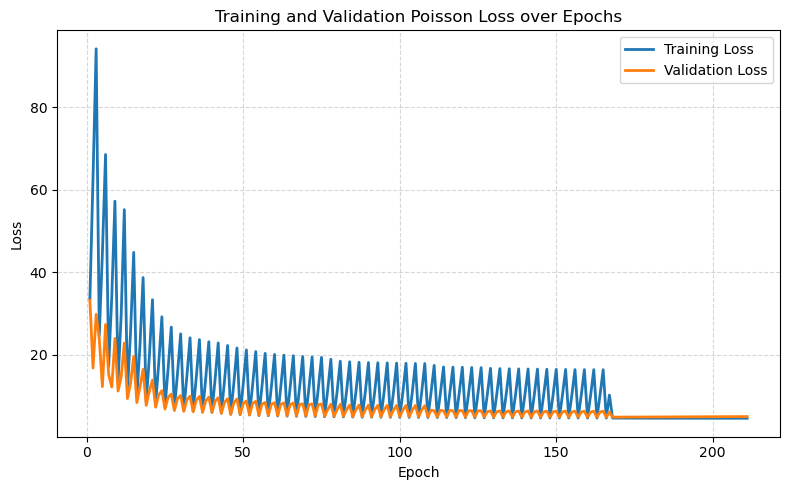

In [30]:
plot_training_history(training_history)


-----------
# 8. Most Exciting Input

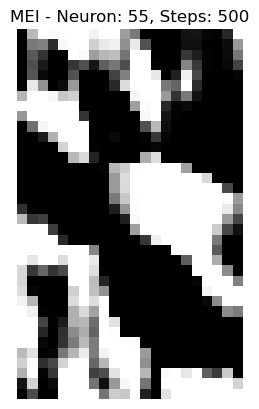

In [31]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 500
neuron_idx = 55
mei_data_key = "2023-03-15_11-05"
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    mei_data_key,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

In [46]:
# Redefine Plot MEI
# TODO: Remove later, 
def plot_mei(mei_tensor, title="MEI", save_folder=None):
    """
    mei_tensor: torch.Tensor with shape (1, C, H, W) or (C, H, W)
    """
    # Move to CPU and convert to numpy
    img = mei_tensor.detach().cpu().squeeze()

    # If single channel: shape = (H, W)
    if img.dim() == 2:
        plt.imshow(img, cmap='gray')

    # If multi-channel: shape = (C, H, W)
    elif img.dim() == 3:
        # reorder to (H, W, C)
        img = img.permute(1, 2, 0)
        plt.imshow(img)

    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    plt.title(title)
    plt.axis("off")

    if save_folder:
        filename = f"mei_{data_key}_neuron{neuron_idx:03d}.png"
        filepath = os.path.join(save_folder, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.show()
        # plt.close(fig)
    

Generating 1227 MEIs across 3 data keys...

Processing data_key: 2023-03-15_11-05 (373 neurons)
  Generating MEI 1/1227: Neuron 0


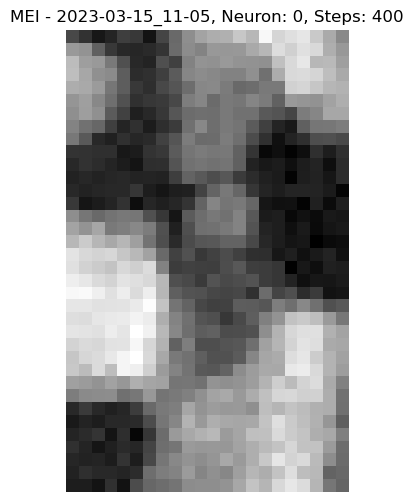

  Generating MEI 2/1227: Neuron 1


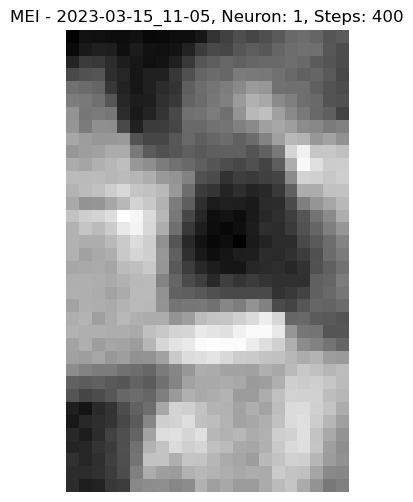

  Generating MEI 3/1227: Neuron 2


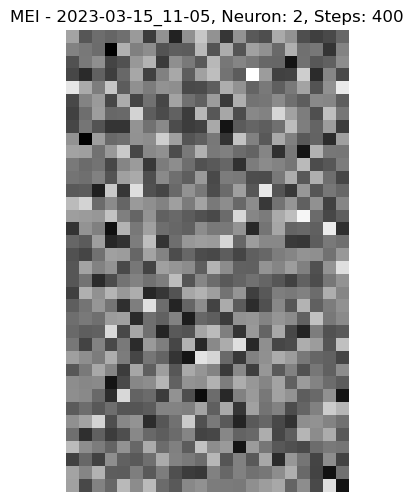

  Generating MEI 4/1227: Neuron 3


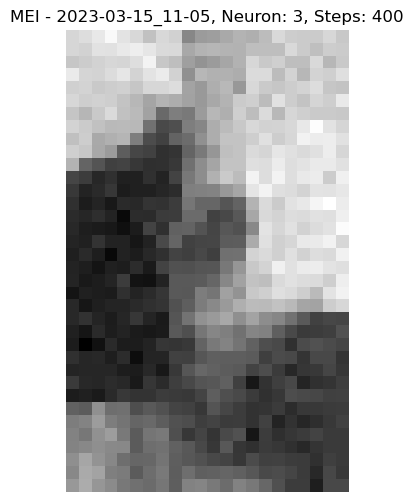

  Generating MEI 5/1227: Neuron 4


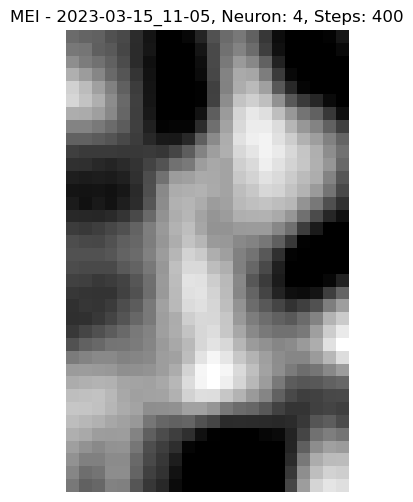

  Generating MEI 6/1227: Neuron 5


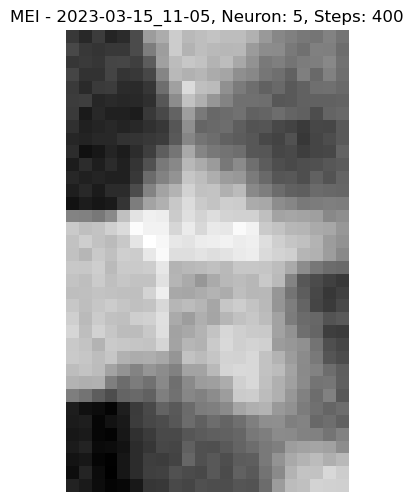

  Generating MEI 7/1227: Neuron 6


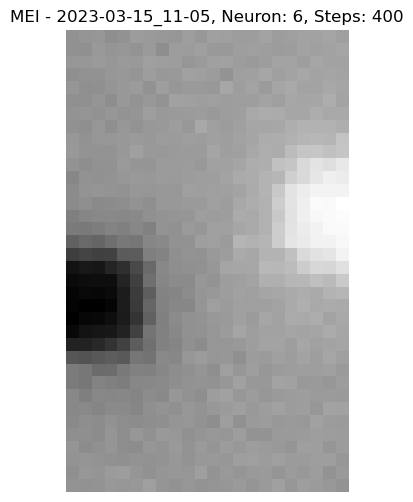

  Generating MEI 8/1227: Neuron 7


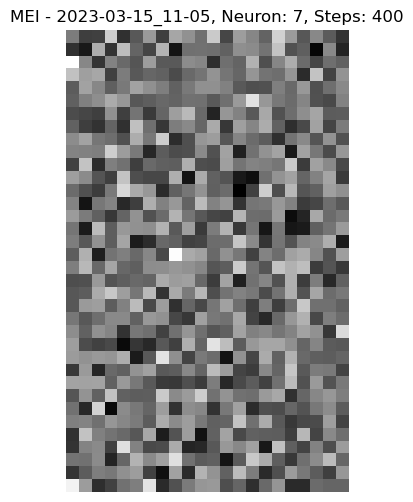

  Generating MEI 9/1227: Neuron 8


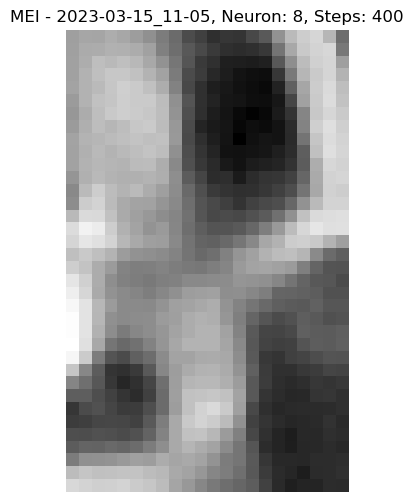

  Generating MEI 10/1227: Neuron 9


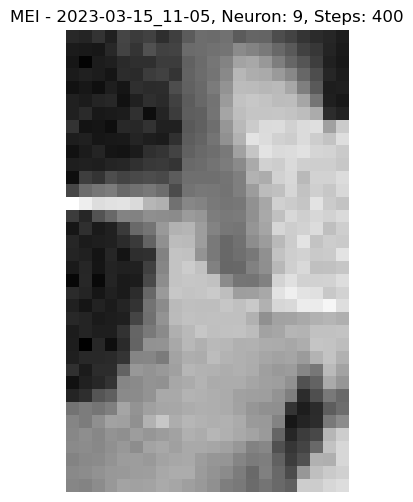

  Generating MEI 11/1227: Neuron 10


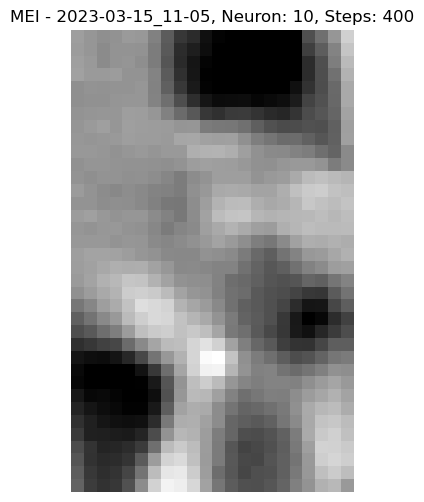

  Generating MEI 12/1227: Neuron 11


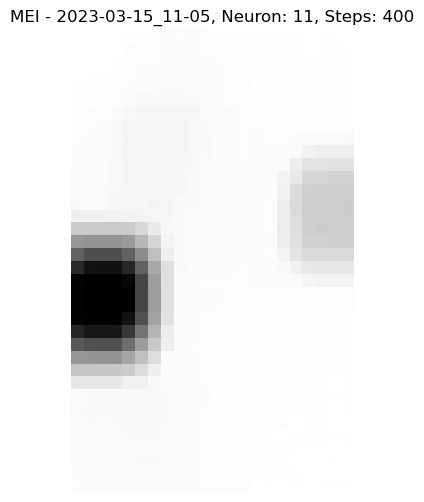

  Generating MEI 13/1227: Neuron 12


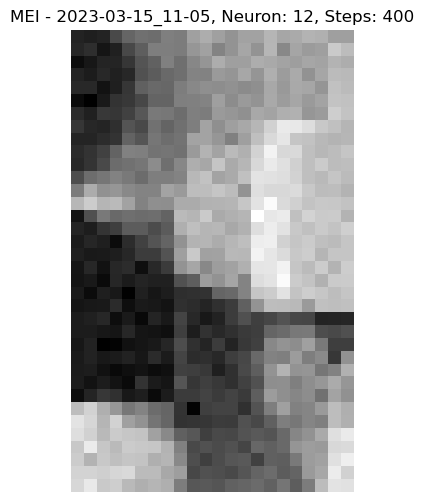

  Generating MEI 14/1227: Neuron 13


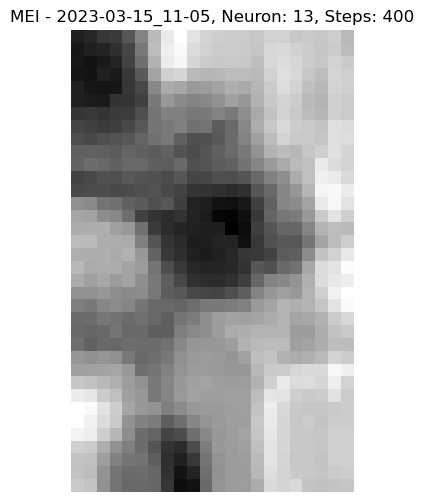

  Generating MEI 15/1227: Neuron 14


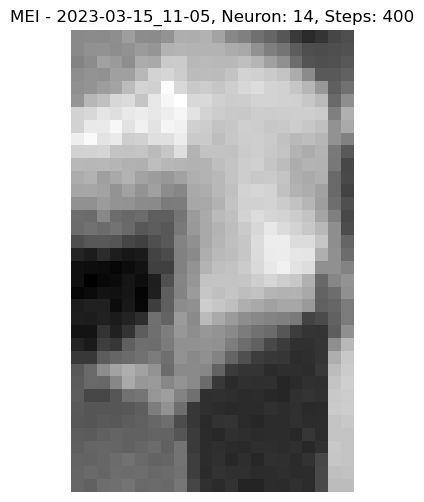

  Generating MEI 16/1227: Neuron 15


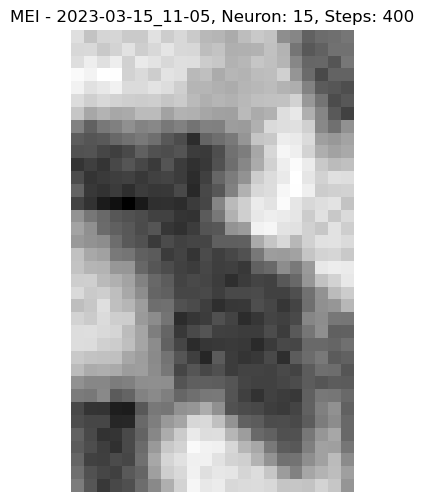

  Generating MEI 17/1227: Neuron 16


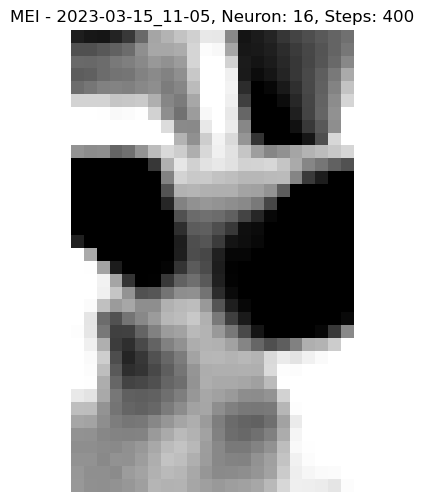

  Generating MEI 18/1227: Neuron 17


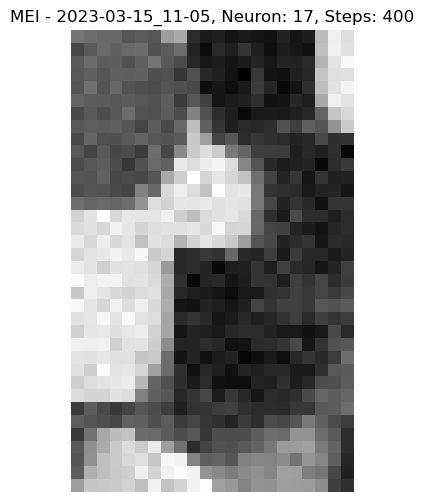

  Generating MEI 19/1227: Neuron 18


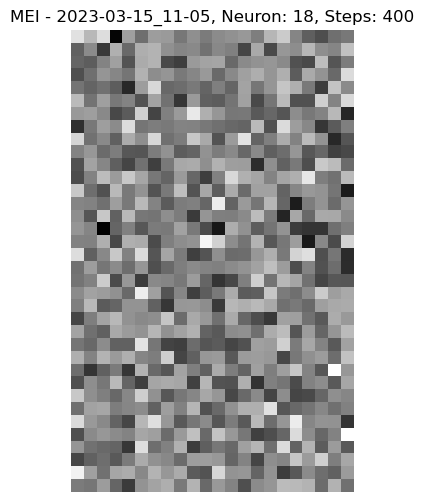

  Generating MEI 20/1227: Neuron 19


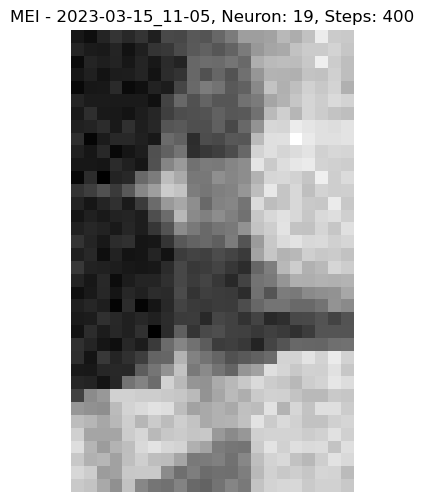

  Generating MEI 21/1227: Neuron 20


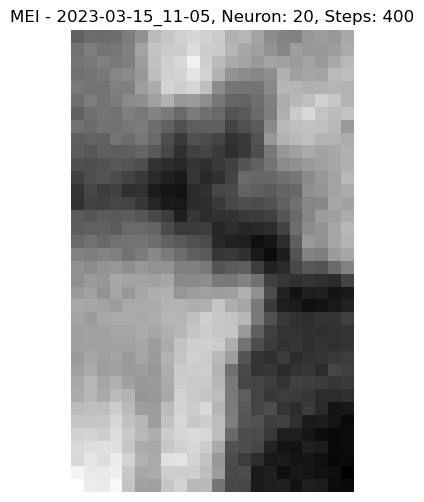

  Generating MEI 22/1227: Neuron 21


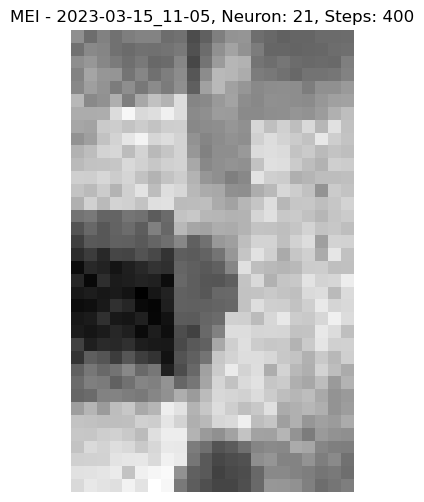

  Generating MEI 23/1227: Neuron 22


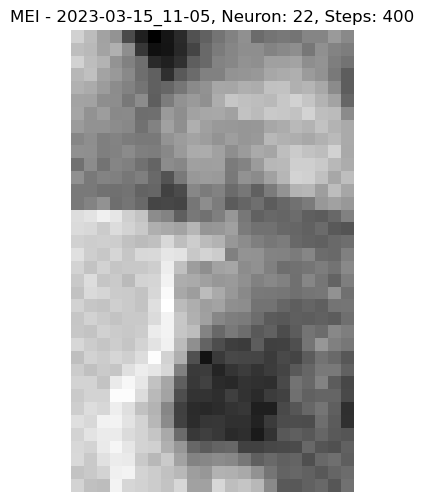

  Generating MEI 24/1227: Neuron 23


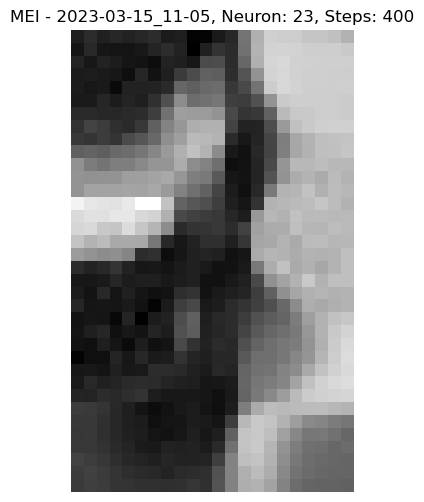

  Generating MEI 25/1227: Neuron 24


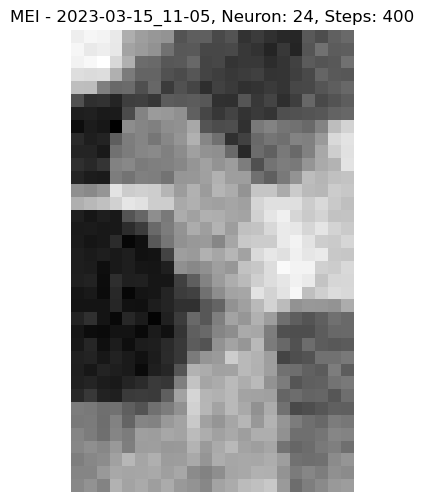

  Generating MEI 26/1227: Neuron 25


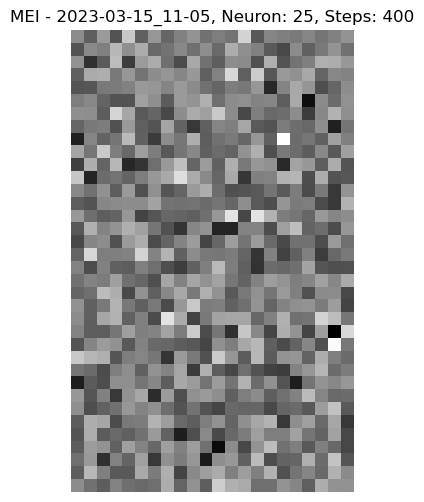

  Generating MEI 27/1227: Neuron 26


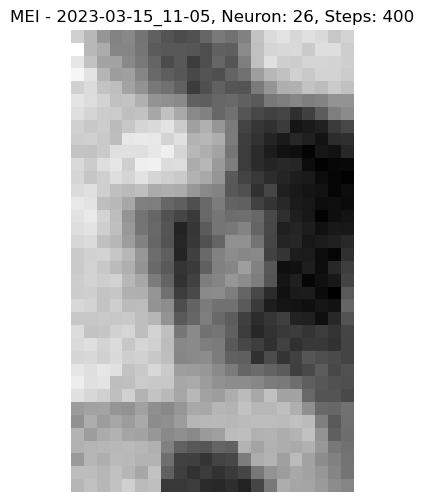

  Generating MEI 28/1227: Neuron 27


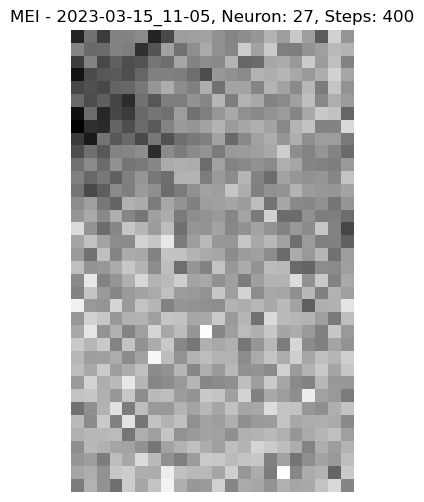

  Generating MEI 29/1227: Neuron 28


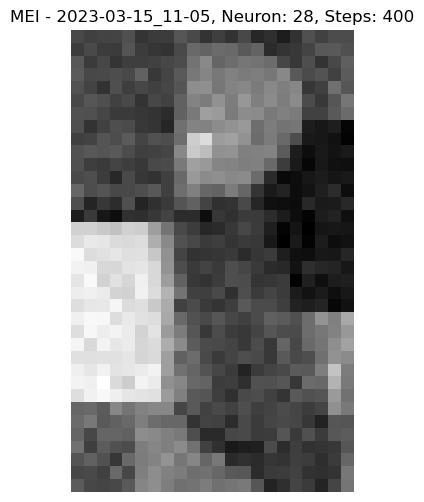

  Generating MEI 30/1227: Neuron 29


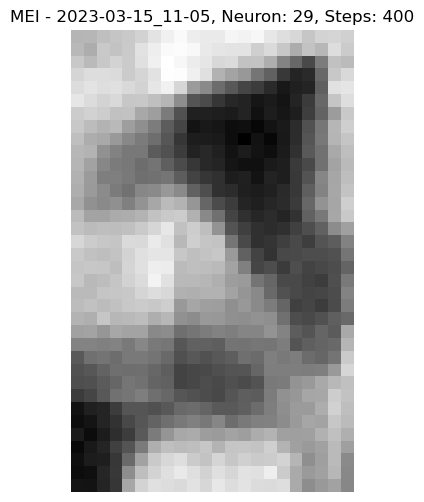

  Generating MEI 31/1227: Neuron 30


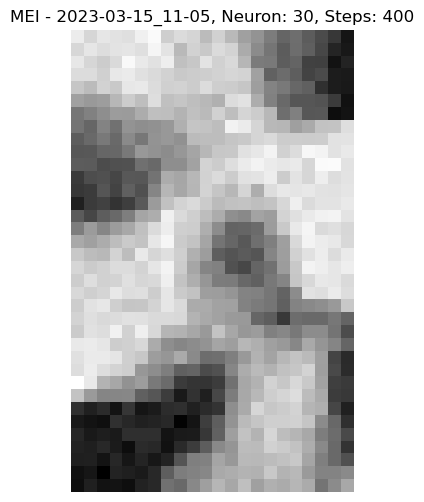

  Generating MEI 32/1227: Neuron 31


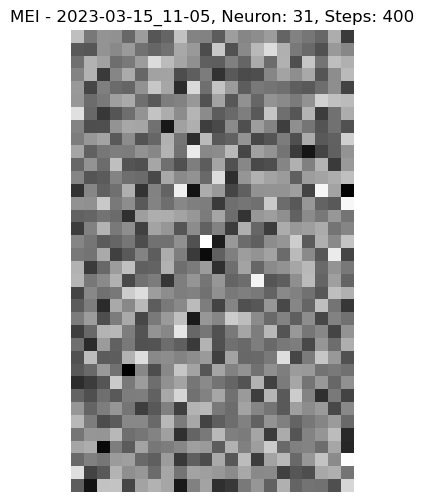

  Generating MEI 33/1227: Neuron 32


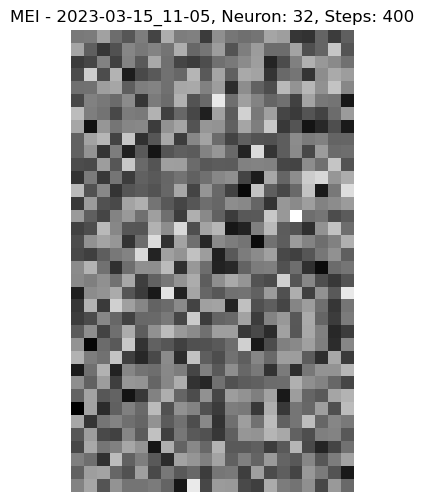

  Generating MEI 34/1227: Neuron 33


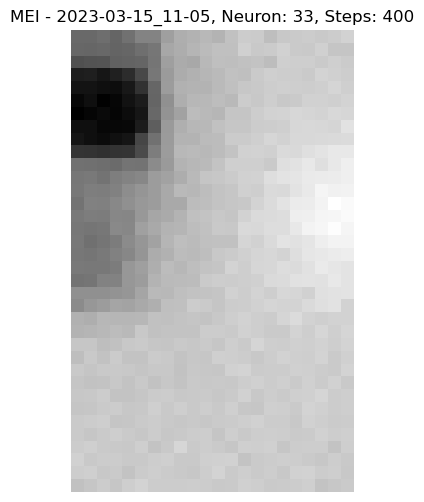

  Generating MEI 35/1227: Neuron 34


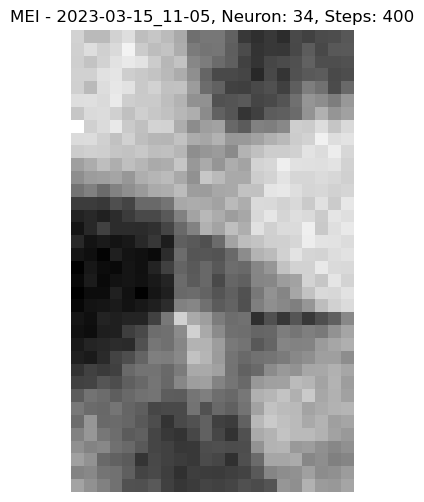

  Generating MEI 36/1227: Neuron 35


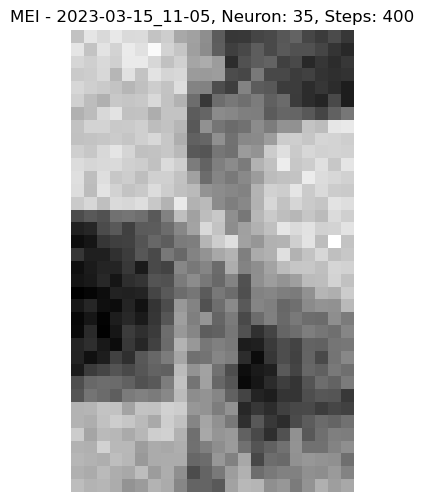

  Generating MEI 37/1227: Neuron 36


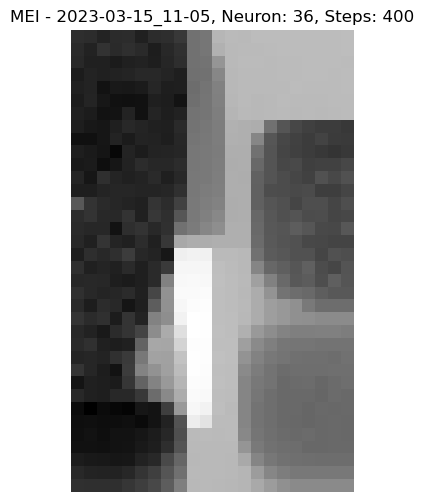

  Generating MEI 38/1227: Neuron 37


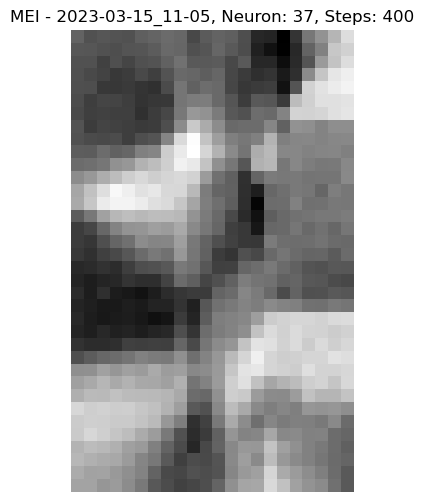

  Generating MEI 39/1227: Neuron 38


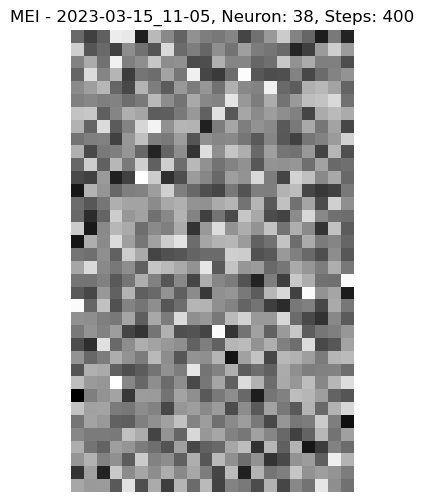

  Generating MEI 40/1227: Neuron 39


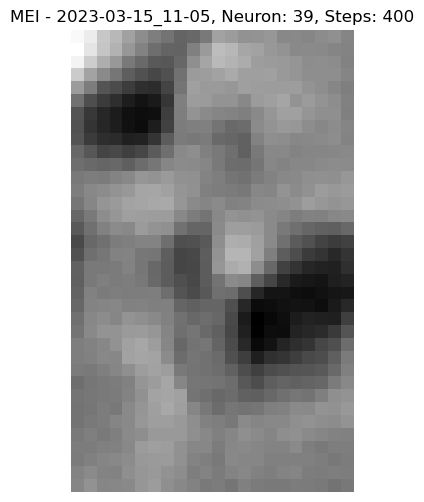

  Generating MEI 41/1227: Neuron 40


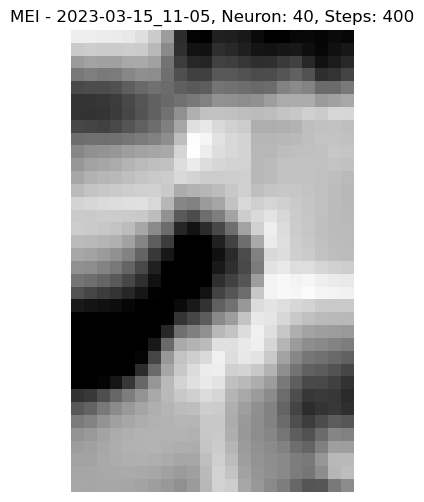

  Generating MEI 42/1227: Neuron 41


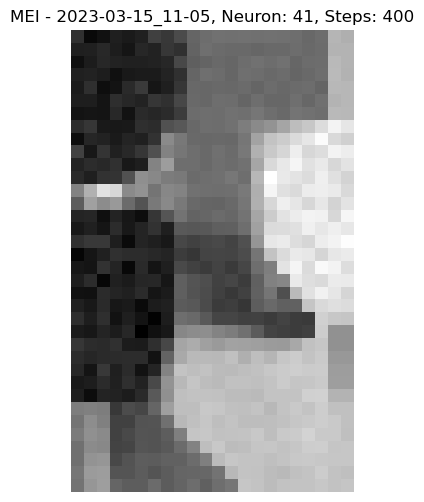

  Generating MEI 43/1227: Neuron 42


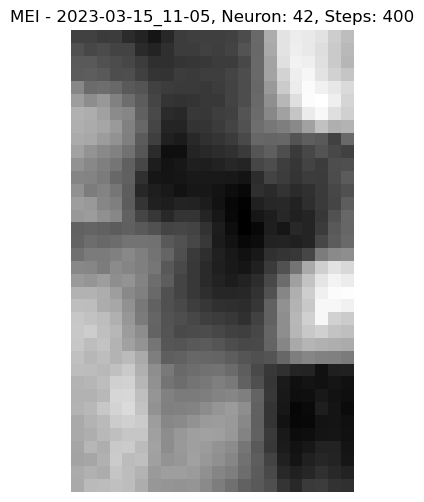

  Generating MEI 44/1227: Neuron 43


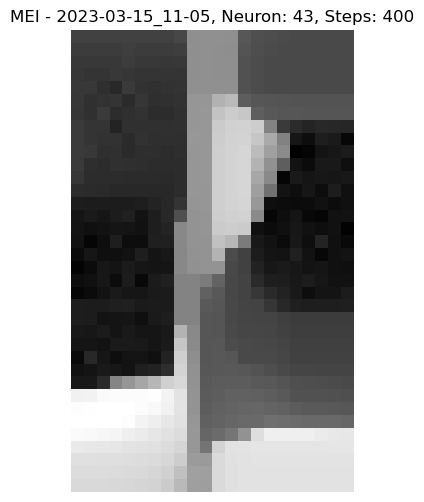

  Generating MEI 45/1227: Neuron 44


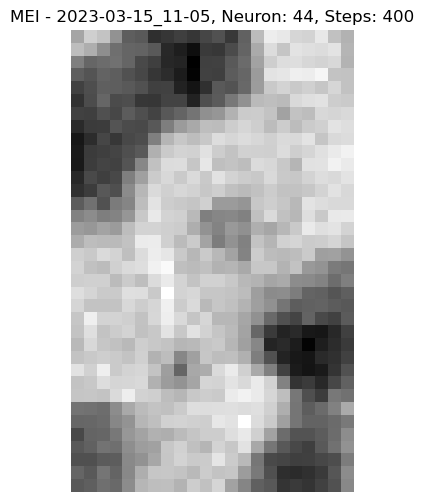

  Generating MEI 46/1227: Neuron 45


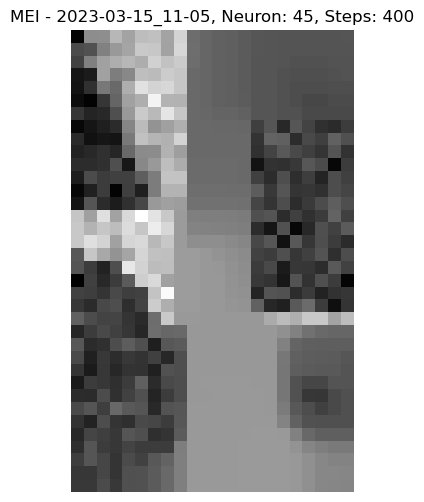

  Generating MEI 47/1227: Neuron 46


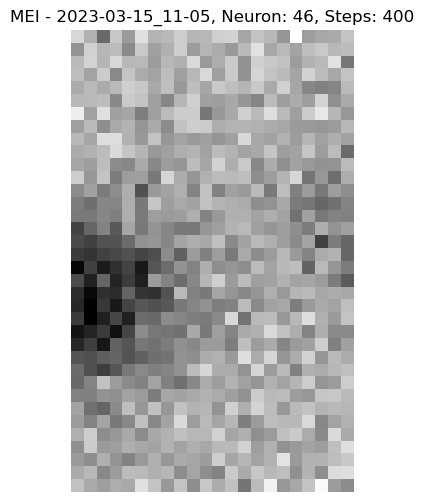

  Generating MEI 48/1227: Neuron 47


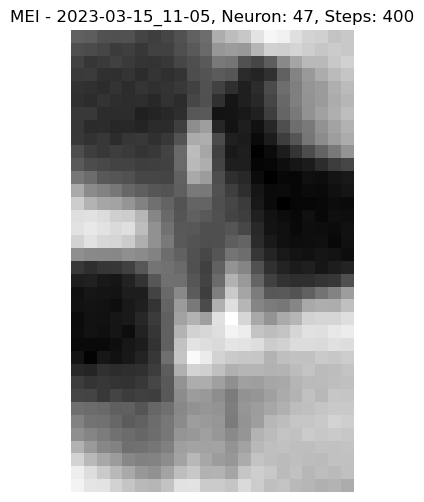

  Generating MEI 49/1227: Neuron 48


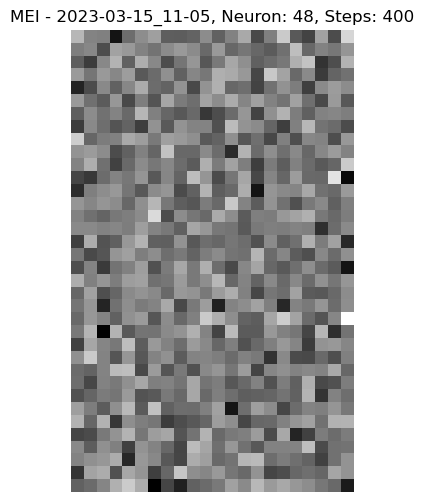

  Generating MEI 50/1227: Neuron 49


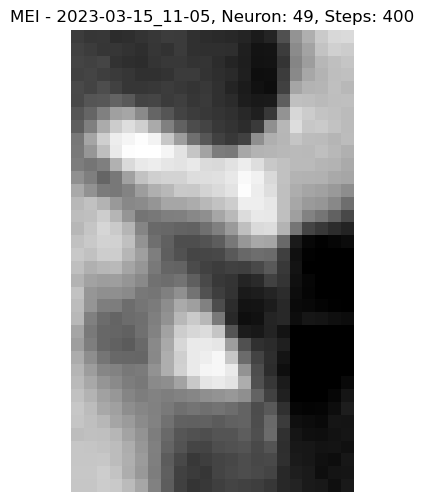

  Generating MEI 51/1227: Neuron 50


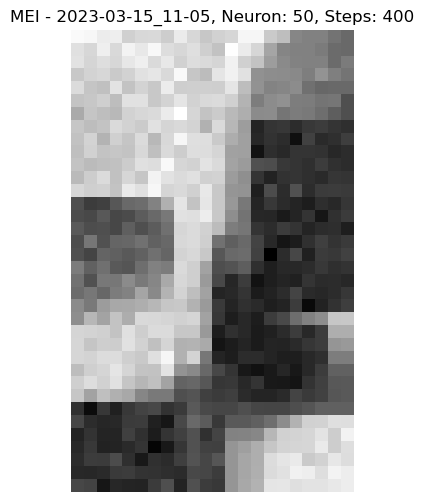

  Generating MEI 52/1227: Neuron 51


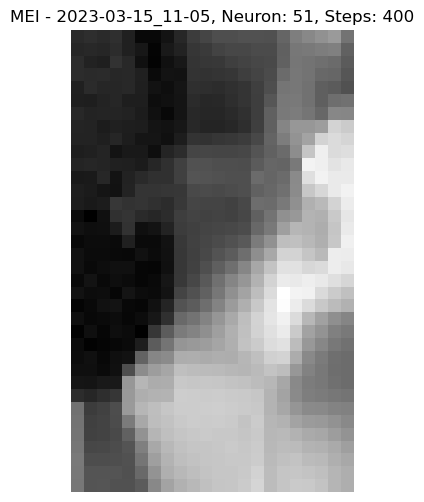

  Generating MEI 53/1227: Neuron 52


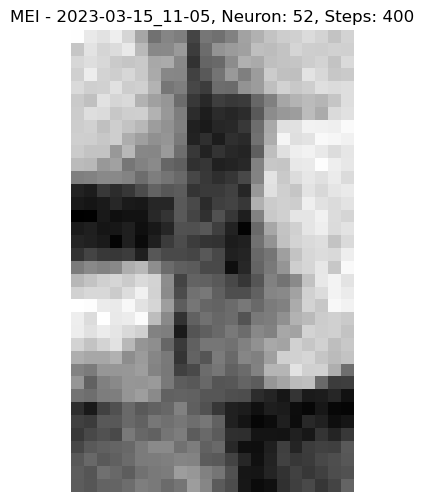

  Generating MEI 54/1227: Neuron 53


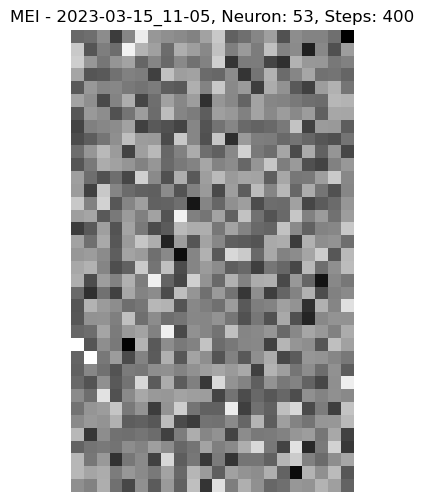

  Generating MEI 55/1227: Neuron 54


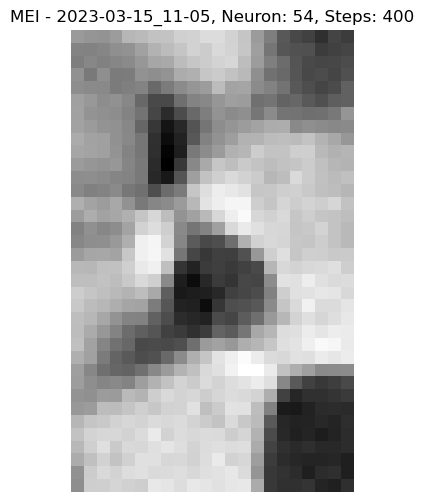

  Generating MEI 56/1227: Neuron 55


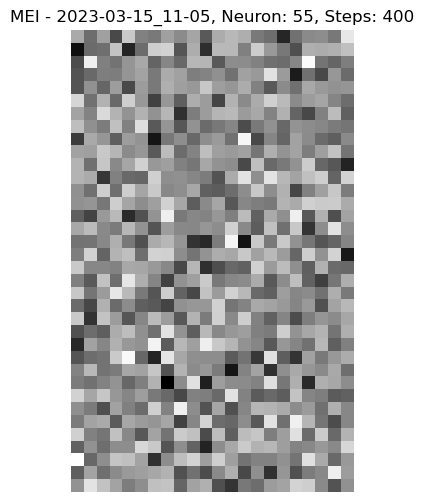

  Generating MEI 57/1227: Neuron 56


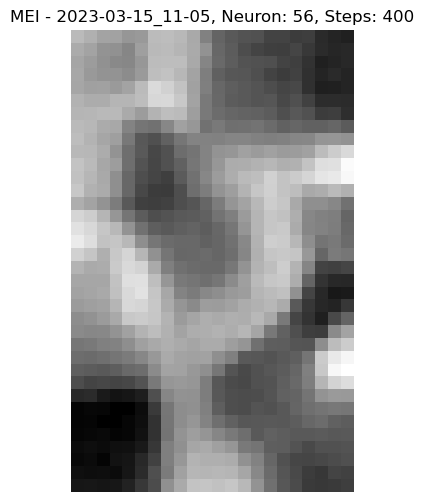

  Generating MEI 58/1227: Neuron 57


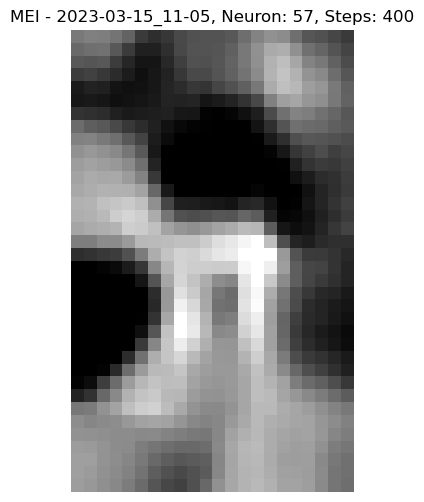

  Generating MEI 59/1227: Neuron 58


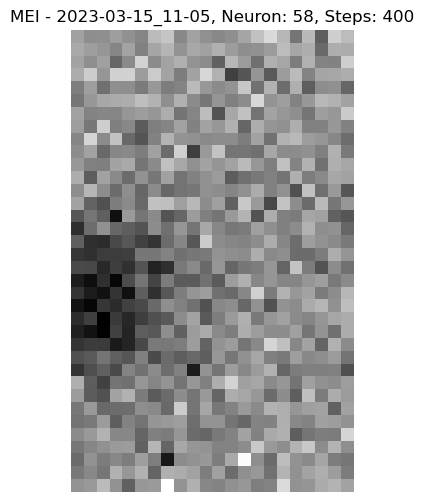

  Generating MEI 60/1227: Neuron 59


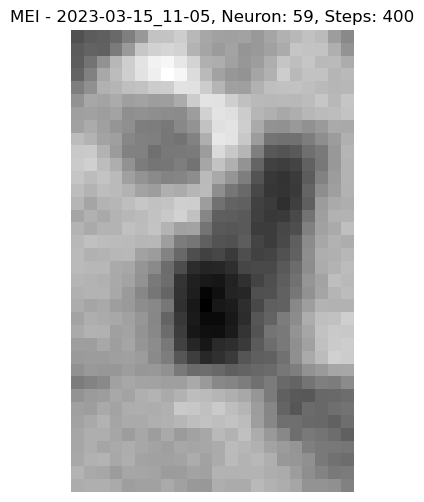

  Generating MEI 61/1227: Neuron 60


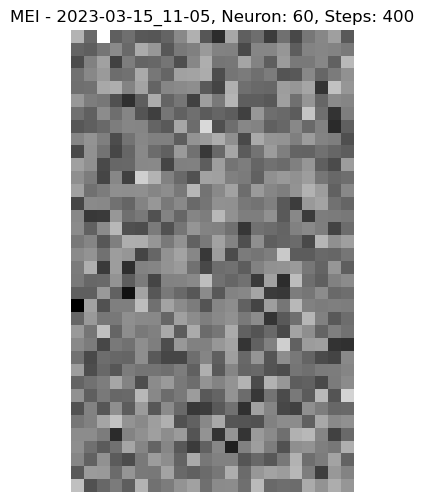

  Generating MEI 62/1227: Neuron 61


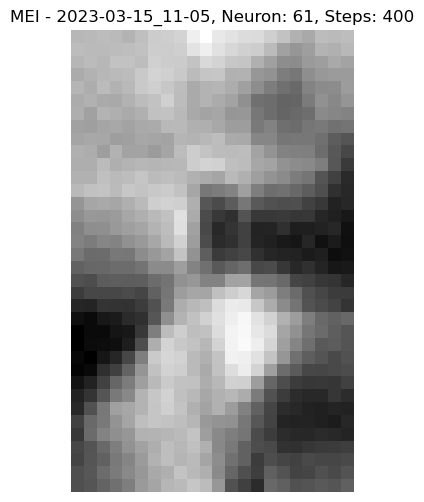

  Generating MEI 63/1227: Neuron 62


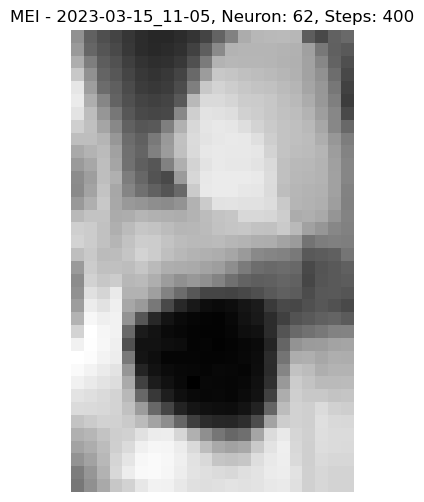

  Generating MEI 64/1227: Neuron 63


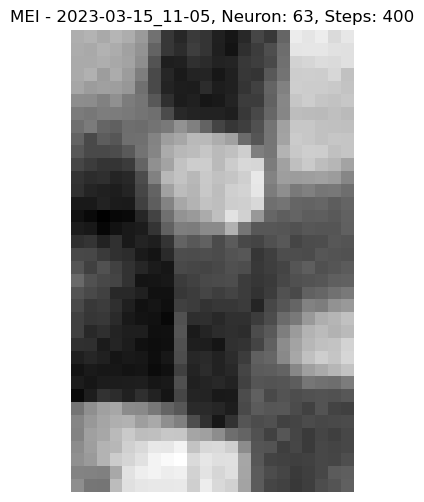

  Generating MEI 65/1227: Neuron 64


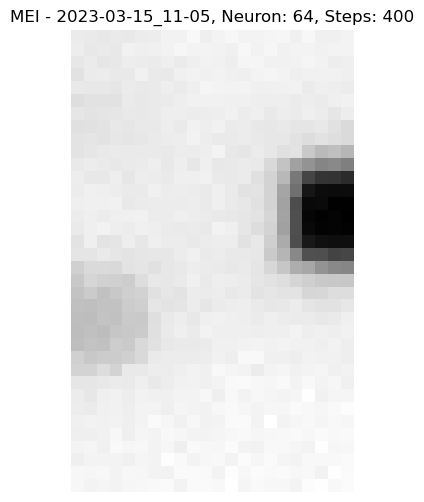

  Generating MEI 66/1227: Neuron 65


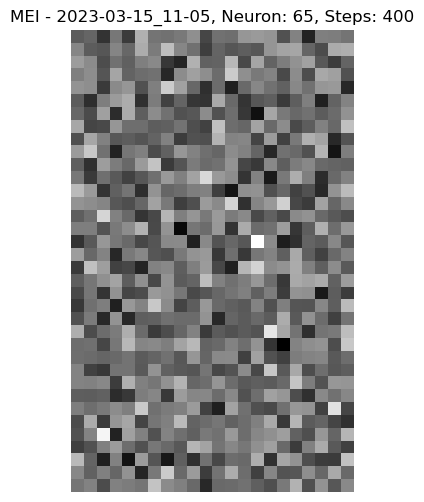

  Generating MEI 67/1227: Neuron 66


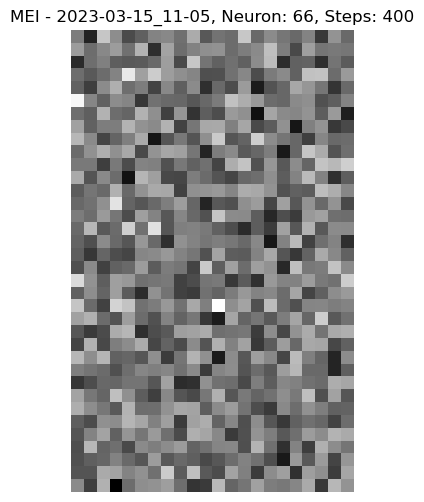

  Generating MEI 68/1227: Neuron 67


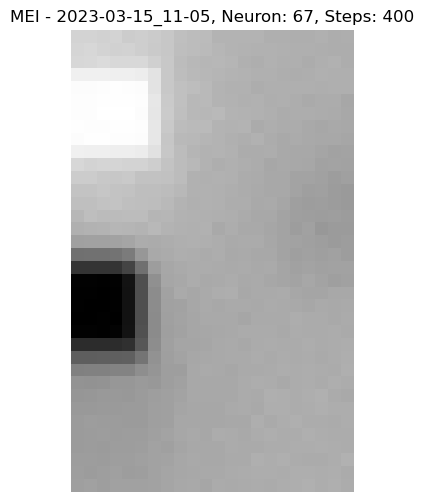

  Generating MEI 69/1227: Neuron 68


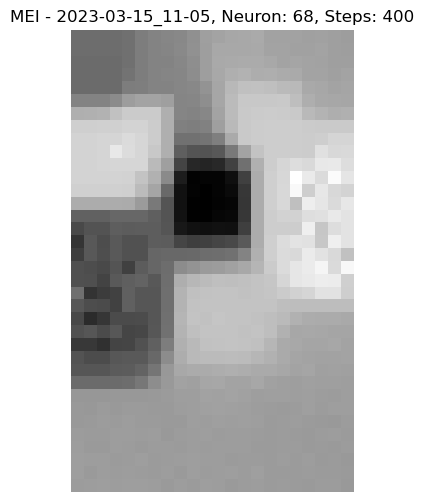

  Generating MEI 70/1227: Neuron 69


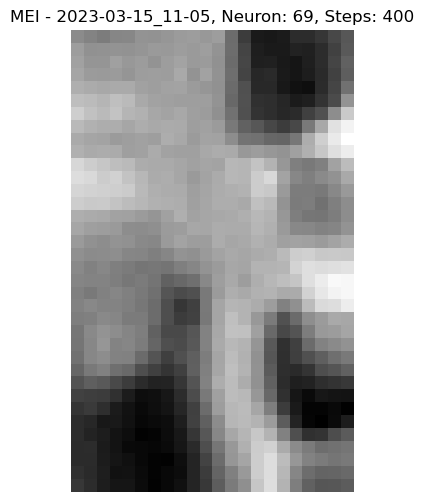

  Generating MEI 71/1227: Neuron 70


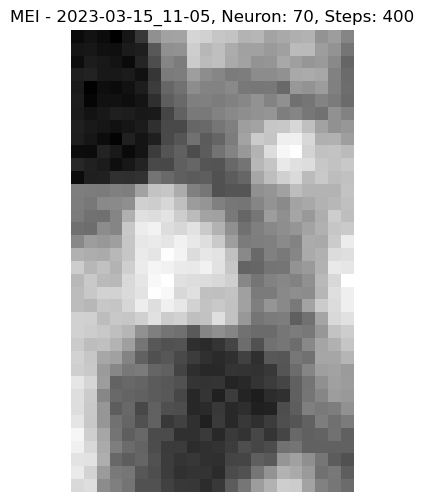

  Generating MEI 72/1227: Neuron 71


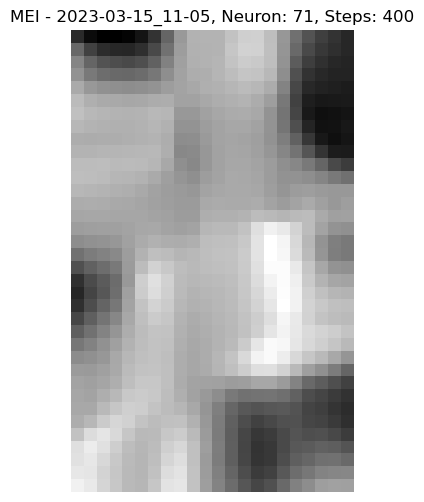

  Generating MEI 73/1227: Neuron 72


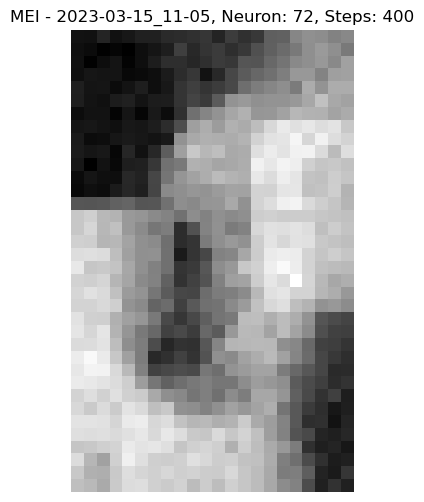

  Generating MEI 74/1227: Neuron 73


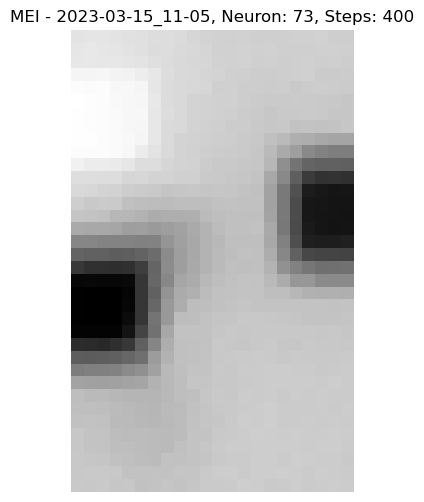

  Generating MEI 75/1227: Neuron 74


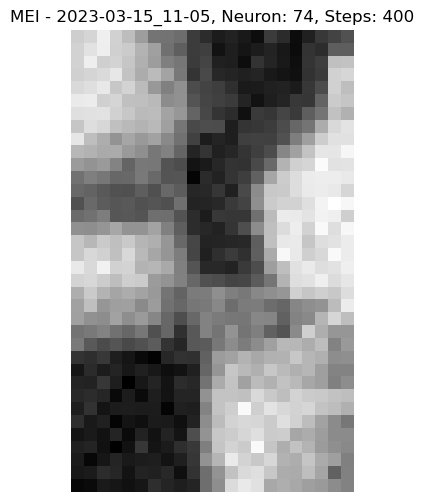

  Generating MEI 76/1227: Neuron 75


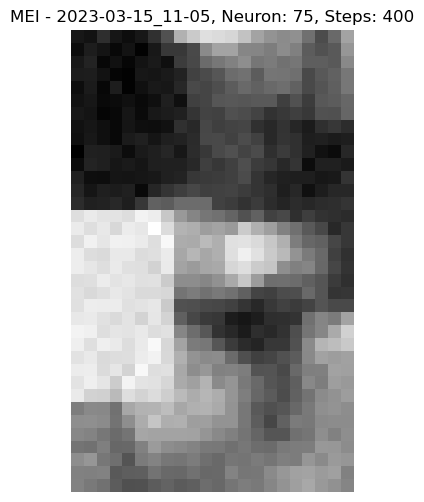

  Generating MEI 77/1227: Neuron 76


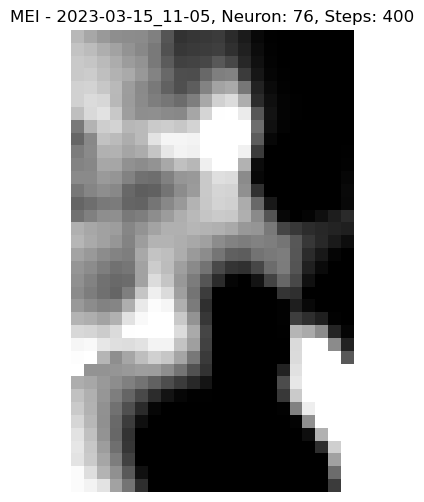

  Generating MEI 78/1227: Neuron 77


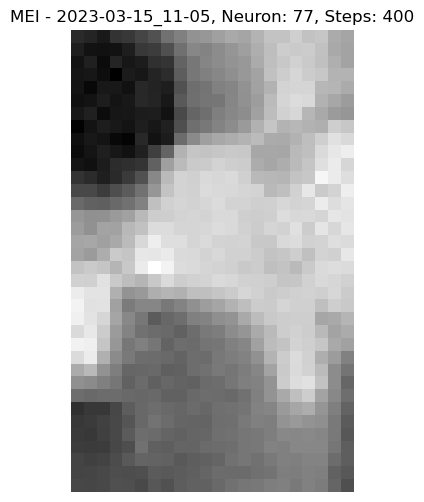

  Generating MEI 79/1227: Neuron 78


In [ ]:
save_dir = 'meis'
os.makedirs(save_dir, exist_ok=True)

steps = 400
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

n_neurons_dict = {
    '2023-03-15_11-05': 373,
    '2023-03-15_15-23': 388,
    '2022-12-20_15-08': 466
}

total_meis = sum(n_neurons_dict.values())
current_mei = 0

print(f"Generating {total_meis} MEIs across {len(n_neurons_dict.keys())} data keys...")

for data_key in n_neurons_dict.keys():
    num_neurons = n_neurons_dict[data_key]
    key_save_dir = os.path.join(save_dir, data_key)
    os.makedirs(key_save_dir, exist_ok=True)
    
    print(f"\nProcessing data_key: {data_key} ({num_neurons} neurons)")
    
    for neuron_idx in range(num_neurons):
        current_mei += 1
        print(f"  Generating MEI {current_mei}/{total_meis}: Neuron {neuron_idx}")    
        
        # Generate MEI
        mei = generate_mei(
            model,
            data_key,
            neuron_idx,
            image_shape,
            steps=steps,
            mode='cei',
            device=device
        )
        
        # Create figure and plot
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_mei(mei, title=f"MEI - {data_key}, Neuron: {neuron_idx}, Steps: {steps}", save_folder=key_save_dir)


-----------
# 9. Use MEI in the model

In [32]:
# 1. Fetch a stimulus image from the dataset
random_dataset_indx = torch.randint(len(train_dataloaders[mei_data_key]), (1,))
dataset_image = next(iter(train_dataloaders[mei_data_key]))[0].to(device)

# 2. Generate a completely random image
random_image = torch.randn(image_shape, device=device) * 0.1

# 3. Test dataset image, random image and MEI image and compare predictions
pred_random = model(random_image, data_key=mei_data_key)[0, 0, neuron_idx]
pred_dataset = model(dataset_image, data_key=mei_data_key)[0, 0, neuron_idx]
pred_mei = model(mei, data_key=mei_data_key)[0, 0, neuron_idx]

pred_random, pred_dataset, pred_mei

(tensor(0.0583, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(7.1208, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(0.0627, device='mps:0', grad_fn=<SelectBackward0>))

-----------
# 10. Sanity Checks

## 10.1 Baseline Poisson Loss

In [33]:
# 1. Reshape training responses and validation responses
training_responses = [datapoint[1] for datapoint in list(train_dataloaders["2022-12-20_15-08"])]
training_responses = torch.cat(training_responses, 0)

val_responses = [datapoint[1] for datapoint in list(test_dataloaders["2022-12-20_15-08"])]
val_responses = torch.cat(val_responses, 0)

# 2. Calculate mean
mean_rate = training_responses.mean(dim=0) # shape: (num_of_neurons)
mean_rate.shape

# 3. Repeat mean_rate for all validation samples
baseline_pred_val = mean_rate.expand(val_responses.shape[0], -1)

print("mean_rate of first neuron: ", mean_rate[0])
print("baseline_pred_val of first neuron (subset of 4): ", baseline_pred_val[:4, 0])

# 4. Define Poisson manually
def poisson_loss_manual(pred, target, eps=1e-8):
    return (pred - target * torch.log(pred + eps)).mean()

# 5. Compute baseline validation loss
manual_baseline_val_loss = poisson_loss_manual(baseline_pred_val, val_responses)
nn_baseline_val_loss = nn.PoissonNLLLoss(log_input=False, full=True)(baseline_pred_val, val_responses)

# print("Baseline validation Manual Poisson loss:", manual_baseline_val_loss.item())
print("Baseline validation NN Poisson loss:", nn_baseline_val_loss.item())


mean_rate of first neuron:  tensor(0.3306)
baseline_pred_val of first neuron (subset of 4):  tensor([0.3306, 0.3306, 0.3306, 0.3306])
Baseline validation NN Poisson loss: 4.53563928604126


## 10.2 Overfit on small dataset

In [34]:
# 1. Create a subset of the first 100 samples
test_data_key = "2022-12-20_15-08"
subset_size = 100

small_training_images = np.load(os.path.join(TRAINING_DATA_DIR, "training_images_{}.npy".format(test_data_key)))[:subset_size]
small_training_responses = np.load(os.path.join(TRAINING_DATA_DIR, "training_responses_{}.npy".format(test_data_key)))[:subset_size]
small_training_images = small_training_images.reshape(small_training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
small_training_images = torch.from_numpy(small_training_images).float()
small_training_responses = torch.from_numpy(small_training_responses).float()

# Normalize (?)
# mean = small_training_responses.mean(0)
# std = small_training_responses.std(0)
# y_norm = (small_training_responses - mean) / (std + 1e-6)

# 3. Zip training and test
# small_training_data = list(zip(small_training_images, y_norm))
small_training_data = list(zip(small_training_images, small_training_responses))

# 4. Convert to DataLoader
small_train_dataloader = DataLoader(small_training_data, batch_size=32, shuffle=False)

len(small_training_data), len(small_train_dataloader), model

(100,
 4,
 GeneralizedEncoderBase(
   (core): Stacked2dCore(
     (_input_weights_regularizer): LaplaceL2(
       (laplace): Laplace()
     )
     (features): Sequential(
       (layer0): Sequential(
         (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
         (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (nonlin): AdaptiveELU()
       )
       (layer1): Sequential(
         (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (nonlin): AdaptiveELU()
       )
       (layer2): Sequential(
         (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (nonlin): AdaptiveELU()
       )
     )
   ) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_i

In [35]:
# 1. Train on this small dataset
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=4e-3)
model.to(torch.device(device))

for epoch in range(400):
    for x_batch, y_batch in small_train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = model(x_batch, data_key=test_data_key)

        loss = poisson_loss(pred, y_batch)
        # loss = F.mse_loss(pred, y_batch)
        # print("Pred std:", pred.std().item(), "Resp std:", y_batch.std().item())
        loss.backward()
        
        optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")


Epoch 0: loss = 5.9656
Epoch 20: loss = 4.1362
Epoch 40: loss = 4.0581
Epoch 60: loss = 3.9846
Epoch 80: loss = 3.9878
Epoch 100: loss = 3.9500
Epoch 120: loss = 3.9438
Epoch 140: loss = 3.9172
Epoch 160: loss = 3.8313
Epoch 180: loss = 3.8118
Epoch 200: loss = 3.9978
Epoch 220: loss = 4.2088
Epoch 240: loss = 3.9022
Epoch 260: loss = 3.8163
Epoch 280: loss = 3.8742
Epoch 300: loss = 3.7895
Epoch 320: loss = 3.7667
Epoch 340: loss = 3.8018
Epoch 360: loss = 3.7981
Epoch 380: loss = 3.7524


In [36]:
# Testing the variance of model core outputs
with torch.no_grad():
    feats = model.core(small_training_images.to(device))
    print("Mean of features:", feats.mean().item())
    print("Std of features:", feats.std().item())

# Printing out gradients to check their value
print("-----")
print("Gradients")
for name, p in model.core.named_parameters():
    if p.grad is not None:
        print(name, p.grad.abs().mean())

# Print the gradient norm at the readout parameters
# for name, p in model.readout["2023-03-15_11-05"].named_parameters():
#     print(name, p.grad.norm())


Mean of features: -0.8563333749771118
Std of features: 1.704864501953125
-----
Gradients
features.layer0.conv.weight tensor(0.0042, device='mps:0')
features.layer0.norm.weight tensor(0.1185, device='mps:0')
features.layer0.norm.bias tensor(0.0534, device='mps:0')
features.layer1.conv.weight tensor(0.0004, device='mps:0')
features.layer1.conv.bias tensor(9.1405e-05, device='mps:0')
features.layer1.norm.weight tensor(0.1576, device='mps:0')
features.layer1.norm.bias tensor(0.0043, device='mps:0')
features.layer2.conv.weight tensor(0.0025, device='mps:0')
features.layer2.conv.bias tensor(0.0001, device='mps:0')
features.layer2.norm.weight tensor(0.7699, device='mps:0')
features.layer2.norm.bias tensor(0.0042, device='mps:0')
